<a href="https://colab.research.google.com/github/ArpitJIndal29/CS698R/blob/main/MAB_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x
# !pip install stable-baselines[mpi]==2.10.0

!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (458 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [ ]:
# class fourarmedbandit(gym.Env):
#     def __init__(self, trend = True, high = False, seed=0):
#         self.set_seed(seed)
        
#         super(fourarmedbandit, self).__init__()
        
#         self.trend = trend
#         self.high = high
#         self.e = 0
#         self.trend_val = 0.5*np.array([1, 1, -1, -1])
#         reward = np.zeros(4)
#         self.lamda = 0.999
#         self.sigma_ex = 2
#         self.unex_high = 16
#         self.unex_low = 4
#         reward[0] = initial_mu_values[0]
#         reward[1] = initial_mu_values[1]
#         reward[2] = initial_mu_values[2]
#         reward[3] = initial_mu_values[3]
#         self.reward_space = reward
#         self.length = 4
#         self.action_space = spaces.Tuple((spaces.Discrete(self.length), spaces.Discrete(self.length)))
#         self.observation_space = spaces.Box(low=-np.inf, 
#                                      high=np.inf, shape = (4,memory_len), dtype=np.float32)
#         self.score = 0
#         self.length = 4
#         self.agent_position = 4
#         self.state = np.zeros((4,memory_len))
#         self.optm = 3

#         self.episode_reward_history = []
#         self.reward_history = []

#         self.episode_optimal_history = []
#         self.optimal_history = []
#         self.rewards = np.zeros((4))

#     def set_seed(self, seed = 0):
#         np.random.seed(seed)
    
#     def step(self, action, rend = False, rng = np.random.RandomState(1111)):
#         reward = 0
#         if rend:
#             self.render(reward)

#         self.rewards = rng.normal(self.reward_space, self.sigma_ex)
#         reward = self.rewards[action]
#         self.optm = np.max(self.rewards)
#         optimal_action = np.argmax(self.rewards)
#         self.score += reward
#         if rend:
#             self.render(reward, a = action)
#         var = self.unex_low
#         if ( self.high & (((self.e<=100) & (self.e>50)) | ((self.e<=200) & (self.e>150))) ):
#             var = self.unex_high
#         self.reward_space = self.lamda * self.reward_space + rng.normal(0, var, size = (4))
#         if self.trend:
#             self.reward_space += self.trend_val
#         self.e += 1
#         done = False
#         self.episode_reward_history.append(reward)
#         self.episode_optimal_history.append(self.optm)
#         if self.e == 200:
#             done = True
#             self.reward_history.append(np.sum(self.episode_reward_history))
#             self.optimal_history.append(np.sum(self.episode_optimal_history))
#             self.episode_reward_history = []
#             self.episode_optimal_history = []

#         temp = self.state[action].tolist()
#         temp.pop(0)
#         temp.append(reward)
#         self.state[action] = np.array(temp)

#         # print(f'  Step: {self.e} || Reward: {reward} || Action: {action} || Optimal: {optimal_action}')

#         return self.state, reward, done, {}

#     def reset(self):
        
#         self.e = 0
#         self.score = 0
#         reward = np.zeros(4)
#         reward[0] = initial_mu_values[0]
#         reward[1] = initial_mu_values[1]
#         reward[2] = initial_mu_values[2]
#         reward[3] = initial_mu_values[3]
#         self.reward_space = reward
#         self.agent_position = 4
#         self.state = np.zeros((4,memory_len))
#         self.optm = 3
#         return self.state

#     def render(self, r, a = -1):
#         pass
      

In [ ]:
def ucbfunc(env, maxep = 1000, rng = np.random.RandomState(1111)):
    env.reset()
    e = 0
    c = 100
    Q = np.zeros(env.length)
    N = np.zeros(env.length)
    qkeep = np.zeros([maxep, env.length])
    r_dict = np.zeros(maxep)
    regret = np.zeros(maxep)
    optimal_action = np.zeros(maxep)
    optim = 0
    while(e < maxep):
        ac = np.argmax(env.reward_space)
        v_star = np.max(env.reward_space)
        if e < env.length :
            a = e
        else:
            U = c * np.sqrt(np.log(e)/N)
            a = np.argmax(Q + U)
        if e==0:
            regret[e] = v_star - Q[a]
        else:
            regret[e] = regret[e-1] + v_star - Q[a]
        if ac == a:
            optim += 1
        optimal_action[e] = (optim/(e+1))*100
        _, R, done, _ = env.step(a, rend = False,rng = rng)
        r_dict[e] = R
        N[a] += 1
        Q[a] = Q[a] + (R - Q[a])/N[a]
        qkeep[e] = Q
        e += 1
    return optimal_action, regret, r_dict, qkeep

def softmaxfunc(env, maxep = 1000, rng = np.random.RandomState(1111)):
    env.reset()
    e = 0
    tou = 20
    decay = 0.1
    Q = np.zeros(env.length)
    N = np.zeros(env.length)
    qkeep = np.zeros([maxep, env.length])
    r_dict = np.zeros(maxep)
    regret = np.zeros(maxep)
    optimal_action = np.zeros(maxep)
    optim = 0
    while(e < maxep):
        ac = np.argmax(env.reward_space)
        v_star = np.max(env.reward_space)
        probs = np.exp(Q/tou)/np.sum(np.exp(Q/tou))
        a = rng.choice(env.length, 1, p = probs)
        if e==0:
            regret[e] = v_star - Q[a]
        else:
            regret[e] = regret[e-1] + v_star - Q[a]
        if ac == a:
            optim += 1
        optimal_action[e] = (optim/(e+1))*100
        _, R, done, _ = env.step(a[0], rend = False, rng = rng)
        r_dict[e] = R
        N[a] += 1
        Q[a] = Q[a] + (R - Q[a])/N[a]
        # if e < 50:
        #     tou -= decay
        qkeep[e] = Q
        e += 1
    return optimal_action, regret, r_dict, qkeep

def epsilongreedy(env, maxep = 200, epsilon = 0.1, decay = 0, isdecaylinear = True, rng = np.random.RandomState(1111)):
    env.reset()
    e = 0
    a = 0
    Q = np.zeros(env.length)
    N = np.zeros(env.length)
    qkeep = np.zeros([maxep, env.length])
    r_dict = np.zeros(maxep)
    regret = np.zeros(maxep)
    optimal_action = np.zeros(maxep)
    optim = 0
    action = np.zeros(maxep)
    while(e < maxep):
        ac = np.argmax(env.reward_space)
        v_star = np.max(env.reward_space)
        if rng.uniform(0, 1) >= epsilon:
            a = np.argmax(Q)
        else:
            a = rng.randint(0, env.length)
        action[e] = a
        if e==0:
            regret[e] = v_star - Q[a]
        else:
            regret[e] = regret[e-1] + v_star - Q[a]
        if a == ac:
            optim += 1
        optimal_action[e] = (optim/(e+1))*100
        if isdecaylinear:
            epsilon -= decay
        else:
            epsilon *= decay
        _, R, done,_ = env.step(a, rend = False, rng = rng)
        r_dict[e] = R
        N[a] += 1
        Q[a] = Q[a] + (R - Q[a])/N[a]
        qkeep[e] = Q
        e += 1
    return optimal_action, regret, r_dict, action, qkeep

In [ ]:
import gym
import numpy as np
from gym import spaces
from gym.utils import seeding
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
initial_mu_values = [-60, -20, 20, 60]
memory_len = 8
class fourarmedbandit(gym.Env):
    def __init__(self, trend = True, high = False, seed=0):
        self.set_seed(seed)
        
        super(fourarmedbandit, self).__init__()
        
        self.trend = trend
        self.high = high
        self.e = 0
        self.trend_val = 0.5*np.array([1, 1, -1, -1])
        reward = np.zeros(4)
        self.lamda = 0.999
        self.sigma_ex = 2
        self.unex_high = 16
        self.unex_low = 4
        reward[0] = initial_mu_values[0]
        reward[1] = initial_mu_values[1]
        reward[2] = initial_mu_values[2]
        reward[3] = initial_mu_values[3]
        self.reward_space = reward
        self.length = 4
        self.action_space = spaces.Discrete(self.length,)
        self.observation_space = spaces.Box(low=-np.inf, 
                                     high=np.inf, shape = (4,memory_len), dtype=np.float32)
        self.score = 0
        self.length = 4
        self.agent_position = 4
        self.state = np.zeros((4,memory_len))
        self.optm = 3

        self.episode_reward_history = []
        self.reward_history = []

        self.episode_optimal_history = []
        self.optimal_history = []
        self.rewards = np.zeros((4))

    def set_seed(self, seed = 0):
        np.random.seed(seed)
    
    def step(self, action, rend = False, rng = np.random.RandomState(1111)):
        reward = 0
        if rend:
            self.render(reward)

        self.rewards = rng.normal(self.reward_space, self.sigma_ex)
        reward = self.rewards[action]
        self.optm = np.max(self.rewards)
        optimal_action = np.argmax(self.rewards)
        self.score += reward
        if rend:
            self.render(reward, a = action)
        var = self.unex_low
        if ( self.high & (((self.e<=100) & (self.e>50)) | ((self.e<=200) & (self.e>150))) ):
            var = self.unex_high
        self.reward_space = self.lamda * self.reward_space + rng.normal(0, var, size = (4))
        if self.trend:
            self.reward_space += self.trend_val
        self.e += 1
        done = False
        self.episode_reward_history.append(reward)
        self.episode_optimal_history.append(self.optm)
        if self.e == 200:
            done = True
            self.reward_history.append(np.sum(self.episode_reward_history))
            self.optimal_history.append(np.sum(self.episode_optimal_history))
            self.episode_reward_history = []
            self.episode_optimal_history = []

        temp = self.state[action].tolist()
        temp.pop(0)
        temp.append(reward)
        self.state[action] = np.array(temp)

        # print(f'  Step: {self.e} || Reward: {reward} || Action: {action} || Optimal: {optimal_action}')

        return self.state, reward, done, {}

    def reset(self):
        
        self.e = 0
        self.score = 0
        reward = np.zeros(4)
        reward[0] = initial_mu_values[0]
        reward[1] = initial_mu_values[1]
        reward[2] = initial_mu_values[2]
        reward[3] = initial_mu_values[3]
        self.reward_space = reward
        self.agent_position = 4
        self.state = np.zeros((4,memory_len))
        self.optm = 3
        return self.state

    def render(self, r, a = -1):
        pass
      

(3, 1)

In [ ]:
env1 = fourarmedbandit()
env2 = fourarmedbandit()
env2.__init__(high = True)
env3 = fourarmedbandit()
env3.__init__(trend = False)
env4 = fourarmedbandit()
env4.__init__(trend = False, high = True)

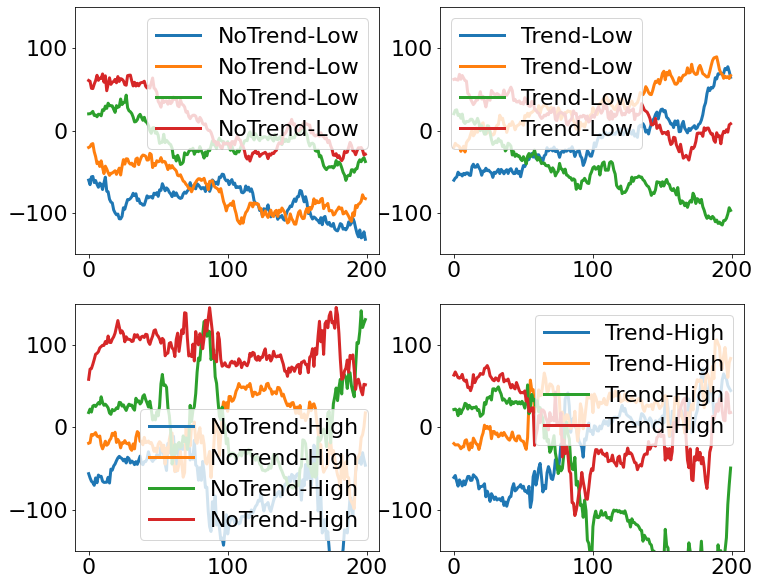

In [ ]:
n_trials = 1
rew1 = np.zeros((n_trials, 200, 4))
rew2 = np.zeros((n_trials, 200, 4))
rew3 = np.zeros((n_trials, 200, 4))
rew4 = np.zeros((n_trials, 200, 4))
for k in range(n_trials):
    env1.set_seed(0)
    env2.set_seed(0)
    env3.set_seed(0)
    env4.set_seed(0)
    rng = np.random.RandomState(seed = 1220+k)
    for j in range(4):
        for i in range(200):
            _,rew1[k][i][j],_,_ = env1.step(j, rng=rng)
            _,rew2[k][i][j],_,_ = env2.step(j, rng=rng)
            _,rew3[k][i][j],_,_ = env3.step(j, rng=rng)
            _,rew4[k][i][j],_,_ = env4.step(j, rng=rng)
        env1.reset()
        env2.reset()
        env3.reset()
        env4.reset()
linewidth = 3
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 22})
plt.subplot(2,2,2)
plt.plot(np.average(rew1, axis=0), label = 'Trend-Low', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,4)
plt.plot(np.average(rew2, axis=0), label = 'Trend-High', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,1)
plt.plot(np.average(rew3, axis=0), label = 'NoTrend-Low', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,3)
plt.plot(np.average(rew4, axis=0), label = 'NoTrend-High', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.show()

In [ ]:
# from stable_baselines.common.env_checker import check_env
# env1 = fourarmedbandit()
# check_env(env1, warn=True)

In [ ]:
# import gym

# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines.deepq.policies import MlpPolicy
# from stable_baselines import DQN
# gamma = 0
# exploration_fraction = 0.2
# exploration_initial_eps = 1.0
# exploration_final_eps = 0.05
# learning_rate = 0.01
# buffer_size = 1000000
# learning_starts = 10000
# batch_size = 32
# seed = 0
# double_q = False
# PER = False
# param_noise = False

# env = fourarmedbandit(seed=seed, trend = True, high=True)
# env.reset()
# policy_kwargs = dict(layers=[400,300])
# model = DQN('MlpPolicy', env, verbose=2, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
#             exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, double_q = double_q,
#             buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
#             seed = seed, target_network_update_freq=250, policy_kwargs = policy_kwargs, prioritized_replay=PER, param_noise=param_noise)
# # Train the agent
# model.learn(total_timesteps=int(200*500))
# # Save the agent
# model.save("rmab")

In [ ]:
"""

Case 1: DQN env with trend=True and high=True

"""




from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
env_dqn1 = fourarmedbandit(seed=seed, trend = True, high=True)
env_dqn1.reset()
policy_kwargs = dict(net_arch=[400,300])
model1 = DQN('MlpPolicy', env_dqn1, verbose=2, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model1.learn(total_timesteps=int(200*500))
# Save the agent
model1.save("rmab")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 1.45e+03 |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4358     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.08e+03 |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4190     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.87e+

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


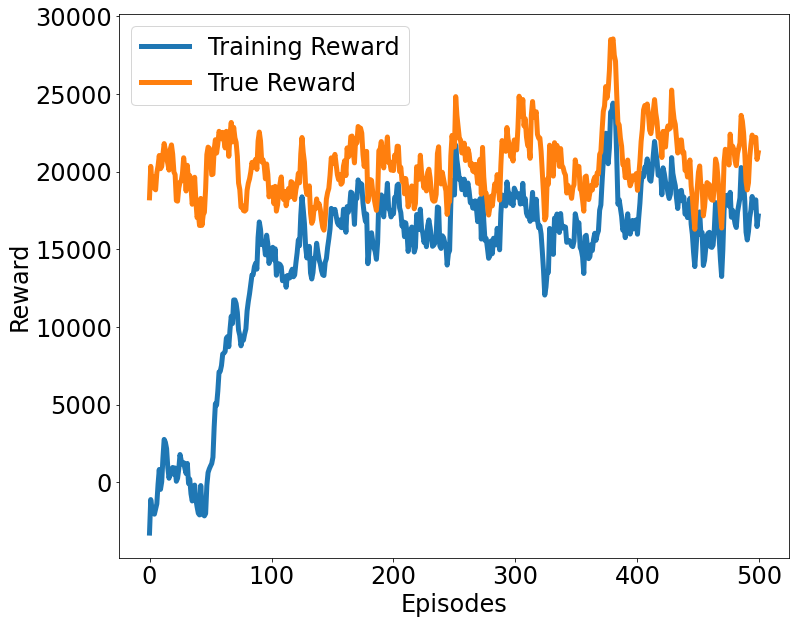

In [ ]:
import matplotlib.pyplot as plt
def numpy_ewma_vectorized_v2(data, window):

  alpha = 2 /(window + 1.0)
  alpha_rev = 1-alpha
  n = data.shape[0]

  pows = alpha_rev**(np.arange(n+1))

  scale_arr = 1/pows[:-1]
  offset = data[0]*pows[1:]
  pw0 = alpha*alpha_rev**(n-1)

  mult = data*pw0*scale_arr
  cumsums = mult.cumsum()
  out = offset + cumsums*scale_arr[::-1]
  return out
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn1.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn1.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with trend & high volatility")
# plt.title("DQN for trend and high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_trend_high.eps', format='eps')
plt.savefig('dqn_training_trend_high.jpg', dpi=300)
plt.show()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo1 = fourarmedbandit(trend=True, high = True, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo1 = PPO("MlpPolicy", env_ppo1, verbose=2, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo1.learn(total_timesteps=200*500)
model_ppo1.save("ppo_rmab")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 452      |
| time/              |          |
|    fps             | 492      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | 2.78e+03   |
| time/                   |            |
|    fps                  | 331        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.07282211 |
|    clip_fraction        | 0.724      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


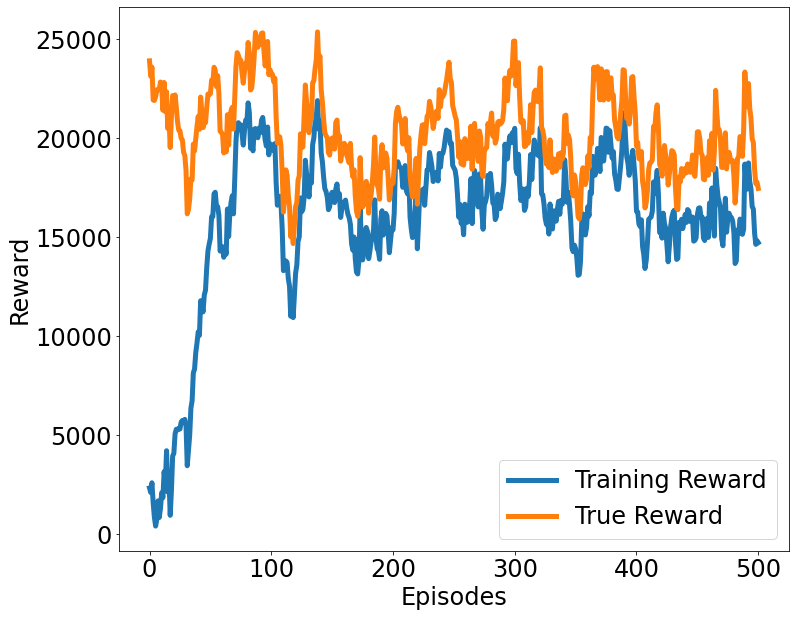

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo1.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo1.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_trend_high.eps', format='eps')
plt.savefig('ppo_training_trend_high.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


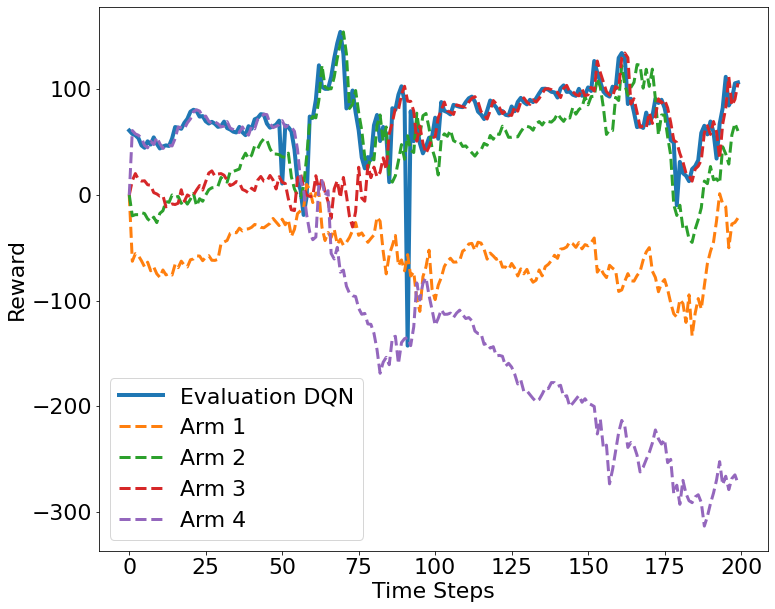

In [ ]:
episodes = 1
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env1 = fourarmedbandit(trend=True, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env1.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model1.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env1.e
      rew[i][e][:] = test_env1.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env1.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env1.step(action)
      optimal_reward[i][e] = test_env1.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100


linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 22})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation DQN', linewidth=linewidth)
# plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation PPO', linewidth=linewidth)
# plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
# plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with trend & high volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
# plt.show()
# plt.figure(figsize=(8,6))
for i in range(4):
  plt.plot(np.mean(rew[:,:,i], axis = 0), '--', label='Arm '+str(i+1), linewidth=3)
plt.legend()
plt.savefig('1game_dqn_evaluation_trend_high.eps', format='eps')
plt.savefig('1game_dqn_evaluation_trend_high.jpg', dpi=300)
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

# test_env1 = fourarmedbandit(trend=True, high=True, seed=0)
# dones = False
# for i in range(episodes):
#   obs = test_env1.reset()
#   dones = False
#   # optim = 0
#   while not dones:
#       action, _states = model_ppo1.predict(obs)
#       # opt = env.optm
#       # vstar = env.reward_space[opt]
#       e = test_env1.e
#       # rew[i][e][:] = test_env.rewards
#       # random_action = np.random.choice(4)
#       # random_rewards[i][e] = test_env.rewards[random_action]
#       obs, rewards_ppo[i][e], dones, info = test_env1.step(action)
#       # optimal_reward[i][e] = test_env.optm

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


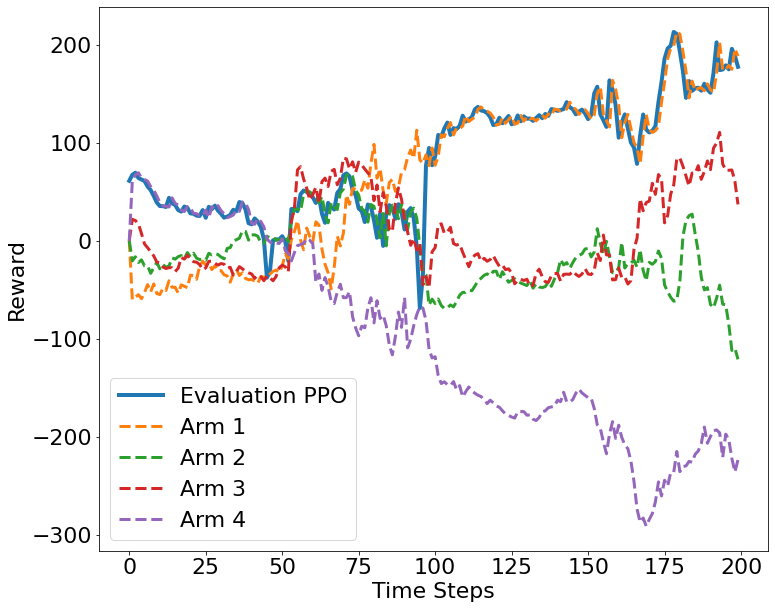

In [ ]:
episodes = 1
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env1 = fourarmedbandit(trend=True, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env1.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model_ppo1.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env1.e
      rew[i][e][:] = test_env1.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env1.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env1.step(action)
      optimal_reward[i][e] = test_env1.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100


linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 22})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation PPO', linewidth=linewidth)
# plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation PPO', linewidth=linewidth)
# plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
# plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with trend & high volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
# plt.show()
# plt.figure(figsize=(8,6))
for i in range(4):
  plt.plot(np.mean(rew[:,:,i], axis = 0), '--', label='Arm '+str(i+1), linewidth=3)
plt.legend()
plt.savefig('1game_ppo_evaluation_trend_high.eps', format='eps')
plt.savefig('1game_ppo_evaluation_trend_high.jpg', dpi=300)
plt.show()

In [ ]:
"""

Case 2: DQN env with trend=True and high=False

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
env_dqn2 = fourarmedbandit(seed=seed, trend = True, high=False)
env_dqn2.reset()
policy_kwargs = dict(net_arch=[400,300])
model2 = DQN('MlpPolicy', env_dqn2, verbose=2, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model2.learn(total_timesteps=int(200*500))
# Save the agent
model2.save("rmab2")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 1.39e+03 |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4301     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 43.6     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4376     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -672  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


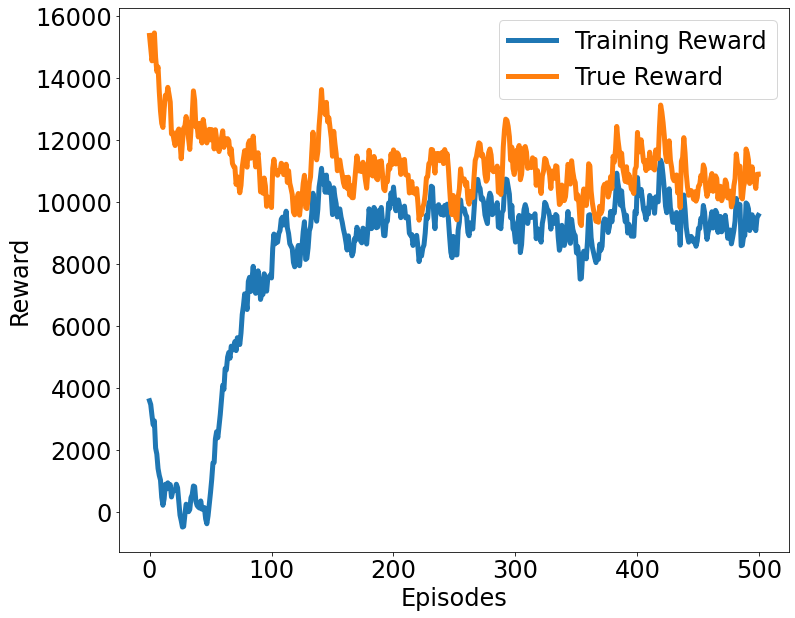

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn2.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn2.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_trend_low.eps', format='eps')
plt.savefig('dqn_training_trend_low.jpg', dpi=300)
plt.show()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo2 = fourarmedbandit(trend=True, high = False, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo2 = PPO("MlpPolicy", env_ppo2, verbose=2, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo2.learn(total_timesteps=200*500)
model_ppo2.save("ppo_rmab2")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -942     |
| time/              |          |
|    fps             | 526      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | 241        |
| time/                   |            |
|    fps                  | 329        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.13327686 |
|    clip_fraction        | 0.829      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


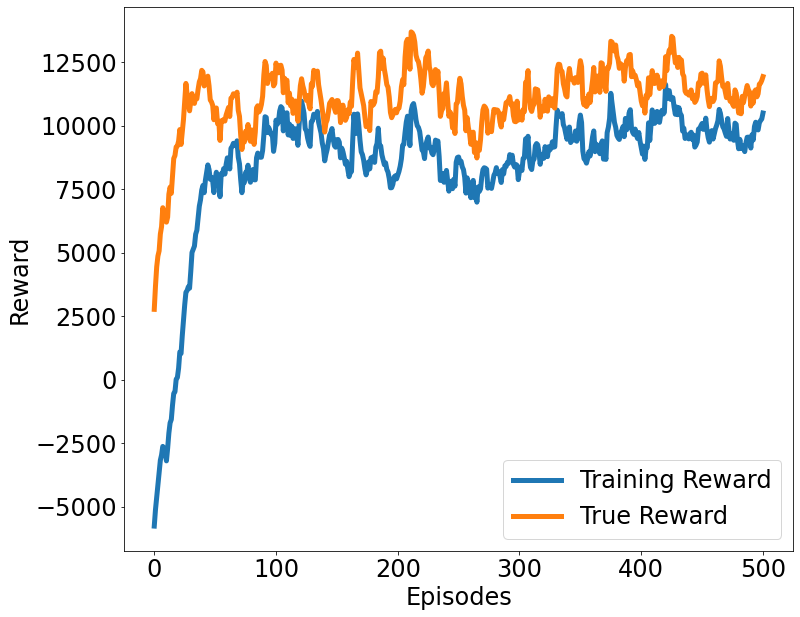

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo2.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo2.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_trend_low.eps', format='eps')
plt.savefig('ppo_training_trend_low.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


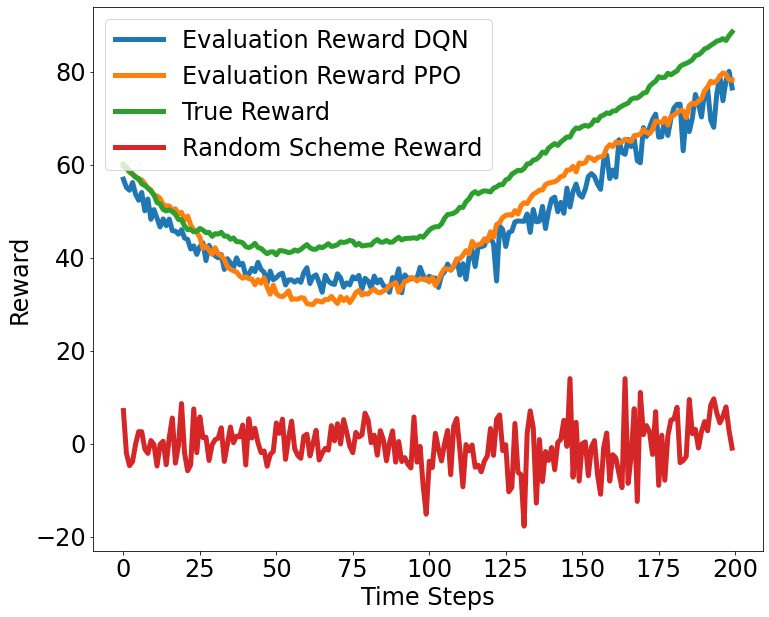

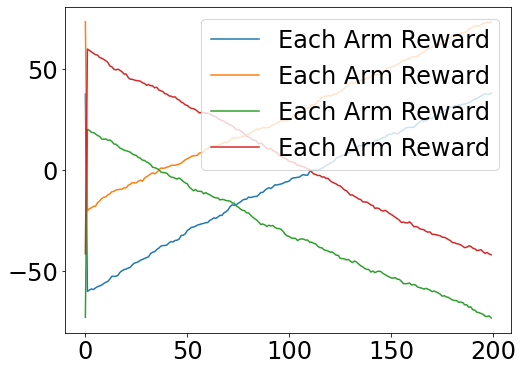

In [ ]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env2 = fourarmedbandit(trend=True, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env2.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model2.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env2.e
      rew[i][e][:] = test_env2.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env2.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env2.step(action)
      optimal_reward[i][e] = test_env2.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100

test_env2 = fourarmedbandit(trend=True, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env2.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo2.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env2.e
      # rew[i][e][:] = test_env.rewards
      # random_action = np.random.choice(4)
      # random_rewards[i][e] = test_env.rewards[random_action]
      obs, rewards_ppo[i][e], dones, info = test_env2.step(action)
      # optimal_reward[i][e] = test_env.optm
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with trend & low volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_trend_low.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_trend_low.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

In [ ]:
"""

Case 3: DQN env with trend=False and high=True

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
env_dqn3 = fourarmedbandit(seed=seed, trend = False, high=True)
env_dqn3.reset()
policy_kwargs = dict(net_arch=[400,300])
model3 = DQN('MlpPolicy', env_dqn3, verbose=2, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model3.learn(total_timesteps=int(200*500))
# Save the agent
model3.save("rmab3")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 4.91e+03 |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4199     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 4.73e+03 |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4238     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 2.8e+0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


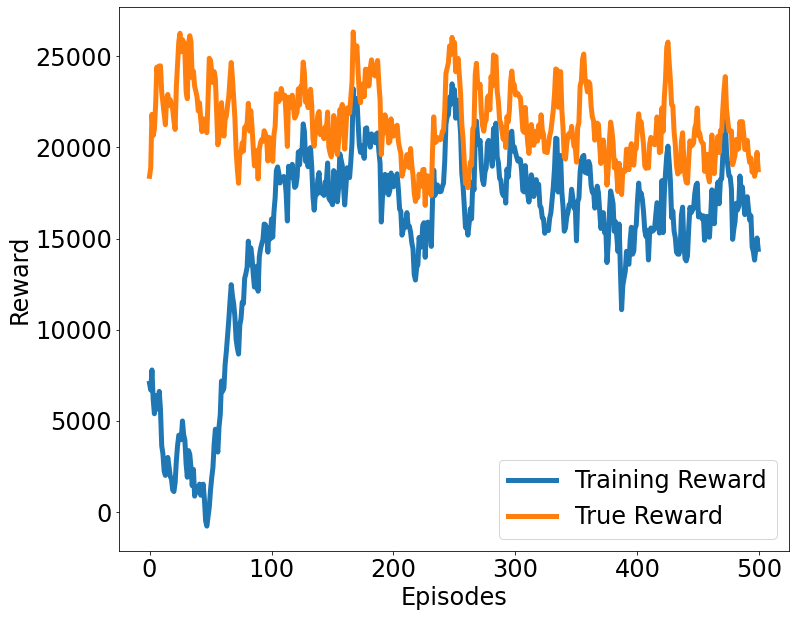

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn3.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn3.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with no trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_notrend_high.eps', format='eps')
plt.savefig('dqn_training_notrend_high.jpg', dpi=300)
plt.show()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo3 = fourarmedbandit(trend=False, high = True, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo3 = PPO("MlpPolicy", env_ppo3, verbose=2, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo3.learn(total_timesteps=200*500)
model_ppo3.save("ppo_rmab3")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -2.36e+03 |
| time/              |           |
|    fps             | 500       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | 357       |
| time/                   |           |
|    fps                  | 328       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.1177842 |
|    clip_fraction        | 0.768     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.28  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


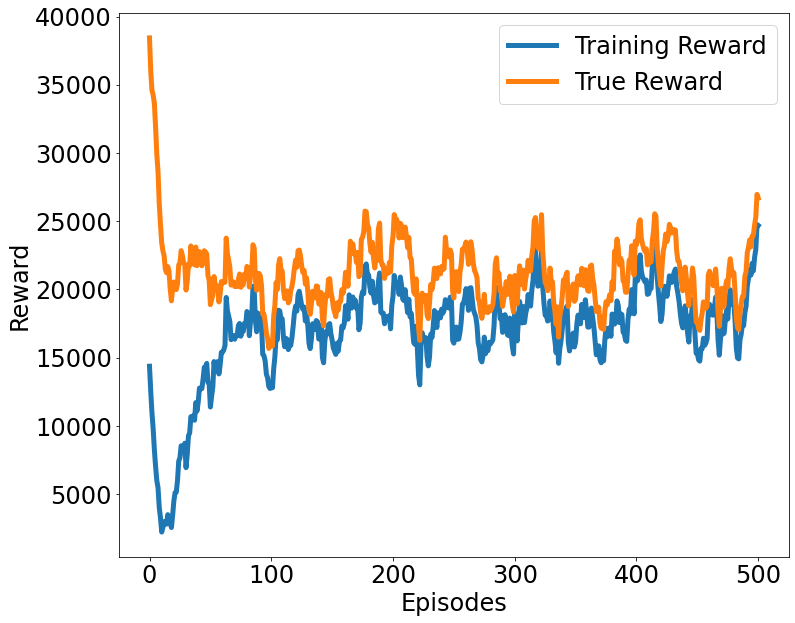

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo3.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo3.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with no trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_notrend_high.eps', format='eps')
plt.savefig('ppo_training_notrend_high.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


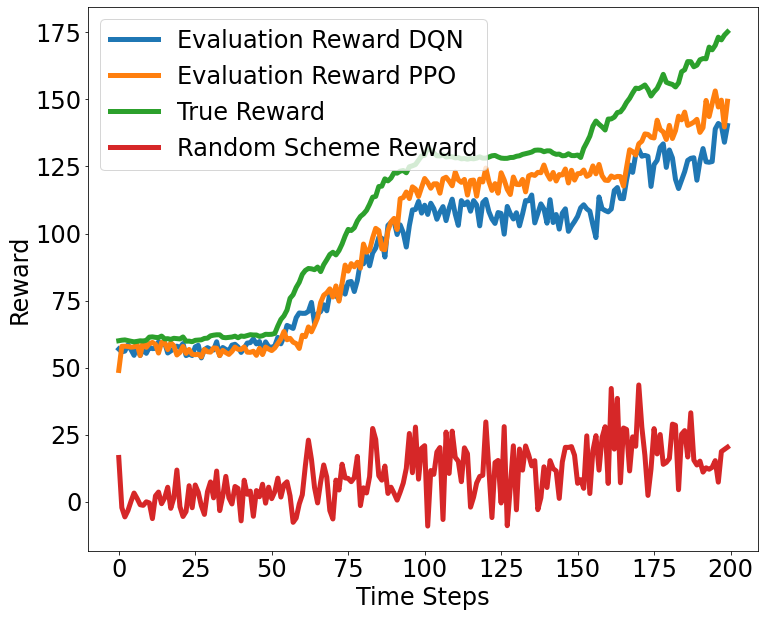

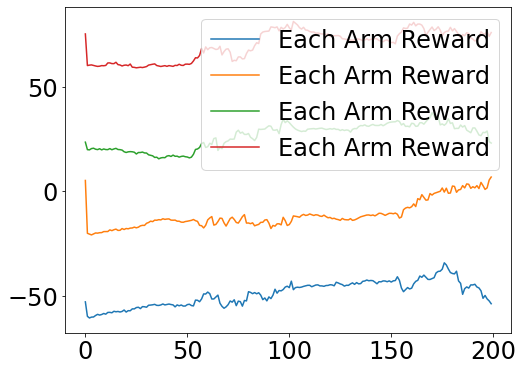

In [ ]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env3 = fourarmedbandit(trend=False, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env3.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model3.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env3.e
      rew[i][e][:] = test_env3.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env3.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env3.step(action)
      optimal_reward[i][e] = test_env3.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100

test_env3 = fourarmedbandit(trend=False, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env3.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo3.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env3.e
      # rew[i][e][:] = test_env.rewards
      # random_action = np.random.choice(4)
      # random_rewards[i][e] = test_env.rewards[random_action]
      obs, rewards_ppo[i][e], dones, info = test_env3.step(action)
      # optimal_reward[i][e] = test_env.optm
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with no trend & high volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_notrend_high.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_notrend_high.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

In [ ]:
"""

Case 4: DQN env with trend=False and high=False

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
env_dqn4 = fourarmedbandit(seed=seed, trend = False, high=False)
env_dqn4.reset()
policy_kwargs = dict(net_arch=[400,300])
model4 = DQN('MlpPolicy', env_dqn4, verbose=2, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model4.learn(total_timesteps=int(200*500))
# Save the agent
model4.save("rmab3")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    ep_rew_mean      | -1.77e+03 |
|    exploration_rate | 0.962     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 4011      |
|    time_elapsed     | 0         |
|    total_timesteps  | 800       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    ep_rew_mean      | -1.35e+03 |
|    exploration_rate | 0.924     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 4060      |
|    time_elapsed     | 0         |
|    total_timesteps  | 1600      |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


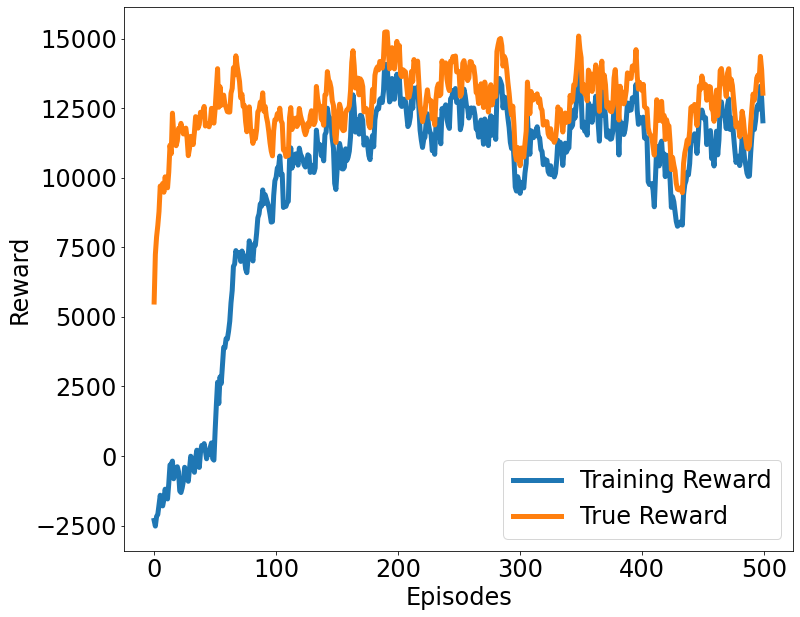

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn4.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn4.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with no trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_notrend_low.eps', format='eps')
plt.savefig('dqn_training_notrend_low.jpg', dpi=300)
plt.show()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo4 = fourarmedbandit(trend=False, high = False, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo4 = PPO("MlpPolicy", env_ppo4, verbose=2, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo4.learn(total_timesteps=200*500)
model_ppo4.save("ppo_rmab3")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -142     |
| time/              |          |
|    fps             | 534      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | 1.66e+03   |
| time/                   |            |
|    fps                  | 340        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.28108388 |
|    clip_fraction        | 0.838      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


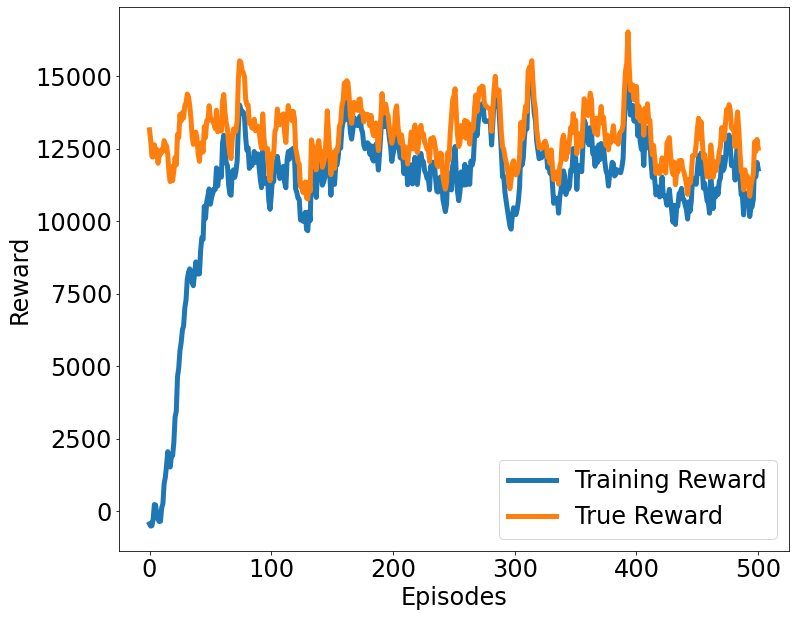

In [ ]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo4.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo4.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with no trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_notrend_low.eps', format='eps')
plt.savefig('ppo_training_notrend_low.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


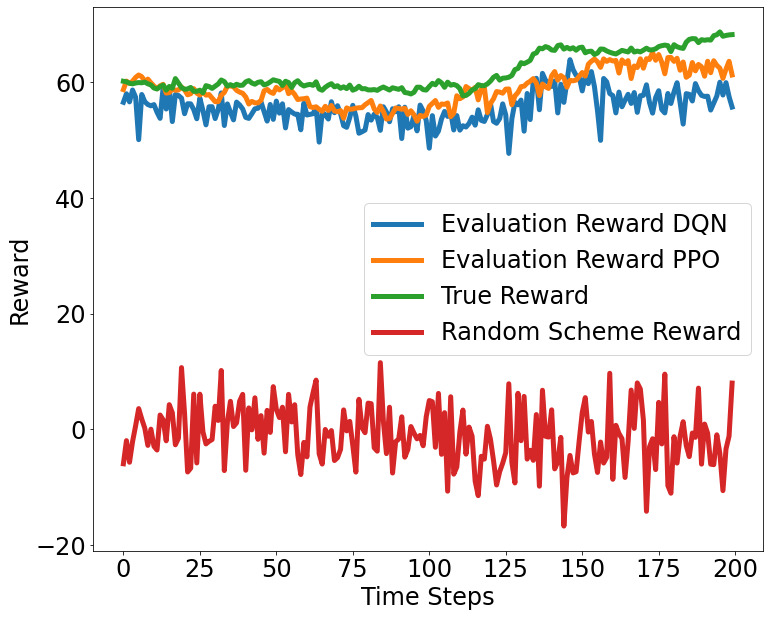

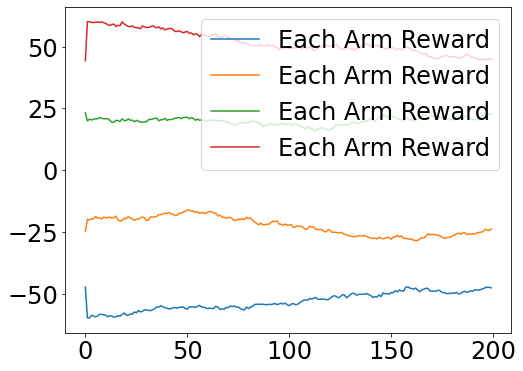

In [ ]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env4 = fourarmedbandit(trend=False, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env4.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model4.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env4.e
      rew[i][e][:] = test_env4.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env4.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env4.step(action)
      optimal_reward[i][e] = test_env4.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100

test_env4 = fourarmedbandit(trend=False, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env4.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo4.predict(obs)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = test_env4.e
      # rew[i][e][:] = test_env.rewards
      # random_action = np.random.choice(4)
      # random_rewards[i][e] = test_env.rewards[random_action]
      obs, rewards_ppo[i][e], dones, info = test_env4.step(action)
      # optimal_reward[i][e] = test_env.optm
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with no trend & low volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_notrend_low.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_notrend_low.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

In [ ]:
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines.deepq.policies import MlpPolicy
# from stable_baselines import DQN

# env = fourarmedbandit()
# eval_env = fourarmedbandit()
# policy_kwargs = dict(layers=[200,200])
# model = DQN(MlpPolicy, env, verbose=2, gamma=0, exploration_fraction=0.5, param_noise=True, policy_kwargs=policy_kwargs)
# model.learn(total_timesteps = 200*100)
# model.save("rmab")


In [ ]:
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env = fourarmedbandit(trend=False, high = True)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model = PPO("MlpPolicy", env, verbose=2, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model.learn(total_timesteps=200*500)
model.save("ppo_rmab")

# del model # remove to demonstrate saving and loading

# model = PPO.load("ppo_rmab")

# obs = env.reset()
# while True:
#     action, _states = model.predict(obs)
#     obs, rewards, dones, info = env.step(action)
    # env.render()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -2.61e+03 |
| time/              |           |
|    fps             | 1275      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 200       |
|    ep_rew_mean          | 3.37e+03  |
| time/                   |           |
|    fps                  | 542       |
|    iterations           | 2         |
|    time_elapsed         | 7         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0809754 |
|    clip_fraction        | 0.791     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.31   

In [ ]:
def numpy_ewma_vectorized_v2(data, window):

  alpha = 2 /(window + 1.0)
  alpha_rev = 1-alpha
  n = data.shape[0]

  pows = alpha_rev**(np.arange(n+1))

  scale_arr = 1/pows[:-1]
  offset = data[0]*pows[1:]
  pw0 = alpha*alpha_rev**(n-1)

  mult = data*pw0*scale_arr
  cumsums = mult.cumsum()
  out = offset + cumsums*scale_arr[::-1]
  return out

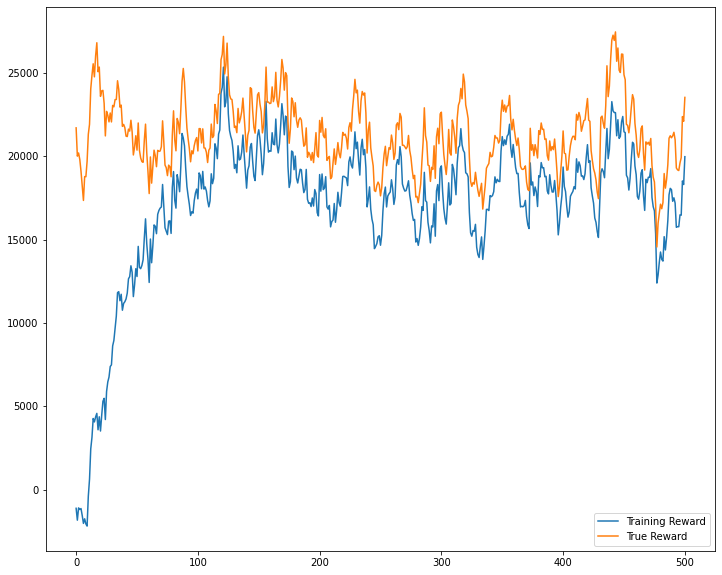

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.plot(numpy_ewma_vectorized_v2(np.array(env.reward_history), 20), label='Training Reward')
plt.plot(numpy_ewma_vectorized_v2(np.array(env.optimal_history), 20), label='True Reward')
plt.legend()
plt.show()

In [ ]:
episodes = 1
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
env = fourarmedbandit(trend=True, high=True)
obs = env.reset()
dones = False
for i in range(episodes):
  obs = env.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model.predict(obs)
      print(action)
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = env.e
      rew[i][e][:] = env.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = env.rewards[random_action]
      obs, rewards[i][e], dones, info = env.step(action)
      optimal_reward[i][e] = env.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100


plt.figure(figsize=(8,6))
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward')
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward')
# plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme')
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

In [ ]:
print(rewards[0])
print(optimal_reward[0])

In [ ]:
!pip install Box2D

     |████████████████████████████████| 1.3 MB 2.1 MB/s 


In [ ]:
# restart kernel

In [ ]:
# """
# DQN from here
# """


# import gym
# import numpy as np
# from gym import spaces
# from gym.utils import seeding
# from PIL import Image
# import cv2
# import matplotlib.pyplot as plt 
# initial_mu_values = [-60, -20, 20, 60]
# class fourarmedbandit(gym.Env):
#     def __init__(self, trend = True, high = False, seed=0):
#         super(fourarmedbandit, self).__init__()
#         np.random.seed(seed)
    
#         self.trend = trend
#         self.high = high
#         self.e = 0
#         self.trend_val = 0.5*np.array([1, 1, -1, -1])
#         reward = np.zeros(4)
#         self.lamda = 0.999
#         self.sigma_ex = 2
#         self.unex_high = 16
#         self.unex_low = 4
#         reward[0] = initial_mu_values[0]
#         reward[1] = initial_mu_values[1]
#         reward[2] = initial_mu_values[2]
#         reward[3] = initial_mu_values[3]
#         self.reward_space = reward
#         self.length = 4
#         self.action_space = spaces.Discrete(self.length)
#         self.observation_space = spaces.Box(low=-np.inf, 
#                                      high=np.inf, shape = (4,4), dtype=np.float32)
#         self.score = 0
#         self.length = 4
#         self._seed()
#         self.agent_position = 4
#         self.state = np.zeros((4,4))
#         self.optm = 3

#         self.episode_reward_history = []
#         self.reward_history = []

#         self.episode_optimal_history = []
#         self.optimal_history = []
#         self.rewards = np.zeros((4))

#     def _seed(self, seed = None):
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]
    
#     def step(self, action, rend = False, rng = np.random.RandomState(1111)):
#         reward = 0
#         if rend:
#             self.render(reward)

#         self.rewards = rng.normal(self.reward_space, self.sigma_ex)
#         reward = self.rewards[action]
#         self.optm = np.max(self.rewards)
#         optimal_action = np.argmax(self.rewards)
#         self.score += reward
#         if rend:
#             self.render(reward, a = action)
#         var = self.unex_low
#         if ( self.high & (((self.e<=100) & (self.e>50)) | ((self.e<=200) & (self.e>150))) ):
#             var = self.unex_high
#         self.reward_space = self.lamda * self.reward_space + rng.normal(0, var, size = (4))
#         if self.trend:
#             self.reward_space += self.trend_val
#         self.e += 1
#         done = False
#         self.episode_reward_history.append(reward)
#         self.episode_optimal_history.append(self.optm)
#         if self.e == 200:
#             done = True
#             self.reward_history.append(np.sum(self.episode_reward_history))
#             self.optimal_history.append(np.sum(self.episode_optimal_history))
#             self.episode_reward_history = []
#             self.episode_optimal_history = []

#         temp = self.state[action].tolist()
#         temp.pop(0)
#         temp.append(reward)
#         self.state[action] = np.array(temp)

#         # print(f'  Step: {self.e} || Reward: {reward} || Action: {action} || Optimal: {optimal_action}')

#         return self.state, reward, done, {}

#     def reset(self):
        
#         self.e = 0
#         self.score = 0
#         reward = np.zeros(4)
#         reward[0] = initial_mu_values[0]
#         reward[1] = initial_mu_values[1]
#         reward[2] = initial_mu_values[2]
#         reward[3] = initial_mu_values[3]
#         self.reward_space = reward
#         self.agent_position = 4
#         self.state = np.zeros((4,4))
#         self.optm = 3
#         return self.state

#     def render(self, r, a = -1):
#         pass
      

In [ ]:
import torch as T 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np
import gym 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class DeepQNetwork(nn.Module): # every class that extends the functionality of a neural network derives from nn.Module, to get things like backprop and all
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims 
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims) # * means we can pass a list as in CNN like 3 rgb layers
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions


In [ ]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, 
                max_mem_size = 100000, eps_end=0.01, eps_dec=5e-5):
        self.gamma = gamma
        self.epsilon = epsilon 
        self.eps_min = eps_end 
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(lr = self.lr, n_actions=n_actions, input_dims = input_dims, 
                                    fc1_dims=400, fc2_dims=300)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        #find index of first unoccupied memory index
        index = self.mem_cntr % self.mem_size # wraps around
        self.state_memory[index] = state 
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.normal() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return 
        
        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)
      
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch] # dereferncing to get values of the actions we actually took
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0] # [0] because it returns a (value, index) tuple
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [ ]:
if __name__=='__main__':
    SEED = 0
    env = fourarmedbandit(seed=SEED, trend=True, high=True)
    # env._seed(SEED)
    eval_env = fourarmedbandit(seed=SEED, trend=True, high=True)
    # eval_env._seed(SEED)

    np.random.seed(SEED)
    T.manual_seed(SEED)

    agent = Agent(gamma=0, epsilon=1.0, batch_size=32, n_actions=4, 
                eps_end=0.01, input_dims=[4*memory_len], lr=0.01)
    scores, eps_history = [], []
    eval_scores = []
    optimal_training_scores = []
    optimal_evaluation_scores = []
    n_games = 1000 

    # for i in range(n_games):
    for i in tqdm(range(n_games),ascii=True, unit="episode"):
        # if i==500:
        #   agent.epsilon = 1.0
        score = 0
        optimal_score = 0
        done = False 
        observation = env.reset()
        observation = observation.flatten()
        # observation = [float(i) for i in observation]
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            observation_ = observation_.flatten()
            score += reward 
            optimal_score += env.optm
            agent.store_transition(observation, action, reward, 
                            observation_, done)

            agent.learn()
            observation = observation_
        scores.append(score)
        optimal_training_scores.append(optimal_score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])

        print()
        print('Training: ', 'episode ', i, 'optimal score %.2f' % optimal_score, 'score %.2f' % score, 
                'average score %.2f' % avg_score, 
                'epsilon %.2f' % agent.epsilon)

        # Evaluation
        eval_env.set_seed(SEED)
        # eval_env.__init__()
        observation = eval_env.reset()
        observation = observation.flatten()
        eval_score = 0
        optimal_score = 0
        done = False
        while not done:
          state = T.tensor([observation]).to(agent.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
          actions = agent.Q_eval.forward(state)
          action = T.argmax(actions).item()
          observation_, reward, done, info = eval_env.step(action)
          observation_ = observation_.flatten()
          eval_score += reward 
          optimal_score += eval_env.optm
          observation = observation_
        eval_scores.append(eval_score)
        optimal_evaluation_scores.append(optimal_score)
        avg_score = np.mean(eval_scores[-100:])
        print('Evaluation: ', 'episode ', i, 'optimal score %.2f' % optimal_score, 'score %.2f' % eval_score, 
                'average score %.2f' % avg_score, 
                'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    

  0%|          | 1/1000 [00:01<17:26,  1.05s/episode]


Training:  episode  0 optimal score 27400.03 score 11961.09 average score 11961.09 epsilon 0.99
Evaluation:  episode  0 optimal score 1734.78 score -1368.74 average score -1368.74 epsilon 0.99


  0%|          | 2/1000 [00:01<14:55,  1.11episode/s]


Training:  episode  1 optimal score 19885.73 score 6993.04 average score 9477.07 epsilon 0.98
Evaluation:  episode  1 optimal score 12202.96 score -13751.06 average score -7559.90 epsilon 0.98


  0%|          | 3/1000 [00:02<14:03,  1.18episode/s]


Training:  episode  2 optimal score 14373.55 score -2252.80 average score 5567.11 epsilon 0.97
Evaluation:  episode  2 optimal score 23233.44 score -19059.44 average score -11393.08 epsilon 0.97


  0%|          | 4/1000 [00:03<14:01,  1.18episode/s]


Training:  episode  3 optimal score 36696.30 score 11235.48 average score 6984.20 epsilon 0.96
Evaluation:  episode  3 optimal score 17800.81 score 14209.03 average score -4992.55 epsilon 0.96


  0%|          | 5/1000 [00:04<15:59,  1.04episode/s]


Training:  episode  4 optimal score 6784.44 score -6557.37 average score 4275.89 epsilon 0.95
Evaluation:  episode  4 optimal score 21011.00 score 17499.04 average score -494.23 epsilon 0.95


  1%|          | 6/1000 [00:05<17:02,  1.03s/episode]


Training:  episode  5 optimal score 41357.69 score 14207.67 average score 5931.18 epsilon 0.94
Evaluation:  episode  5 optimal score 6498.40 score -3915.66 average score -1064.47 epsilon 0.94


  1%|          | 7/1000 [00:07<17:59,  1.09s/episode]


Training:  episode  6 optimal score 12062.27 score 1491.79 average score 5296.99 epsilon 0.93
Evaluation:  episode  6 optimal score 21714.42 score 12016.83 average score 804.29 epsilon 0.93


  1%|          | 8/1000 [00:08<18:48,  1.14s/episode]


Training:  episode  7 optimal score 18483.02 score 1842.89 average score 4865.22 epsilon 0.92
Evaluation:  episode  7 optimal score 31384.94 score 18808.69 average score 3054.84 epsilon 0.92


  1%|          | 9/1000 [00:09<19:02,  1.15s/episode]


Training:  episode  8 optimal score 20656.64 score 3901.87 average score 4758.18 epsilon 0.91
Evaluation:  episode  8 optimal score 30442.68 score -21451.45 average score 331.92 epsilon 0.91


  1%|1         | 10/1000 [00:10<18:58,  1.15s/episode]


Training:  episode  9 optimal score 5540.49 score -1179.61 average score 4164.41 epsilon 0.90
Evaluation:  episode  9 optimal score 2216.34 score -28316.15 average score -2532.89 epsilon 0.90


  1%|1         | 11/1000 [00:11<19:04,  1.16s/episode]


Training:  episode  10 optimal score 8904.47 score -7915.35 average score 3066.25 epsilon 0.89
Evaluation:  episode  10 optimal score 38817.12 score 19420.84 average score -537.10 epsilon 0.89


  1%|1         | 12/1000 [00:12<19:15,  1.17s/episode]


Training:  episode  11 optimal score 17423.69 score -511.68 average score 2768.08 epsilon 0.88
Evaluation:  episode  11 optimal score 17170.37 score -10499.39 average score -1367.29 epsilon 0.88


  1%|1         | 13/1000 [00:14<19:03,  1.16s/episode]


Training:  episode  12 optimal score 26980.35 score 13344.56 average score 3581.66 epsilon 0.87
Evaluation:  episode  12 optimal score 22523.65 score 13184.44 average score -247.92 epsilon 0.87


  1%|1         | 14/1000 [00:15<19:10,  1.17s/episode]


Training:  episode  13 optimal score 32840.03 score 17466.30 average score 4573.42 epsilon 0.86
Evaluation:  episode  13 optimal score 9466.70 score -5983.26 average score -657.59 epsilon 0.86


  2%|1         | 15/1000 [00:16<19:01,  1.16s/episode]


Training:  episode  14 optimal score 13069.32 score -6874.69 average score 3810.21 epsilon 0.85
Evaluation:  episode  14 optimal score 10229.54 score 8451.53 average score -50.32 epsilon 0.85


  2%|1         | 16/1000 [00:17<19:03,  1.16s/episode]


Training:  episode  15 optimal score 47668.58 score 21678.53 average score 4926.98 epsilon 0.84
Evaluation:  episode  15 optimal score 18710.17 score 18012.33 average score 1078.60 epsilon 0.84


  2%|1         | 17/1000 [00:18<19:14,  1.17s/episode]


Training:  episode  16 optimal score 13353.84 score -1940.08 average score 4523.04 epsilon 0.83
Evaluation:  episode  16 optimal score 15959.76 score -3275.17 average score 822.49 epsilon 0.83


  2%|1         | 18/1000 [00:19<19:08,  1.17s/episode]


Training:  episode  17 optimal score 12730.99 score -4718.45 average score 4009.62 epsilon 0.82
Evaluation:  episode  17 optimal score 22035.54 score 8461.19 average score 1246.87 epsilon 0.82


  2%|1         | 19/1000 [00:21<19:17,  1.18s/episode]


Training:  episode  18 optimal score 15933.26 score 505.75 average score 3825.21 epsilon 0.81
Evaluation:  episode  18 optimal score 47978.23 score -10661.76 average score 620.10 epsilon 0.81


  2%|2         | 20/1000 [00:22<19:23,  1.19s/episode]


Training:  episode  19 optimal score 15494.84 score -5228.08 average score 3372.54 epsilon 0.80
Evaluation:  episode  19 optimal score -5408.68 score -10347.23 average score 71.73 epsilon 0.80


  2%|2         | 21/1000 [00:23<19:47,  1.21s/episode]


Training:  episode  20 optimal score 21360.60 score 8761.61 average score 3629.17 epsilon 0.79
Evaluation:  episode  20 optimal score 38010.70 score 6810.74 average score 392.64 epsilon 0.79


  2%|2         | 22/1000 [00:24<19:45,  1.21s/episode]


Training:  episode  21 optimal score 27763.19 score 8198.69 average score 3836.87 epsilon 0.78
Evaluation:  episode  21 optimal score 34234.24 score 26487.59 average score 1578.77 epsilon 0.78


  2%|2         | 23/1000 [00:26<19:37,  1.20s/episode]


Training:  episode  22 optimal score 30889.47 score 7781.46 average score 4008.38 epsilon 0.77
Evaluation:  episode  22 optimal score 12827.79 score 12359.49 average score 2047.50 epsilon 0.77


  2%|2         | 24/1000 [00:27<19:34,  1.20s/episode]


Training:  episode  23 optimal score 31367.21 score 11206.07 average score 4308.28 epsilon 0.76
Evaluation:  episode  23 optimal score 43995.96 score 42575.95 average score 3736.18 epsilon 0.76


  2%|2         | 25/1000 [00:28<19:47,  1.22s/episode]


Training:  episode  24 optimal score 20863.18 score 469.93 average score 4154.74 epsilon 0.75
Evaluation:  episode  24 optimal score 27205.30 score 18583.41 average score 4330.07 epsilon 0.75


  3%|2         | 26/1000 [00:29<19:39,  1.21s/episode]


Training:  episode  25 optimal score 20292.32 score 3051.79 average score 4112.32 epsilon 0.74
Evaluation:  episode  25 optimal score 18655.19 score 15167.08 average score 4746.88 epsilon 0.74


  3%|2         | 27/1000 [00:30<19:31,  1.20s/episode]


Training:  episode  26 optimal score 32078.99 score 11472.66 average score 4384.93 epsilon 0.73
Evaluation:  episode  26 optimal score 13966.59 score 10445.91 average score 4957.95 epsilon 0.73


  3%|2         | 28/1000 [00:32<19:43,  1.22s/episode]


Training:  episode  27 optimal score 35838.10 score 12043.90 average score 4658.46 epsilon 0.72
Evaluation:  episode  27 optimal score 12086.87 score 10328.09 average score 5149.75 epsilon 0.72


  3%|2         | 29/1000 [00:33<19:39,  1.21s/episode]


Training:  episode  28 optimal score 7491.73 score -12272.99 average score 4074.62 epsilon 0.71
Evaluation:  episode  28 optimal score 20575.20 score 9673.44 average score 5305.74 epsilon 0.71


  3%|3         | 30/1000 [00:34<19:29,  1.21s/episode]


Training:  episode  29 optimal score 19625.55 score 2668.12 average score 4027.74 epsilon 0.70
Evaluation:  episode  29 optimal score 5319.54 score -21123.11 average score 4424.77 epsilon 0.70


  3%|3         | 31/1000 [00:35<19:21,  1.20s/episode]


Training:  episode  30 optimal score 6545.29 score -1128.26 average score 3861.41 epsilon 0.69
Evaluation:  episode  30 optimal score 10717.03 score -22928.59 average score 3542.41 epsilon 0.69


  3%|3         | 32/1000 [00:36<19:20,  1.20s/episode]


Training:  episode  31 optimal score 265.58 score -12735.23 average score 3342.77 epsilon 0.68
Evaluation:  episode  31 optimal score 10883.77 score 10159.66 average score 3749.20 epsilon 0.68


  3%|3         | 33/1000 [00:38<19:26,  1.21s/episode]


Training:  episode  32 optimal score 21658.50 score -990.95 average score 3211.44 epsilon 0.67
Evaluation:  episode  32 optimal score 5888.99 score 4036.43 average score 3757.90 epsilon 0.67


  3%|3         | 34/1000 [00:39<19:19,  1.20s/episode]


Training:  episode  33 optimal score 21968.52 score 8305.68 average score 3361.27 epsilon 0.66
Evaluation:  episode  33 optimal score 39617.09 score 16260.20 average score 4125.61 epsilon 0.66


  4%|3         | 35/1000 [00:40<19:13,  1.20s/episode]


Training:  episode  34 optimal score 33030.49 score 12467.98 average score 3621.47 epsilon 0.65
Evaluation:  episode  34 optimal score 5422.42 score 1731.41 average score 4057.21 epsilon 0.65


  4%|3         | 36/1000 [00:41<19:05,  1.19s/episode]


Training:  episode  35 optimal score 31377.69 score 11292.88 average score 3834.56 epsilon 0.64
Evaluation:  episode  35 optimal score 21682.73 score 20160.27 average score 4504.52 epsilon 0.64


  4%|3         | 37/1000 [00:42<19:22,  1.21s/episode]


Training:  episode  36 optimal score 16755.38 score -99.70 average score 3728.23 epsilon 0.63
Evaluation:  episode  36 optimal score 30286.32 score 12672.51 average score 4725.27 epsilon 0.63


  4%|3         | 38/1000 [00:44<19:04,  1.19s/episode]


Training:  episode  37 optimal score 18468.23 score 7351.87 average score 3823.59 epsilon 0.62
Evaluation:  episode  37 optimal score 7948.52 score 4395.55 average score 4716.60 epsilon 0.62


  4%|3         | 39/1000 [00:45<19:15,  1.20s/episode]


Training:  episode  38 optimal score 33866.52 score 14365.23 average score 4093.89 epsilon 0.61
Evaluation:  episode  38 optimal score 8803.08 score 3959.85 average score 4697.19 epsilon 0.61


  4%|4         | 40/1000 [00:46<19:20,  1.21s/episode]


Training:  episode  39 optimal score 27191.30 score 7421.13 average score 4177.07 epsilon 0.60
Evaluation:  episode  39 optimal score 23760.03 score 18718.94 average score 5047.74 epsilon 0.60


  4%|4         | 41/1000 [00:47<19:17,  1.21s/episode]


Training:  episode  40 optimal score 47725.21 score 1768.49 average score 4118.32 epsilon 0.59
Evaluation:  episode  40 optimal score 7672.12 score 5155.55 average score 5050.37 epsilon 0.59


  4%|4         | 42/1000 [00:48<19:05,  1.20s/episode]


Training:  episode  41 optimal score 25672.04 score 12693.77 average score 4322.50 epsilon 0.58
Evaluation:  episode  41 optimal score 10929.57 score 4247.00 average score 5031.24 epsilon 0.58


  4%|4         | 43/1000 [00:50<18:57,  1.19s/episode]


Training:  episode  42 optimal score 5704.51 score -13811.94 average score 3900.77 epsilon 0.57
Evaluation:  episode  42 optimal score 13664.31 score 12557.36 average score 5206.26 epsilon 0.57


  4%|4         | 44/1000 [00:51<18:53,  1.19s/episode]


Training:  episode  43 optimal score 25583.09 score 12783.41 average score 4102.65 epsilon 0.56
Evaluation:  episode  43 optimal score 18537.92 score 8339.25 average score 5277.47 epsilon 0.56


  4%|4         | 45/1000 [00:52<19:16,  1.21s/episode]


Training:  episode  44 optimal score 30806.72 score 9021.22 average score 4211.95 epsilon 0.55
Evaluation:  episode  44 optimal score 34028.69 score 18889.68 average score 5579.96 epsilon 0.55


  5%|4         | 46/1000 [00:53<19:12,  1.21s/episode]


Training:  episode  45 optimal score 11924.73 score -5720.74 average score 3996.02 epsilon 0.54
Evaluation:  episode  45 optimal score 23926.08 score -14507.58 average score 5143.28 epsilon 0.54


  5%|4         | 47/1000 [00:54<19:11,  1.21s/episode]


Training:  episode  46 optimal score 30442.25 score 16456.61 average score 4261.14 epsilon 0.53
Evaluation:  episode  46 optimal score 27637.78 score 27637.78 average score 5621.88 epsilon 0.53


  5%|4         | 48/1000 [00:56<19:00,  1.20s/episode]


Training:  episode  47 optimal score 13272.22 score -2184.28 average score 4126.86 epsilon 0.52
Evaluation:  episode  47 optimal score 16343.11 score 10137.29 average score 5715.95 epsilon 0.52


  5%|4         | 49/1000 [00:57<19:05,  1.20s/episode]


Training:  episode  48 optimal score 834.72 score -13652.17 average score 3764.02 epsilon 0.51
Evaluation:  episode  48 optimal score 23675.16 score 12263.76 average score 5849.58 epsilon 0.51


  5%|5         | 50/1000 [00:58<19:07,  1.21s/episode]


Training:  episode  49 optimal score 14988.85 score 910.33 average score 3706.95 epsilon 0.50
Evaluation:  episode  49 optimal score 18813.08 score 14311.42 average score 6018.82 epsilon 0.50


  5%|5         | 51/1000 [00:59<19:03,  1.20s/episode]


Training:  episode  50 optimal score 29499.87 score 582.79 average score 3645.69 epsilon 0.49
Evaluation:  episode  50 optimal score 23586.10 score 8581.48 average score 6069.07 epsilon 0.49


  5%|5         | 52/1000 [01:00<18:59,  1.20s/episode]


Training:  episode  51 optimal score 25805.09 score 5978.28 average score 3690.55 epsilon 0.48
Evaluation:  episode  51 optimal score 20815.81 score 19278.03 average score 6323.09 epsilon 0.48


  5%|5         | 53/1000 [01:02<19:15,  1.22s/episode]


Training:  episode  52 optimal score 12701.80 score 233.53 average score 3625.32 epsilon 0.47
Evaluation:  episode  52 optimal score 41857.22 score 8141.40 average score 6357.39 epsilon 0.47


  5%|5         | 54/1000 [01:03<19:12,  1.22s/episode]


Training:  episode  53 optimal score 29648.22 score 10738.32 average score 3757.04 epsilon 0.46
Evaluation:  episode  53 optimal score 34130.99 score 19943.15 average score 6608.98 epsilon 0.46


  6%|5         | 55/1000 [01:04<19:13,  1.22s/episode]


Training:  episode  54 optimal score 8024.74 score -3409.71 average score 3626.74 epsilon 0.45
Evaluation:  episode  54 optimal score 14764.04 score 8649.24 average score 6646.08 epsilon 0.45


  6%|5         | 56/1000 [01:05<19:02,  1.21s/episode]


Training:  episode  55 optimal score 26946.26 score 6221.74 average score 3673.08 epsilon 0.44
Evaluation:  episode  55 optimal score 16750.01 score 5383.78 average score 6623.54 epsilon 0.44


  6%|5         | 57/1000 [01:06<18:55,  1.20s/episode]


Training:  episode  56 optimal score 21819.20 score 6162.10 average score 3716.75 epsilon 0.43
Evaluation:  episode  56 optimal score 11589.69 score 4228.57 average score 6581.52 epsilon 0.43


  6%|5         | 58/1000 [01:08<19:04,  1.22s/episode]


Training:  episode  57 optimal score 34911.86 score 17176.68 average score 3948.81 epsilon 0.42
Evaluation:  episode  57 optimal score 26513.52 score 21362.53 average score 6836.36 epsilon 0.42


  6%|5         | 59/1000 [01:09<19:00,  1.21s/episode]


Training:  episode  58 optimal score 31887.05 score 15627.29 average score 4146.75 epsilon 0.41
Evaluation:  episode  58 optimal score 16827.33 score 10230.95 average score 6893.90 epsilon 0.41


  6%|6         | 60/1000 [01:10<18:43,  1.19s/episode]


Training:  episode  59 optimal score 52321.47 score 27677.34 average score 4538.93 epsilon 0.40
Evaluation:  episode  59 optimal score 13185.38 score 12224.18 average score 6982.74 epsilon 0.40


  6%|6         | 61/1000 [01:11<18:57,  1.21s/episode]


Training:  episode  60 optimal score 20928.64 score 5033.21 average score 4547.03 epsilon 0.39
Evaluation:  episode  60 optimal score 12935.35 score 9132.34 average score 7017.98 epsilon 0.39


  6%|6         | 62/1000 [01:13<19:04,  1.22s/episode]


Training:  episode  61 optimal score 21547.84 score 7794.95 average score 4599.42 epsilon 0.38
Evaluation:  episode  61 optimal score -1417.24 score -5152.21 average score 6821.68 epsilon 0.38


  6%|6         | 63/1000 [01:14<19:05,  1.22s/episode]


Training:  episode  62 optimal score 6119.70 score -8319.66 average score 4394.35 epsilon 0.37
Evaluation:  episode  62 optimal score 14823.13 score 14112.64 average score 6937.41 epsilon 0.37


  6%|6         | 64/1000 [01:15<18:59,  1.22s/episode]


Training:  episode  63 optimal score 17051.60 score 5724.91 average score 4415.14 epsilon 0.36
Evaluation:  episode  63 optimal score 27677.67 score 27669.01 average score 7261.34 epsilon 0.36


  6%|6         | 65/1000 [01:16<18:58,  1.22s/episode]


Training:  episode  64 optimal score 36598.89 score 20677.33 average score 4665.33 epsilon 0.35
Evaluation:  episode  64 optimal score 36010.83 score 34169.61 average score 7675.32 epsilon 0.35


  7%|6         | 66/1000 [01:17<18:57,  1.22s/episode]


Training:  episode  65 optimal score 22912.84 score 13077.48 average score 4792.79 epsilon 0.34
Evaluation:  episode  65 optimal score 9763.62 score 7508.69 average score 7672.79 epsilon 0.34


  7%|6         | 67/1000 [01:19<18:56,  1.22s/episode]


Training:  episode  66 optimal score 31261.62 score 14778.79 average score 4941.83 epsilon 0.33
Evaluation:  episode  66 optimal score 16381.67 score 14331.00 average score 7772.17 epsilon 0.33


  7%|6         | 68/1000 [01:20<19:00,  1.22s/episode]


Training:  episode  67 optimal score 22729.01 score 2538.94 average score 4906.50 epsilon 0.32
Evaluation:  episode  67 optimal score 2442.23 score -4183.57 average score 7596.35 epsilon 0.32


  7%|6         | 69/1000 [01:21<19:07,  1.23s/episode]


Training:  episode  68 optimal score 23357.94 score 8931.88 average score 4964.83 epsilon 0.31
Evaluation:  episode  68 optimal score 27912.31 score 5231.74 average score 7562.08 epsilon 0.31


  7%|7         | 70/1000 [01:22<19:12,  1.24s/episode]


Training:  episode  69 optimal score 18011.33 score 8241.85 average score 5011.65 epsilon 0.30
Evaluation:  episode  69 optimal score 18613.38 score 12554.49 average score 7633.40 epsilon 0.30


  7%|7         | 71/1000 [01:24<18:56,  1.22s/episode]


Training:  episode  70 optimal score 28040.69 score 8728.64 average score 5064.00 epsilon 0.29
Evaluation:  episode  70 optimal score 15708.80 score 11636.45 average score 7689.78 epsilon 0.29


  7%|7         | 72/1000 [01:25<19:00,  1.23s/episode]


Training:  episode  71 optimal score 29535.73 score 18411.05 average score 5249.38 epsilon 0.28
Evaluation:  episode  71 optimal score 1417.99 score -897.40 average score 7570.51 epsilon 0.28


  7%|7         | 73/1000 [01:26<18:52,  1.22s/episode]


Training:  episode  72 optimal score 7404.79 score -10231.39 average score 5037.31 epsilon 0.27
Evaluation:  episode  72 optimal score 22333.93 score 13537.90 average score 7652.26 epsilon 0.27


  7%|7         | 74/1000 [01:27<18:55,  1.23s/episode]


Training:  episode  73 optimal score 12190.28 score 1256.86 average score 4986.22 epsilon 0.26
Evaluation:  episode  73 optimal score 20788.74 score 19901.11 average score 7817.78 epsilon 0.26


  8%|7         | 75/1000 [01:29<18:59,  1.23s/episode]


Training:  episode  74 optimal score 20260.52 score 8428.01 average score 5032.12 epsilon 0.25
Evaluation:  episode  74 optimal score 42118.81 score 41143.80 average score 8262.13 epsilon 0.25


  8%|7         | 76/1000 [01:30<19:08,  1.24s/episode]


Training:  episode  75 optimal score 18531.84 score 5179.89 average score 5034.06 epsilon 0.24
Evaluation:  episode  75 optimal score 24032.86 score 17024.14 average score 8377.42 epsilon 0.24


  8%|7         | 77/1000 [01:31<19:35,  1.27s/episode]


Training:  episode  76 optimal score 16285.43 score 677.72 average score 4977.48 epsilon 0.23
Evaluation:  episode  76 optimal score 24315.87 score 19465.01 average score 8521.42 epsilon 0.23


  8%|7         | 78/1000 [01:32<19:27,  1.27s/episode]


Training:  episode  77 optimal score 13940.18 score -383.42 average score 4908.75 epsilon 0.22
Evaluation:  episode  77 optimal score 2965.01 score 1635.82 average score 8433.14 epsilon 0.22


  8%|7         | 79/1000 [01:34<19:33,  1.27s/episode]


Training:  episode  78 optimal score 22777.91 score 7667.22 average score 4943.67 epsilon 0.21
Evaluation:  episode  78 optimal score 16874.68 score 10634.93 average score 8461.01 epsilon 0.21


  8%|8         | 80/1000 [01:35<19:28,  1.27s/episode]


Training:  episode  79 optimal score 14716.83 score 5517.15 average score 4950.84 epsilon 0.20
Evaluation:  episode  79 optimal score 27064.39 score 22795.35 average score 8640.19 epsilon 0.20


  8%|8         | 81/1000 [01:36<19:07,  1.25s/episode]


Training:  episode  80 optimal score 25288.73 score 14177.82 average score 5064.75 epsilon 0.19
Evaluation:  episode  80 optimal score 13070.60 score 10314.47 average score 8660.86 epsilon 0.19


  8%|8         | 82/1000 [01:37<19:12,  1.26s/episode]


Training:  episode  81 optimal score 8593.11 score 1252.71 average score 5018.26 epsilon 0.18
Evaluation:  episode  81 optimal score 28109.53 score 6495.03 average score 8634.45 epsilon 0.18


  8%|8         | 83/1000 [01:39<19:00,  1.24s/episode]


Training:  episode  82 optimal score 10591.03 score -5237.08 average score 4894.71 epsilon 0.17
Evaluation:  episode  82 optimal score 15751.26 score 11443.15 average score 8668.29 epsilon 0.17


  8%|8         | 84/1000 [01:40<18:55,  1.24s/episode]


Training:  episode  83 optimal score 29753.68 score 8449.59 average score 4937.03 epsilon 0.16
Evaluation:  episode  83 optimal score 17507.73 score 16512.59 average score 8761.67 epsilon 0.16


  8%|8         | 85/1000 [01:41<18:46,  1.23s/episode]


Training:  episode  84 optimal score 11730.36 score 5648.86 average score 4945.40 epsilon 0.15
Evaluation:  episode  84 optimal score 24712.03 score 20279.25 average score 8897.17 epsilon 0.15


  9%|8         | 86/1000 [01:42<19:20,  1.27s/episode]


Training:  episode  85 optimal score 6880.51 score -6182.70 average score 4816.00 epsilon 0.14
Evaluation:  episode  85 optimal score 22239.74 score 21695.78 average score 9045.99 epsilon 0.14


  9%|8         | 87/1000 [01:44<19:15,  1.27s/episode]


Training:  episode  86 optimal score 22557.37 score 11569.42 average score 4893.63 epsilon 0.13
Evaluation:  episode  86 optimal score 18986.93 score 18697.93 average score 9156.93 epsilon 0.13


  9%|8         | 88/1000 [01:45<19:14,  1.27s/episode]


Training:  episode  87 optimal score 35189.83 score 15538.88 average score 5014.60 epsilon 0.12
Evaluation:  episode  87 optimal score 2231.44 score -2894.81 average score 9019.98 epsilon 0.12


  9%|8         | 89/1000 [01:46<19:17,  1.27s/episode]


Training:  episode  88 optimal score 23065.14 score 2751.65 average score 4989.17 epsilon 0.11
Evaluation:  episode  88 optimal score 23356.05 score 21310.18 average score 9158.07 epsilon 0.11


  9%|9         | 90/1000 [01:47<19:13,  1.27s/episode]


Training:  episode  89 optimal score 22412.49 score 211.50 average score 4936.09 epsilon 0.10
Evaluation:  episode  89 optimal score 34369.15 score 15247.28 average score 9225.73 epsilon 0.10


  9%|9         | 91/1000 [01:49<18:56,  1.25s/episode]


Training:  episode  90 optimal score 24800.56 score 11822.13 average score 5011.76 epsilon 0.09
Evaluation:  episode  90 optimal score 14707.31 score 13292.81 average score 9270.43 epsilon 0.09


  9%|9         | 92/1000 [01:50<18:56,  1.25s/episode]


Training:  episode  91 optimal score 3760.55 score -7239.15 average score 4878.60 epsilon 0.08
Evaluation:  episode  91 optimal score 29270.43 score 15644.77 average score 9339.71 epsilon 0.08


  9%|9         | 93/1000 [01:51<18:56,  1.25s/episode]


Training:  episode  92 optimal score -2932.44 score -8567.10 average score 4734.02 epsilon 0.07
Evaluation:  episode  92 optimal score 25473.18 score 15399.07 average score 9404.87 epsilon 0.07


  9%|9         | 94/1000 [01:52<18:55,  1.25s/episode]


Training:  episode  93 optimal score 19684.10 score 6833.67 average score 4756.36 epsilon 0.06
Evaluation:  episode  93 optimal score 15347.11 score 10506.94 average score 9416.59 epsilon 0.06


 10%|9         | 95/1000 [01:54<18:57,  1.26s/episode]


Training:  episode  94 optimal score 30600.15 score 14129.22 average score 4855.02 epsilon 0.05
Evaluation:  episode  94 optimal score 38940.21 score 24499.19 average score 9575.35 epsilon 0.05


 10%|9         | 96/1000 [01:55<18:50,  1.25s/episode]


Training:  episode  95 optimal score 29210.97 score 14528.44 average score 4955.78 epsilon 0.04
Evaluation:  episode  95 optimal score 24380.36 score 22957.77 average score 9714.76 epsilon 0.04


 10%|9         | 97/1000 [01:56<18:45,  1.25s/episode]


Training:  episode  96 optimal score 26043.74 score 14663.29 average score 5055.86 epsilon 0.03
Evaluation:  episode  96 optimal score 15113.03 score 14721.83 average score 9766.37 epsilon 0.03


 10%|9         | 98/1000 [01:57<18:48,  1.25s/episode]


Training:  episode  97 optimal score 23903.90 score 11533.13 average score 5121.95 epsilon 0.02
Evaluation:  episode  97 optimal score 8409.10 score 6951.45 average score 9737.65 epsilon 0.02


 10%|9         | 99/1000 [01:59<19:00,  1.27s/episode]


Training:  episode  98 optimal score 22122.71 score 11167.17 average score 5183.02 epsilon 0.01
Evaluation:  episode  98 optimal score 27173.31 score 26790.84 average score 9909.91 epsilon 0.01


 10%|#         | 100/1000 [02:00<19:00,  1.27s/episode]


Training:  episode  99 optimal score 11474.21 score -586.69 average score 5125.32 epsilon 0.01
Evaluation:  episode  99 optimal score 13886.03 score 12903.66 average score 9939.84 epsilon 0.01


 10%|#         | 101/1000 [02:01<18:51,  1.26s/episode]


Training:  episode  100 optimal score 30167.08 score 22519.22 average score 5230.90 epsilon 0.01
Evaluation:  episode  100 optimal score 4381.93 score -147.07 average score 9952.06 epsilon 0.01


 10%|#         | 102/1000 [02:03<18:51,  1.26s/episode]


Training:  episode  101 optimal score 33612.23 score 19965.38 average score 5360.62 epsilon 0.01
Evaluation:  episode  101 optimal score 16270.69 score 15820.90 average score 10247.78 epsilon 0.01


 10%|#         | 103/1000 [02:04<19:04,  1.28s/episode]


Training:  episode  102 optimal score 34649.80 score 17750.68 average score 5560.66 epsilon 0.01
Evaluation:  episode  102 optimal score 25318.30 score 24836.53 average score 10686.74 epsilon 0.01


 10%|#         | 104/1000 [02:05<19:10,  1.28s/episode]


Training:  episode  103 optimal score 15420.64 score 5022.62 average score 5498.53 epsilon 0.01
Evaluation:  episode  103 optimal score 17370.72 score 7594.71 average score 10620.60 epsilon 0.01


 10%|#         | 105/1000 [02:06<19:21,  1.30s/episode]


Training:  episode  104 optimal score 2664.37 score -4295.63 average score 5521.15 epsilon 0.01
Evaluation:  episode  104 optimal score 32771.14 score 32472.87 average score 10770.33 epsilon 0.01


 11%|#         | 106/1000 [02:08<19:12,  1.29s/episode]


Training:  episode  105 optimal score 24467.41 score -587.45 average score 5373.20 epsilon 0.01
Evaluation:  episode  105 optimal score 5674.49 score 3316.74 average score 10842.66 epsilon 0.01


 11%|#         | 107/1000 [02:09<19:02,  1.28s/episode]


Training:  episode  106 optimal score 16700.79 score 5544.73 average score 5413.73 epsilon 0.01
Evaluation:  episode  106 optimal score 19619.35 score 19369.80 average score 10916.19 epsilon 0.01


 11%|#         | 108/1000 [02:10<18:57,  1.28s/episode]


Training:  episode  107 optimal score 7651.99 score -2127.15 average score 5374.03 epsilon 0.01
Evaluation:  episode  107 optimal score 15083.90 score 14264.17 average score 10870.74 epsilon 0.01


 11%|#         | 109/1000 [02:12<18:51,  1.27s/episode]


Training:  episode  108 optimal score 21145.25 score 9000.56 average score 5425.01 epsilon 0.01
Evaluation:  episode  108 optimal score 16018.16 score 7070.78 average score 11155.96 epsilon 0.01


 11%|#1        | 110/1000 [02:13<19:09,  1.29s/episode]


Training:  episode  109 optimal score -3673.69 score -9819.50 average score 5338.61 epsilon 0.01
Evaluation:  episode  109 optimal score 18979.13 score 13371.91 average score 11572.85 epsilon 0.01


 11%|#1        | 111/1000 [02:14<18:58,  1.28s/episode]


Training:  episode  110 optimal score 15673.51 score 8279.19 average score 5500.56 epsilon 0.01
Evaluation:  episode  110 optimal score 18740.06 score 5119.50 average score 11429.83 epsilon 0.01


 11%|#1        | 112/1000 [02:15<19:13,  1.30s/episode]


Training:  episode  111 optimal score 16389.56 score 1748.32 average score 5523.16 epsilon 0.01
Evaluation:  episode  111 optimal score 4146.87 score 2682.56 average score 11561.65 epsilon 0.01


 11%|#1        | 113/1000 [02:17<19:10,  1.30s/episode]


Training:  episode  112 optimal score 4274.36 score -4927.67 average score 5340.44 epsilon 0.01
Evaluation:  episode  112 optimal score 15666.52 score 6137.44 average score 11491.18 epsilon 0.01


 11%|#1        | 114/1000 [02:18<18:56,  1.28s/episode]


Training:  episode  113 optimal score -126.41 score -7896.79 average score 5086.81 epsilon 0.01
Evaluation:  episode  113 optimal score 21173.17 score 20284.53 average score 11753.86 epsilon 0.01


 12%|#1        | 115/1000 [02:19<18:46,  1.27s/episode]


Training:  episode  114 optimal score 36419.81 score 20022.41 average score 5355.78 epsilon 0.01
Evaluation:  episode  114 optimal score 22904.16 score 16318.51 average score 11832.53 epsilon 0.01


 12%|#1        | 116/1000 [02:21<18:51,  1.28s/episode]


Training:  episode  115 optimal score 10616.98 score 695.79 average score 5145.95 epsilon 0.01
Evaluation:  episode  115 optimal score 20858.94 score 18405.83 average score 11836.46 epsilon 0.01


 12%|#1        | 117/1000 [02:22<18:50,  1.28s/episode]


Training:  episode  116 optimal score 20089.53 score 162.80 average score 5166.98 epsilon 0.01
Evaluation:  episode  116 optimal score 20185.11 score 19116.78 average score 12060.38 epsilon 0.01


 12%|#1        | 118/1000 [02:23<18:52,  1.28s/episode]


Training:  episode  117 optimal score 24252.02 score 16301.21 average score 5377.17 epsilon 0.01
Evaluation:  episode  117 optimal score 12554.22 score 9317.81 average score 12068.95 epsilon 0.01


 12%|#1        | 119/1000 [02:24<18:41,  1.27s/episode]


Training:  episode  118 optimal score 16834.67 score 9710.77 average score 5469.22 epsilon 0.01
Evaluation:  episode  118 optimal score 14591.31 score 9697.59 average score 12272.54 epsilon 0.01


 12%|#2        | 120/1000 [02:26<18:38,  1.27s/episode]


Training:  episode  119 optimal score 30272.99 score 19377.03 average score 5715.28 epsilon 0.01
Evaluation:  episode  119 optimal score 19963.04 score 19622.68 average score 12572.24 epsilon 0.01


 12%|#2        | 121/1000 [02:27<18:52,  1.29s/episode]


Training:  episode  120 optimal score 4340.23 score -5225.75 average score 5575.40 epsilon 0.01
Evaluation:  episode  120 optimal score 31098.95 score 25839.81 average score 12762.53 epsilon 0.01


 12%|#2        | 122/1000 [02:28<18:47,  1.28s/episode]


Training:  episode  121 optimal score 24757.76 score 12220.99 average score 5615.63 epsilon 0.01
Evaluation:  episode  121 optimal score 5560.25 score 3987.36 average score 12537.53 epsilon 0.01


 12%|#2        | 123/1000 [02:30<18:41,  1.28s/episode]


Training:  episode  122 optimal score 12284.78 score 1879.67 average score 5556.61 epsilon 0.01
Evaluation:  episode  122 optimal score 24038.43 score 23444.24 average score 12648.38 epsilon 0.01


 12%|#2        | 124/1000 [02:31<18:40,  1.28s/episode]


Training:  episode  123 optimal score 19136.18 score 10825.10 average score 5552.80 epsilon 0.01
Evaluation:  episode  123 optimal score 23027.04 score 22356.73 average score 12446.19 epsilon 0.01


 12%|#2        | 125/1000 [02:32<18:59,  1.30s/episode]


Training:  episode  124 optimal score 23299.39 score 14058.91 average score 5688.69 epsilon 0.01
Evaluation:  episode  124 optimal score 35750.67 score 21351.66 average score 12473.87 epsilon 0.01


 13%|#2        | 126/1000 [02:33<18:47,  1.29s/episode]


Training:  episode  125 optimal score 16835.06 score 10207.63 average score 5760.25 epsilon 0.01
Evaluation:  episode  125 optimal score 2165.70 score -1700.49 average score 12305.19 epsilon 0.01


 13%|#2        | 127/1000 [02:35<19:06,  1.31s/episode]


Training:  episode  126 optimal score 29245.44 score 19299.76 average score 5838.52 epsilon 0.01
Evaluation:  episode  126 optimal score 21994.61 score 11031.73 average score 12311.05 epsilon 0.01


 13%|#2        | 128/1000 [02:36<19:01,  1.31s/episode]


Training:  episode  127 optimal score 11940.51 score -638.16 average score 5711.70 epsilon 0.01
Evaluation:  episode  127 optimal score 17452.54 score 10405.04 average score 12311.82 epsilon 0.01


 13%|#2        | 129/1000 [02:37<18:59,  1.31s/episode]


Training:  episode  128 optimal score 2770.40 score -6098.46 average score 5773.44 epsilon 0.01
Evaluation:  episode  128 optimal score 14511.50 score 11347.36 average score 12328.56 epsilon 0.01


 13%|#3        | 130/1000 [02:39<18:53,  1.30s/episode]


Training:  episode  129 optimal score 28963.10 score 18751.75 average score 5934.28 epsilon 0.01
Evaluation:  episode  129 optimal score 25279.01 score 15204.18 average score 12691.83 epsilon 0.01


 13%|#3        | 131/1000 [02:40<18:42,  1.29s/episode]


Training:  episode  130 optimal score 26377.75 score 17574.59 average score 6121.31 epsilon 0.01
Evaluation:  episode  130 optimal score 14789.25 score 10872.63 average score 13029.84 epsilon 0.01


 13%|#3        | 132/1000 [02:41<18:37,  1.29s/episode]


Training:  episode  131 optimal score 18534.06 score 8266.82 average score 6331.33 epsilon 0.01
Evaluation:  episode  131 optimal score 34576.98 score 31489.53 average score 13243.14 epsilon 0.01


 13%|#3        | 133/1000 [02:43<18:44,  1.30s/episode]


Training:  episode  132 optimal score 12473.88 score 2247.44 average score 6363.71 epsilon 0.01
Evaluation:  episode  132 optimal score 33253.16 score 26097.82 average score 13463.76 epsilon 0.01


 13%|#3        | 134/1000 [02:44<18:33,  1.29s/episode]


Training:  episode  133 optimal score 6694.52 score -4600.76 average score 6234.65 epsilon 0.01
Evaluation:  episode  133 optimal score 23521.87 score 18787.05 average score 13489.03 epsilon 0.01


 14%|#3        | 135/1000 [02:45<18:35,  1.29s/episode]


Training:  episode  134 optimal score 18070.34 score 2350.25 average score 6133.47 epsilon 0.01
Evaluation:  episode  134 optimal score 26938.48 score 16356.10 average score 13635.27 epsilon 0.01


 14%|#3        | 136/1000 [02:46<18:26,  1.28s/episode]


Training:  episode  135 optimal score 23171.82 score 10351.04 average score 6124.05 epsilon 0.01
Evaluation:  episode  135 optimal score 23734.82 score 7670.83 average score 13510.38 epsilon 0.01


 14%|#3        | 137/1000 [02:48<18:20,  1.27s/episode]


Training:  episode  136 optimal score 10896.61 score -3469.15 average score 6090.36 epsilon 0.01
Evaluation:  episode  136 optimal score 20878.92 score 17627.94 average score 13559.93 epsilon 0.01


 14%|#3        | 138/1000 [02:49<18:29,  1.29s/episode]


Training:  episode  137 optimal score 10915.04 score 3562.95 average score 6052.47 epsilon 0.01
Evaluation:  episode  137 optimal score 13870.56 score 10580.30 average score 13621.78 epsilon 0.01


 14%|#3        | 139/1000 [02:50<18:33,  1.29s/episode]


Training:  episode  138 optimal score 8590.92 score 150.77 average score 5910.32 epsilon 0.01
Evaluation:  episode  138 optimal score 22573.72 score 21463.64 average score 13796.82 epsilon 0.01


 14%|#4        | 140/1000 [02:52<18:29,  1.29s/episode]


Training:  episode  139 optimal score 48110.70 score 28936.95 average score 6125.48 epsilon 0.01
Evaluation:  episode  139 optimal score 19093.33 score 17416.31 average score 13783.79 epsilon 0.01


 14%|#4        | 141/1000 [02:53<18:26,  1.29s/episode]


Training:  episode  140 optimal score 25302.26 score 8279.49 average score 6190.59 epsilon 0.01
Evaluation:  episode  140 optimal score 22413.46 score 18855.12 average score 13920.79 epsilon 0.01


 14%|#4        | 142/1000 [02:54<18:36,  1.30s/episode]


Training:  episode  141 optimal score 21011.15 score 3912.89 average score 6102.78 epsilon 0.01
Evaluation:  episode  141 optimal score 32361.78 score 12106.90 average score 13999.39 epsilon 0.01


 14%|#4        | 143/1000 [02:55<18:42,  1.31s/episode]


Training:  episode  142 optimal score 53922.61 score 31880.41 average score 6559.71 epsilon 0.01
Evaluation:  episode  142 optimal score 40882.57 score 39219.03 average score 14266.00 epsilon 0.01


 14%|#4        | 144/1000 [02:57<18:42,  1.31s/episode]


Training:  episode  143 optimal score 20804.60 score 9806.74 average score 6529.94 epsilon 0.01
Evaluation:  episode  143 optimal score 18990.31 score 6206.53 average score 14244.68 epsilon 0.01


 14%|#4        | 145/1000 [02:58<18:37,  1.31s/episode]


Training:  episode  144 optimal score 25372.45 score 15026.26 average score 6589.99 epsilon 0.01
Evaluation:  episode  144 optimal score 15756.93 score 4421.75 average score 14100.00 epsilon 0.01


 15%|#4        | 146/1000 [02:59<18:24,  1.29s/episode]


Training:  episode  145 optimal score 17795.22 score 1445.96 average score 6661.66 epsilon 0.01
Evaluation:  episode  145 optimal score 9561.74 score 5683.09 average score 14301.90 epsilon 0.01


 15%|#4        | 147/1000 [03:01<18:18,  1.29s/episode]


Training:  episode  146 optimal score 25681.33 score 10345.28 average score 6600.54 epsilon 0.01
Evaluation:  episode  146 optimal score 27996.94 score 16783.05 average score 14193.36 epsilon 0.01


 15%|#4        | 148/1000 [03:02<18:18,  1.29s/episode]


Training:  episode  147 optimal score 16289.75 score 4094.75 average score 6663.33 epsilon 0.01
Evaluation:  episode  147 optimal score 29659.34 score 16860.38 average score 14260.59 epsilon 0.01


 15%|#4        | 149/1000 [03:03<18:26,  1.30s/episode]


Training:  episode  148 optimal score 15081.56 score 8380.71 average score 6883.66 epsilon 0.01
Evaluation:  episode  148 optimal score 9684.43 score 3703.90 average score 14174.99 epsilon 0.01


 15%|#5        | 150/1000 [03:05<18:41,  1.32s/episode]


Training:  episode  149 optimal score 2439.53 score -3659.39 average score 6837.96 epsilon 0.01
Evaluation:  episode  149 optimal score 21140.90 score 9777.99 average score 14129.65 epsilon 0.01


 15%|#5        | 151/1000 [03:06<18:41,  1.32s/episode]


Training:  episode  150 optimal score 2086.37 score -5966.21 average score 6772.47 epsilon 0.01
Evaluation:  episode  150 optimal score 43632.45 score 12058.75 average score 14164.43 epsilon 0.01


 15%|#5        | 152/1000 [03:07<18:35,  1.31s/episode]


Training:  episode  151 optimal score 590.31 score -7950.05 average score 6633.19 epsilon 0.01
Evaluation:  episode  151 optimal score 23981.51 score 21787.97 average score 14189.53 epsilon 0.01


 15%|#5        | 153/1000 [03:09<18:21,  1.30s/episode]


Training:  episode  152 optimal score 28746.87 score 17371.41 average score 6804.57 epsilon 0.01
Evaluation:  episode  152 optimal score 17872.05 score 4066.28 average score 14148.78 epsilon 0.01


 15%|#5        | 154/1000 [03:10<18:23,  1.30s/episode]


Training:  episode  153 optimal score 29280.88 score 3279.52 average score 6729.98 epsilon 0.01
Evaluation:  episode  153 optimal score 3318.59 score 64.32 average score 13949.99 epsilon 0.01


 16%|#5        | 155/1000 [03:11<18:33,  1.32s/episode]


Training:  episode  154 optimal score 19988.23 score 9134.73 average score 6855.43 epsilon 0.01
Evaluation:  episode  154 optimal score 27010.62 score 7798.50 average score 13941.48 epsilon 0.01


 16%|#5        | 156/1000 [03:12<18:27,  1.31s/episode]


Training:  episode  155 optimal score -781.10 score -16858.53 average score 6624.62 epsilon 0.01
Evaluation:  episode  155 optimal score 9928.45 score 7303.80 average score 13960.68 epsilon 0.01


 16%|#5        | 157/1000 [03:14<18:33,  1.32s/episode]


Training:  episode  156 optimal score 23265.24 score 13846.34 average score 6701.47 epsilon 0.01
Evaluation:  episode  156 optimal score 21838.24 score 18462.33 average score 14103.02 epsilon 0.01


 16%|#5        | 158/1000 [03:15<18:52,  1.34s/episode]


Training:  episode  157 optimal score 20303.41 score 9698.24 average score 6626.68 epsilon 0.01
Evaluation:  episode  157 optimal score 25569.15 score 14984.87 average score 14039.24 epsilon 0.01


 16%|#5        | 159/1000 [03:17<18:52,  1.35s/episode]


Training:  episode  158 optimal score 11167.68 score -120.55 average score 6469.20 epsilon 0.01
Evaluation:  episode  158 optimal score 16959.34 score 15468.33 average score 14091.61 epsilon 0.01


 16%|#6        | 160/1000 [03:18<18:30,  1.32s/episode]


Training:  episode  159 optimal score 20133.05 score 4091.26 average score 6233.34 epsilon 0.01
Evaluation:  episode  159 optimal score 40319.63 score 37074.73 average score 14340.12 epsilon 0.01


 16%|#6        | 161/1000 [03:19<18:17,  1.31s/episode]


Training:  episode  160 optimal score 28812.23 score 14106.67 average score 6324.08 epsilon 0.01
Evaluation:  episode  160 optimal score 15905.38 score 12364.13 average score 14372.44 epsilon 0.01


 16%|#6        | 162/1000 [03:21<18:46,  1.34s/episode]


Training:  episode  161 optimal score 18117.65 score 6053.96 average score 6306.67 epsilon 0.01
Evaluation:  episode  161 optimal score 17495.79 score 16197.04 average score 14585.93 epsilon 0.01


 16%|#6        | 163/1000 [03:22<18:43,  1.34s/episode]


Training:  episode  162 optimal score 19638.73 score -7906.37 average score 6310.80 epsilon 0.01
Evaluation:  episode  162 optimal score 12330.33 score 6082.36 average score 14505.63 epsilon 0.01


 16%|#6        | 164/1000 [03:23<18:54,  1.36s/episode]


Training:  episode  163 optimal score 7605.68 score -2980.07 average score 6223.75 epsilon 0.01
Evaluation:  episode  163 optimal score 28502.43 score 26873.32 average score 14497.67 epsilon 0.01


 16%|#6        | 165/1000 [03:25<18:50,  1.35s/episode]


Training:  episode  164 optimal score 22119.85 score 10247.47 average score 6119.45 epsilon 0.01
Evaluation:  episode  164 optimal score 2208.23 score -388.00 average score 14152.09 epsilon 0.01


 17%|#6        | 166/1000 [03:26<18:52,  1.36s/episode]


Training:  episode  165 optimal score 24099.67 score 10568.21 average score 6094.36 epsilon 0.01
Evaluation:  episode  165 optimal score 17895.51 score 13040.60 average score 14207.41 epsilon 0.01


 17%|#6        | 167/1000 [03:27<18:58,  1.37s/episode]


Training:  episode  166 optimal score 26290.16 score 12133.45 average score 6067.91 epsilon 0.01
Evaluation:  episode  166 optimal score 20793.16 score 15822.20 average score 14222.33 epsilon 0.01


 17%|#6        | 168/1000 [03:29<18:59,  1.37s/episode]


Training:  episode  167 optimal score 13507.71 score 5138.60 average score 6093.90 epsilon 0.01
Evaluation:  episode  167 optimal score 27247.87 score 22528.88 average score 14489.45 epsilon 0.01


 17%|#6        | 169/1000 [03:30<19:09,  1.38s/episode]


Training:  episode  168 optimal score 15092.46 score 6261.17 average score 6067.20 epsilon 0.01
Evaluation:  episode  168 optimal score 15251.76 score 11782.45 average score 14554.96 epsilon 0.01


 17%|#7        | 170/1000 [03:32<19:03,  1.38s/episode]


Training:  episode  169 optimal score 16573.25 score 8876.73 average score 6073.54 epsilon 0.01
Evaluation:  episode  169 optimal score 14199.16 score 4779.18 average score 14477.20 epsilon 0.01


 17%|#7        | 171/1000 [03:33<18:45,  1.36s/episode]


Training:  episode  170 optimal score 15320.63 score 6533.43 average score 6051.59 epsilon 0.01
Evaluation:  episode  170 optimal score 7893.46 score -4006.01 average score 14320.78 epsilon 0.01


 17%|#7        | 172/1000 [03:34<18:44,  1.36s/episode]


Training:  episode  171 optimal score 16079.66 score 7655.37 average score 5944.04 epsilon 0.01
Evaluation:  episode  171 optimal score 15176.70 score 10156.89 average score 14431.32 epsilon 0.01


 17%|#7        | 173/1000 [03:36<18:40,  1.35s/episode]


Training:  episode  172 optimal score -566.01 score -10267.90 average score 5943.67 epsilon 0.01
Evaluation:  episode  172 optimal score 9721.04 score 7015.76 average score 14366.10 epsilon 0.01


 17%|#7        | 174/1000 [03:37<18:43,  1.36s/episode]


Training:  episode  173 optimal score 19993.33 score 10931.20 average score 6040.41 epsilon 0.01
Evaluation:  episode  173 optimal score 16326.28 score 12962.66 average score 14296.72 epsilon 0.01


 18%|#7        | 175/1000 [03:38<18:40,  1.36s/episode]


Training:  episode  174 optimal score 8302.53 score -2675.22 average score 5929.38 epsilon 0.01
Evaluation:  episode  174 optimal score 1573.90 score -1508.59 average score 13870.19 epsilon 0.01


 18%|#7        | 176/1000 [03:40<18:35,  1.35s/episode]


Training:  episode  175 optimal score 8327.37 score -4269.86 average score 5834.88 epsilon 0.01
Evaluation:  episode  175 optimal score 26182.30 score 24381.74 average score 13943.77 epsilon 0.01


 18%|#7        | 177/1000 [03:41<18:26,  1.34s/episode]


Training:  episode  176 optimal score 34096.38 score 18544.85 average score 6013.56 epsilon 0.01
Evaluation:  episode  176 optimal score 27782.29 score 18067.13 average score 13929.79 epsilon 0.01


 18%|#7        | 178/1000 [03:42<18:21,  1.34s/episode]


Training:  episode  177 optimal score 23192.81 score 6482.13 average score 6082.21 epsilon 0.01
Evaluation:  episode  177 optimal score 16072.00 score 11457.14 average score 14028.00 epsilon 0.01


 18%|#7        | 179/1000 [03:44<18:15,  1.33s/episode]


Training:  episode  178 optimal score 38110.85 score 21880.36 average score 6224.34 epsilon 0.01
Evaluation:  episode  178 optimal score 16774.18 score 15078.08 average score 14072.43 epsilon 0.01


 18%|#8        | 180/1000 [03:45<18:33,  1.36s/episode]


Training:  episode  179 optimal score 32371.42 score 19356.07 average score 6362.73 epsilon 0.01
Evaluation:  episode  179 optimal score 13992.81 score 7420.02 average score 13918.68 epsilon 0.01


 18%|#8        | 181/1000 [03:46<18:44,  1.37s/episode]


Training:  episode  180 optimal score 14507.05 score 4229.69 average score 6263.25 epsilon 0.01
Evaluation:  episode  180 optimal score 11709.99 score 10323.05 average score 13918.77 epsilon 0.01


 18%|#8        | 182/1000 [03:48<18:55,  1.39s/episode]


Training:  episode  181 optimal score 26326.88 score 13243.60 average score 6383.16 epsilon 0.01
Evaluation:  episode  181 optimal score 28092.59 score 13653.56 average score 13990.35 epsilon 0.01


 18%|#8        | 183/1000 [03:49<18:48,  1.38s/episode]


Training:  episode  182 optimal score 16456.80 score 7480.89 average score 6510.34 epsilon 0.01
Evaluation:  episode  182 optimal score 12043.52 score 10774.13 average score 13983.66 epsilon 0.01


 18%|#8        | 184/1000 [03:51<18:35,  1.37s/episode]


Training:  episode  183 optimal score 17632.03 score 10039.83 average score 6526.24 epsilon 0.01
Evaluation:  episode  183 optimal score 17218.98 score 11850.35 average score 13937.04 epsilon 0.01


 18%|#8        | 185/1000 [03:52<18:35,  1.37s/episode]


Training:  episode  184 optimal score 22611.25 score 5009.21 average score 6519.84 epsilon 0.01
Evaluation:  episode  184 optimal score 36072.39 score 32716.55 average score 14061.41 epsilon 0.01


 19%|#8        | 186/1000 [03:53<18:32,  1.37s/episode]


Training:  episode  185 optimal score 23511.46 score 2941.73 average score 6611.09 epsilon 0.01
Evaluation:  episode  185 optimal score 7738.39 score 4253.66 average score 13886.99 epsilon 0.01


 19%|#8        | 187/1000 [03:55<18:41,  1.38s/episode]


Training:  episode  186 optimal score 28783.50 score 10586.00 average score 6601.25 epsilon 0.01
Evaluation:  episode  186 optimal score 34829.09 score 31872.02 average score 14018.73 epsilon 0.01


 19%|#8        | 188/1000 [03:56<18:34,  1.37s/episode]


Training:  episode  187 optimal score 17774.97 score 7916.03 average score 6525.03 epsilon 0.01
Evaluation:  episode  187 optimal score 22747.53 score 9677.91 average score 14144.46 epsilon 0.01


 19%|#8        | 189/1000 [03:57<18:27,  1.37s/episode]


Training:  episode  188 optimal score 7673.50 score -1861.65 average score 6478.89 epsilon 0.01
Evaluation:  episode  188 optimal score 24327.35 score 14998.58 average score 14081.34 epsilon 0.01


 19%|#9        | 190/1000 [03:59<18:24,  1.36s/episode]


Training:  episode  189 optimal score 12579.36 score 5615.99 average score 6532.94 epsilon 0.01
Evaluation:  episode  189 optimal score 24481.40 score 18045.78 average score 14109.33 epsilon 0.01


 19%|#9        | 191/1000 [04:00<18:34,  1.38s/episode]


Training:  episode  190 optimal score 12075.86 score -1544.62 average score 6399.27 epsilon 0.01
Evaluation:  episode  190 optimal score 29306.37 score 15629.24 average score 14132.69 epsilon 0.01


 19%|#9        | 192/1000 [04:01<18:29,  1.37s/episode]


Training:  episode  191 optimal score 12421.98 score -5305.99 average score 6418.60 epsilon 0.01
Evaluation:  episode  191 optimal score 17897.21 score 10535.00 average score 14081.60 epsilon 0.01


 19%|#9        | 193/1000 [04:03<18:33,  1.38s/episode]


Training:  episode  192 optimal score 13215.52 score -2790.13 average score 6476.37 epsilon 0.01
Evaluation:  episode  192 optimal score 23068.99 score 3846.35 average score 13966.07 epsilon 0.01


 19%|#9        | 194/1000 [04:04<18:34,  1.38s/episode]


Training:  episode  193 optimal score 7822.47 score -4116.44 average score 6366.87 epsilon 0.01
Evaluation:  episode  193 optimal score 25169.73 score 11639.85 average score 13977.40 epsilon 0.01


 20%|#9        | 195/1000 [04:06<18:40,  1.39s/episode]


Training:  episode  194 optimal score 9157.78 score 1037.00 average score 6235.95 epsilon 0.01
Evaluation:  episode  194 optimal score 19875.18 score 11729.35 average score 13849.70 epsilon 0.01


 20%|#9        | 196/1000 [04:07<18:34,  1.39s/episode]


Training:  episode  195 optimal score 24439.61 score 12455.88 average score 6215.22 epsilon 0.01
Evaluation:  episode  195 optimal score 32016.43 score 30538.56 average score 13925.51 epsilon 0.01


 20%|#9        | 197/1000 [04:08<18:33,  1.39s/episode]


Training:  episode  196 optimal score 2713.91 score -4799.33 average score 6020.60 epsilon 0.01
Evaluation:  episode  196 optimal score 12111.06 score 2941.75 average score 13807.71 epsilon 0.01


 20%|#9        | 198/1000 [04:10<18:16,  1.37s/episode]


Training:  episode  197 optimal score 19282.15 score 4401.72 average score 5949.28 epsilon 0.01
Evaluation:  episode  197 optimal score 14070.93 score 13221.13 average score 13870.40 epsilon 0.01


 20%|#9        | 199/1000 [04:11<18:04,  1.35s/episode]


Training:  episode  198 optimal score 17927.26 score 7334.02 average score 5910.95 epsilon 0.01
Evaluation:  episode  198 optimal score 11968.39 score 6588.83 average score 13668.38 epsilon 0.01


 20%|##        | 200/1000 [04:12<18:07,  1.36s/episode]


Training:  episode  199 optimal score 35127.73 score 21767.24 average score 6134.49 epsilon 0.01
Evaluation:  episode  199 optimal score 21938.43 score 20691.53 average score 13746.26 epsilon 0.01


 20%|##        | 201/1000 [04:14<18:18,  1.37s/episode]


Training:  episode  200 optimal score 46156.95 score 31140.50 average score 6220.70 epsilon 0.01
Evaluation:  episode  200 optimal score 24857.87 score 10345.30 average score 13851.19 epsilon 0.01


 20%|##        | 202/1000 [04:15<18:18,  1.38s/episode]


Training:  episode  201 optimal score 26897.99 score -52.84 average score 6020.52 epsilon 0.01
Evaluation:  episode  201 optimal score 26967.23 score 26954.61 average score 13962.52 epsilon 0.01


 20%|##        | 203/1000 [04:17<18:23,  1.38s/episode]


Training:  episode  202 optimal score 19742.24 score 6022.79 average score 5903.24 epsilon 0.01
Evaluation:  episode  202 optimal score 25718.94 score 20158.65 average score 13915.74 epsilon 0.01


 20%|##        | 204/1000 [04:18<18:10,  1.37s/episode]


Training:  episode  203 optimal score 21045.16 score 10973.08 average score 5962.75 epsilon 0.01
Evaluation:  episode  203 optimal score 17710.47 score 11780.48 average score 13957.60 epsilon 0.01


 20%|##        | 205/1000 [04:19<18:16,  1.38s/episode]


Training:  episode  204 optimal score 40688.03 score 16409.64 average score 6169.80 epsilon 0.01
Evaluation:  episode  204 optimal score 24809.10 score 22944.81 average score 13862.32 epsilon 0.01


 21%|##        | 206/1000 [04:21<18:13,  1.38s/episode]


Training:  episode  205 optimal score 42164.81 score 27271.23 average score 6448.39 epsilon 0.01
Evaluation:  episode  205 optimal score 15411.14 score 13887.65 average score 13968.03 epsilon 0.01


 21%|##        | 207/1000 [04:22<18:18,  1.38s/episode]


Training:  episode  206 optimal score 21223.98 score 12181.51 average score 6514.75 epsilon 0.01
Evaluation:  episode  206 optimal score 7819.29 score 5406.33 average score 13828.40 epsilon 0.01


 21%|##        | 208/1000 [04:24<18:30,  1.40s/episode]


Training:  episode  207 optimal score 23090.91 score 15012.99 average score 6686.16 epsilon 0.01
Evaluation:  episode  207 optimal score 7527.47 score 2677.68 average score 13712.53 epsilon 0.01


 21%|##        | 209/1000 [04:25<18:17,  1.39s/episode]


Training:  episode  208 optimal score 14164.25 score -4208.59 average score 6554.06 epsilon 0.01
Evaluation:  episode  208 optimal score 18974.54 score 17230.10 average score 13814.12 epsilon 0.01


 21%|##1       | 210/1000 [04:26<18:11,  1.38s/episode]


Training:  episode  209 optimal score 11705.13 score 2797.29 average score 6680.23 epsilon 0.01
Evaluation:  episode  209 optimal score 20914.23 score 16977.10 average score 13850.18 epsilon 0.01


 21%|##1       | 211/1000 [04:28<18:10,  1.38s/episode]


Training:  episode  210 optimal score 8309.82 score 1536.16 average score 6612.80 epsilon 0.01
Evaluation:  episode  210 optimal score 19063.31 score 14078.98 average score 13939.77 epsilon 0.01


 21%|##1       | 212/1000 [04:29<18:04,  1.38s/episode]


Training:  episode  211 optimal score 19975.73 score 8192.83 average score 6677.25 epsilon 0.01
Evaluation:  episode  211 optimal score 21990.42 score 16802.15 average score 14080.97 epsilon 0.01


 21%|##1       | 213/1000 [04:31<18:18,  1.40s/episode]


Training:  episode  212 optimal score 18847.11 score 8531.52 average score 6811.84 epsilon 0.01
Evaluation:  episode  212 optimal score 26050.13 score 25185.77 average score 14271.45 epsilon 0.01


 21%|##1       | 214/1000 [04:32<18:26,  1.41s/episode]


Training:  episode  213 optimal score 14436.01 score 3569.89 average score 6926.51 epsilon 0.01
Evaluation:  episode  213 optimal score 27885.14 score 21472.94 average score 14283.33 epsilon 0.01


 22%|##1       | 215/1000 [04:33<18:36,  1.42s/episode]


Training:  episode  214 optimal score 34156.52 score 18197.39 average score 6908.26 epsilon 0.01
Evaluation:  episode  214 optimal score 16571.64 score 15893.72 average score 14279.09 epsilon 0.01


 22%|##1       | 216/1000 [04:35<18:38,  1.43s/episode]


Training:  episode  215 optimal score 19651.99 score 4485.46 average score 6946.15 epsilon 0.01
Evaluation:  episode  215 optimal score 17249.49 score 6207.00 average score 14157.10 epsilon 0.01


 22%|##1       | 217/1000 [04:36<18:49,  1.44s/episode]


Training:  episode  216 optimal score 7209.92 score -1201.56 average score 6932.51 epsilon 0.01
Evaluation:  episode  216 optimal score 12424.10 score 10459.89 average score 14070.53 epsilon 0.01


 22%|##1       | 218/1000 [04:38<18:45,  1.44s/episode]


Training:  episode  217 optimal score 26284.34 score 7770.07 average score 6847.20 epsilon 0.01
Evaluation:  episode  217 optimal score 20624.66 score 18580.58 average score 14163.16 epsilon 0.01


 22%|##1       | 219/1000 [04:39<18:26,  1.42s/episode]


Training:  episode  218 optimal score 5711.51 score -2790.25 average score 6722.19 epsilon 0.01
Evaluation:  episode  218 optimal score 28717.89 score 21375.98 average score 14279.94 epsilon 0.01


 22%|##2       | 220/1000 [04:41<18:34,  1.43s/episode]


Training:  episode  219 optimal score 16284.57 score 4982.34 average score 6578.24 epsilon 0.01
Evaluation:  episode  219 optimal score 4926.57 score 2929.85 average score 14113.01 epsilon 0.01


 22%|##2       | 221/1000 [04:42<18:35,  1.43s/episode]


Training:  episode  220 optimal score 10886.86 score 4649.26 average score 6676.99 epsilon 0.01
Evaluation:  episode  220 optimal score 23204.08 score 16966.02 average score 14024.27 epsilon 0.01


 22%|##2       | 222/1000 [04:43<18:24,  1.42s/episode]


Training:  episode  221 optimal score 32050.42 score 18927.63 average score 6744.06 epsilon 0.01
Evaluation:  episode  221 optimal score 4006.55 score -2.83 average score 13984.37 epsilon 0.01


 22%|##2       | 223/1000 [04:45<18:13,  1.41s/episode]


Training:  episode  222 optimal score 20712.99 score 8894.22 average score 6814.20 epsilon 0.01
Evaluation:  episode  222 optimal score 19890.42 score 18651.92 average score 13936.45 epsilon 0.01


 22%|##2       | 224/1000 [04:46<18:05,  1.40s/episode]


Training:  episode  223 optimal score 5134.92 score -4480.08 average score 6661.15 epsilon 0.01
Evaluation:  episode  223 optimal score 31419.77 score 28849.65 average score 14001.38 epsilon 0.01


 22%|##2       | 225/1000 [04:48<18:27,  1.43s/episode]


Training:  episode  224 optimal score 14713.95 score 8482.24 average score 6605.38 epsilon 0.01
Evaluation:  episode  224 optimal score 18440.64 score 4603.53 average score 13833.90 epsilon 0.01


 23%|##2       | 226/1000 [04:49<18:27,  1.43s/episode]


Training:  episode  225 optimal score 23193.93 score 16428.17 average score 6667.59 epsilon 0.01
Evaluation:  episode  225 optimal score 11937.71 score 9687.14 average score 13947.77 epsilon 0.01


 23%|##2       | 227/1000 [04:51<18:25,  1.43s/episode]


Training:  episode  226 optimal score 25613.77 score 18202.78 average score 6656.62 epsilon 0.01
Evaluation:  episode  226 optimal score 17609.62 score 13057.90 average score 13968.03 epsilon 0.01


 23%|##2       | 228/1000 [04:52<18:37,  1.45s/episode]


Training:  episode  227 optimal score 28089.05 score 14690.60 average score 6809.91 epsilon 0.01
Evaluation:  episode  227 optimal score 22133.74 score 15745.39 average score 14021.44 epsilon 0.01


 23%|##2       | 229/1000 [04:53<18:31,  1.44s/episode]


Training:  episode  228 optimal score 1397.12 score -8810.89 average score 6782.78 epsilon 0.01
Evaluation:  episode  228 optimal score 13368.77 score 7243.97 average score 13980.40 epsilon 0.01


 23%|##3       | 230/1000 [04:55<18:28,  1.44s/episode]


Training:  episode  229 optimal score 10258.92 score 821.65 average score 6603.48 epsilon 0.01
Evaluation:  episode  229 optimal score 21825.08 score 17989.29 average score 14008.25 epsilon 0.01


 23%|##3       | 231/1000 [04:56<18:41,  1.46s/episode]


Training:  episode  230 optimal score 21417.35 score 14652.05 average score 6574.26 epsilon 0.01
Evaluation:  episode  230 optimal score 19912.64 score 13751.67 average score 14037.05 epsilon 0.01


 23%|##3       | 232/1000 [04:58<18:27,  1.44s/episode]


Training:  episode  231 optimal score 33724.57 score 14625.08 average score 6637.84 epsilon 0.01
Evaluation:  episode  231 optimal score 18114.03 score 14730.30 average score 13869.45 epsilon 0.01


 23%|##3       | 233/1000 [04:59<18:19,  1.43s/episode]


Training:  episode  232 optimal score 11662.66 score 5456.66 average score 6669.93 epsilon 0.01
Evaluation:  episode  232 optimal score 11909.06 score 6677.30 average score 13675.25 epsilon 0.01


 23%|##3       | 234/1000 [05:01<18:28,  1.45s/episode]


Training:  episode  233 optimal score 37912.12 score 15934.30 average score 6875.28 epsilon 0.01
Evaluation:  episode  233 optimal score 21449.46 score 12435.73 average score 13611.73 epsilon 0.01


 24%|##3       | 235/1000 [05:02<18:14,  1.43s/episode]


Training:  episode  234 optimal score 30384.80 score 10602.16 average score 6957.80 epsilon 0.01
Evaluation:  episode  234 optimal score 14631.96 score 9890.09 average score 13547.07 epsilon 0.01


 24%|##3       | 236/1000 [05:03<18:00,  1.41s/episode]


Training:  episode  235 optimal score 21783.10 score 13172.66 average score 6986.02 epsilon 0.01
Evaluation:  episode  235 optimal score 15866.67 score 15158.22 average score 13621.95 epsilon 0.01


 24%|##3       | 237/1000 [05:05<17:57,  1.41s/episode]


Training:  episode  236 optimal score 29753.24 score 21416.35 average score 7234.87 epsilon 0.01
Evaluation:  episode  236 optimal score 19212.05 score 19129.00 average score 13636.96 epsilon 0.01


 24%|##3       | 238/1000 [05:06<17:57,  1.41s/episode]


Training:  episode  237 optimal score 19483.14 score 5671.14 average score 7255.95 epsilon 0.01
Evaluation:  episode  237 optimal score 29193.99 score 8932.02 average score 13620.48 epsilon 0.01


 24%|##3       | 239/1000 [05:08<17:55,  1.41s/episode]


Training:  episode  238 optimal score 26550.13 score 11067.80 average score 7365.12 epsilon 0.01
Evaluation:  episode  238 optimal score 10578.92 score 9110.75 average score 13496.95 epsilon 0.01


 24%|##4       | 240/1000 [05:09<18:00,  1.42s/episode]


Training:  episode  239 optimal score 23447.65 score 10854.40 average score 7184.30 epsilon 0.01
Evaluation:  episode  239 optimal score 29948.55 score 24199.32 average score 13564.78 epsilon 0.01


 24%|##4       | 241/1000 [05:11<18:03,  1.43s/episode]


Training:  episode  240 optimal score 27427.25 score 16539.69 average score 7266.90 epsilon 0.01
Evaluation:  episode  240 optimal score 12968.68 score 8097.64 average score 13457.20 epsilon 0.01


 24%|##4       | 242/1000 [05:12<18:10,  1.44s/episode]


Training:  episode  241 optimal score 24271.26 score 11633.70 average score 7344.11 epsilon 0.01
Evaluation:  episode  241 optimal score 26817.99 score 17387.14 average score 13510.00 epsilon 0.01


 24%|##4       | 243/1000 [05:13<18:05,  1.43s/episode]


Training:  episode  242 optimal score 38442.48 score 22067.74 average score 7245.98 epsilon 0.01
Evaluation:  episode  242 optimal score 20594.68 score 14959.12 average score 13267.41 epsilon 0.01


 24%|##4       | 244/1000 [05:15<18:00,  1.43s/episode]


Training:  episode  243 optimal score 30698.36 score 12852.36 average score 7276.44 epsilon 0.01
Evaluation:  episode  243 optimal score 14721.15 score 13408.55 average score 13339.43 epsilon 0.01


 24%|##4       | 245/1000 [05:16<17:51,  1.42s/episode]


Training:  episode  244 optimal score 20681.62 score 8280.66 average score 7208.98 epsilon 0.01
Evaluation:  episode  244 optimal score 6732.31 score 6001.87 average score 13355.23 epsilon 0.01


 25%|##4       | 246/1000 [05:18<17:51,  1.42s/episode]


Training:  episode  245 optimal score 17835.25 score 5032.22 average score 7244.84 epsilon 0.01
Evaluation:  episode  245 optimal score 29018.44 score 9258.08 average score 13390.98 epsilon 0.01


 25%|##4       | 247/1000 [05:19<17:39,  1.41s/episode]


Training:  episode  246 optimal score 20347.45 score 7637.98 average score 7217.77 epsilon 0.01
Evaluation:  episode  246 optimal score 12531.36 score 9792.62 average score 13321.07 epsilon 0.01


 25%|##4       | 248/1000 [05:21<17:53,  1.43s/episode]


Training:  episode  247 optimal score 27315.30 score 17121.56 average score 7348.04 epsilon 0.01
Evaluation:  episode  247 optimal score 24019.61 score 23103.60 average score 13383.50 epsilon 0.01


 25%|##4       | 249/1000 [05:22<17:51,  1.43s/episode]


Training:  episode  248 optimal score 5437.73 score -3428.34 average score 7229.95 epsilon 0.01
Evaluation:  episode  248 optimal score 22648.21 score 17837.70 average score 13524.84 epsilon 0.01


 25%|##5       | 250/1000 [05:23<18:04,  1.45s/episode]


Training:  episode  249 optimal score 14121.93 score 3989.72 average score 7306.44 epsilon 0.01
Evaluation:  episode  249 optimal score 20299.83 score 12697.93 average score 13554.04 epsilon 0.01


 25%|##5       | 251/1000 [05:25<18:00,  1.44s/episode]


Training:  episode  250 optimal score 24442.74 score 14019.64 average score 7506.30 epsilon 0.01
Evaluation:  episode  250 optimal score 23754.14 score 20194.46 average score 13635.40 epsilon 0.01


 25%|##5       | 252/1000 [05:26<17:58,  1.44s/episode]


Training:  episode  251 optimal score 6889.13 score -2776.56 average score 7558.03 epsilon 0.01
Evaluation:  episode  251 optimal score 19256.19 score 13625.96 average score 13553.78 epsilon 0.01


 25%|##5       | 253/1000 [05:28<17:56,  1.44s/episode]


Training:  episode  252 optimal score 19633.43 score 9079.38 average score 7475.11 epsilon 0.01
Evaluation:  episode  252 optimal score 14407.97 score 9133.18 average score 13604.45 epsilon 0.01


 25%|##5       | 254/1000 [05:29<18:03,  1.45s/episode]


Training:  episode  253 optimal score 15061.93 score 3230.74 average score 7474.63 epsilon 0.01
Evaluation:  episode  253 optimal score 33272.05 score 23398.77 average score 13837.79 epsilon 0.01


 26%|##5       | 255/1000 [05:31<18:00,  1.45s/episode]


Training:  episode  254 optimal score 33601.89 score 23397.48 average score 7617.25 epsilon 0.01
Evaluation:  episode  254 optimal score 26177.65 score 25342.22 average score 14013.23 epsilon 0.01


 26%|##5       | 256/1000 [05:32<18:30,  1.49s/episode]


Training:  episode  255 optimal score 31326.44 score 16449.60 average score 7950.33 epsilon 0.01
Evaluation:  episode  255 optimal score 15263.22 score 15120.24 average score 14091.39 epsilon 0.01


 26%|##5       | 257/1000 [05:34<18:27,  1.49s/episode]


Training:  episode  256 optimal score 9226.32 score 3826.74 average score 7850.14 epsilon 0.01
Evaluation:  episode  256 optimal score 20232.30 score 12357.18 average score 14030.34 epsilon 0.01


 26%|##5       | 258/1000 [05:35<18:33,  1.50s/episode]


Training:  episode  257 optimal score 34494.47 score 14675.46 average score 7899.91 epsilon 0.01
Evaluation:  episode  257 optimal score 31967.06 score 30741.02 average score 14187.90 epsilon 0.01


 26%|##5       | 259/1000 [05:37<18:30,  1.50s/episode]


Training:  episode  258 optimal score 13411.60 score 6437.95 average score 7965.50 epsilon 0.01
Evaluation:  episode  258 optimal score 34955.26 score 17566.29 average score 14208.88 epsilon 0.01


 26%|##6       | 260/1000 [05:38<18:20,  1.49s/episode]


Training:  episode  259 optimal score 10356.68 score 5175.34 average score 7976.34 epsilon 0.01
Evaluation:  episode  259 optimal score 20238.64 score 14190.44 average score 13980.04 epsilon 0.01


 26%|##6       | 261/1000 [05:40<18:24,  1.50s/episode]


Training:  episode  260 optimal score 27769.11 score 16716.16 average score 8002.43 epsilon 0.01
Evaluation:  episode  260 optimal score 24091.87 score 17341.41 average score 14029.81 epsilon 0.01


 26%|##6       | 262/1000 [05:41<18:34,  1.51s/episode]


Training:  episode  261 optimal score 3594.48 score -4144.73 average score 7900.44 epsilon 0.01
Evaluation:  episode  261 optimal score 18203.09 score 17310.53 average score 14040.95 epsilon 0.01


 26%|##6       | 263/1000 [05:43<18:39,  1.52s/episode]


Training:  episode  262 optimal score 11814.74 score 2313.84 average score 8002.65 epsilon 0.01
Evaluation:  episode  262 optimal score 2948.57 score -2405.20 average score 13956.07 epsilon 0.01


 26%|##6       | 264/1000 [05:44<18:20,  1.50s/episode]


Training:  episode  263 optimal score 33108.27 score 13619.33 average score 8168.64 epsilon 0.01
Evaluation:  episode  263 optimal score 29719.04 score 28884.55 average score 13976.19 epsilon 0.01


 26%|##6       | 265/1000 [05:46<18:26,  1.51s/episode]


Training:  episode  264 optimal score 20307.17 score 12256.91 average score 8188.73 epsilon 0.01
Evaluation:  episode  264 optimal score 25326.46 score -6070.80 average score 13919.36 epsilon 0.01


 27%|##6       | 266/1000 [05:47<18:27,  1.51s/episode]


Training:  episode  265 optimal score 19904.52 score 5194.67 average score 8135.00 epsilon 0.01
Evaluation:  episode  265 optimal score 28014.50 score 20785.33 average score 13996.80 epsilon 0.01


 27%|##6       | 267/1000 [05:49<18:27,  1.51s/episode]


Training:  episode  266 optimal score 27940.17 score 17360.62 average score 8187.27 epsilon 0.01
Evaluation:  episode  266 optimal score 18664.37 score 11420.54 average score 13952.79 epsilon 0.01


 27%|##6       | 268/1000 [05:50<18:25,  1.51s/episode]


Training:  episode  267 optimal score 18956.99 score 11657.18 average score 8252.46 epsilon 0.01
Evaluation:  episode  267 optimal score 17207.35 score 9382.84 average score 13821.33 epsilon 0.01


 27%|##6       | 269/1000 [05:52<18:41,  1.53s/episode]


Training:  episode  268 optimal score 22521.40 score -5020.03 average score 8139.64 epsilon 0.01
Evaluation:  episode  268 optimal score 39466.13 score 13958.11 average score 13843.08 epsilon 0.01


 27%|##7       | 270/1000 [05:53<18:39,  1.53s/episode]


Training:  episode  269 optimal score 5803.88 score -65.53 average score 8050.22 epsilon 0.01
Evaluation:  episode  269 optimal score 14852.01 score 13495.67 average score 13930.25 epsilon 0.01


 27%|##7       | 271/1000 [05:55<18:19,  1.51s/episode]


Training:  episode  270 optimal score 25083.17 score 12735.16 average score 8112.24 epsilon 0.01
Evaluation:  episode  270 optimal score 5921.16 score -10295.33 average score 13867.36 epsilon 0.01


 27%|##7       | 272/1000 [05:56<18:13,  1.50s/episode]


Training:  episode  271 optimal score 18453.67 score 7521.01 average score 8110.90 epsilon 0.01
Evaluation:  episode  271 optimal score 9137.37 score 7834.59 average score 13844.13 epsilon 0.01


 27%|##7       | 273/1000 [05:58<18:05,  1.49s/episode]


Training:  episode  272 optimal score 29732.87 score 17711.79 average score 8390.69 epsilon 0.01
Evaluation:  episode  272 optimal score 36903.79 score 29700.19 average score 14070.98 epsilon 0.01


 27%|##7       | 274/1000 [05:59<18:21,  1.52s/episode]


Training:  episode  273 optimal score 35079.48 score 13562.61 average score 8417.01 epsilon 0.01
Evaluation:  episode  273 optimal score 32652.42 score 12280.61 average score 14064.16 epsilon 0.01


 28%|##7       | 275/1000 [06:01<18:29,  1.53s/episode]


Training:  episode  274 optimal score 19943.76 score 5922.80 average score 8502.99 epsilon 0.01
Evaluation:  episode  274 optimal score 24132.03 score 20099.00 average score 14280.23 epsilon 0.01


 28%|##7       | 276/1000 [06:03<18:20,  1.52s/episode]


Training:  episode  275 optimal score 20526.56 score 12964.64 average score 8675.33 epsilon 0.01
Evaluation:  episode  275 optimal score 17368.15 score 2698.56 average score 14063.40 epsilon 0.01


 28%|##7       | 277/1000 [06:04<18:33,  1.54s/episode]


Training:  episode  276 optimal score 37240.27 score 15310.20 average score 8642.99 epsilon 0.01
Evaluation:  episode  276 optimal score 26420.59 score 22626.48 average score 14108.99 epsilon 0.01


 28%|##7       | 278/1000 [06:06<18:45,  1.56s/episode]


Training:  episode  277 optimal score 13353.95 score 1118.66 average score 8589.35 epsilon 0.01
Evaluation:  episode  277 optimal score 18870.79 score 17249.96 average score 14166.92 epsilon 0.01


 28%|##7       | 279/1000 [06:07<18:48,  1.56s/episode]


Training:  episode  278 optimal score 25843.87 score 15470.22 average score 8525.25 epsilon 0.01
Evaluation:  episode  278 optimal score 31990.95 score 28546.36 average score 14301.61 epsilon 0.01


 28%|##8       | 280/1000 [06:09<18:45,  1.56s/episode]


Training:  episode  279 optimal score 25507.07 score 14037.14 average score 8472.06 epsilon 0.01
Evaluation:  episode  279 optimal score 9329.45 score 1407.71 average score 14241.48 epsilon 0.01


 28%|##8       | 281/1000 [06:10<18:41,  1.56s/episode]


Training:  episode  280 optimal score 11627.87 score 890.64 average score 8438.67 epsilon 0.01
Evaluation:  episode  280 optimal score 22198.05 score 17039.83 average score 14308.65 epsilon 0.01


 28%|##8       | 282/1000 [06:12<18:33,  1.55s/episode]


Training:  episode  281 optimal score 16800.92 score 285.84 average score 8309.09 epsilon 0.01
Evaluation:  episode  281 optimal score 17104.98 score 11049.60 average score 14282.61 epsilon 0.01


 28%|##8       | 283/1000 [06:13<18:27,  1.54s/episode]


Training:  episode  282 optimal score 18919.36 score 4975.71 average score 8284.04 epsilon 0.01
Evaluation:  episode  282 optimal score 28776.22 score 26238.66 average score 14437.26 epsilon 0.01


 28%|##8       | 284/1000 [06:15<18:22,  1.54s/episode]


Training:  episode  283 optimal score 11752.17 score 3611.99 average score 8219.76 epsilon 0.01
Evaluation:  episode  283 optimal score -3543.89 score -5837.15 average score 14260.38 epsilon 0.01


 28%|##8       | 285/1000 [06:17<18:20,  1.54s/episode]


Training:  episode  284 optimal score 8575.33 score 598.50 average score 8175.65 epsilon 0.01
Evaluation:  episode  284 optimal score 40650.46 score 19057.60 average score 14123.79 epsilon 0.01


 29%|##8       | 286/1000 [06:18<18:17,  1.54s/episode]


Training:  episode  285 optimal score 21111.27 score 8254.76 average score 8228.78 epsilon 0.01
Evaluation:  episode  285 optimal score 21932.97 score 3361.49 average score 14114.87 epsilon 0.01


 29%|##8       | 287/1000 [06:20<18:18,  1.54s/episode]


Training:  episode  286 optimal score 18647.53 score 3633.10 average score 8159.26 epsilon 0.01
Evaluation:  episode  286 optimal score 10638.57 score 7256.38 average score 13868.71 epsilon 0.01


 29%|##8       | 288/1000 [06:21<18:35,  1.57s/episode]


Training:  episode  287 optimal score 20580.40 score 8853.25 average score 8168.63 epsilon 0.01
Evaluation:  episode  287 optimal score 6314.63 score 3758.35 average score 13809.52 epsilon 0.01


 29%|##8       | 289/1000 [06:23<18:32,  1.56s/episode]


Training:  episode  288 optimal score 16634.28 score 8439.39 average score 8271.64 epsilon 0.01
Evaluation:  episode  288 optimal score 21141.57 score 15853.06 average score 13818.06 epsilon 0.01


 29%|##9       | 290/1000 [06:24<18:38,  1.57s/episode]


Training:  episode  289 optimal score 17811.12 score 8870.50 average score 8304.18 epsilon 0.01
Evaluation:  episode  289 optimal score 21645.09 score 3312.33 average score 13670.73 epsilon 0.01


 29%|##9       | 291/1000 [06:26<18:43,  1.59s/episode]


Training:  episode  290 optimal score 19176.24 score 7488.99 average score 8394.52 epsilon 0.01
Evaluation:  episode  290 optimal score 33135.27 score 32061.22 average score 13835.05 epsilon 0.01


 29%|##9       | 292/1000 [06:28<18:47,  1.59s/episode]


Training:  episode  291 optimal score 38510.41 score 20261.84 average score 8650.20 epsilon 0.01
Evaluation:  episode  291 optimal score 28762.61 score 6968.37 average score 13799.38 epsilon 0.01


 29%|##9       | 293/1000 [06:29<18:47,  1.59s/episode]


Training:  episode  292 optimal score 11296.24 score -162.24 average score 8676.48 epsilon 0.01
Evaluation:  episode  292 optimal score 22769.08 score 7580.63 average score 13836.72 epsilon 0.01


 29%|##9       | 294/1000 [06:31<18:46,  1.60s/episode]


Training:  episode  293 optimal score 18154.96 score 11376.13 average score 8831.40 epsilon 0.01
Evaluation:  episode  293 optimal score 10816.76 score 5532.74 average score 13775.65 epsilon 0.01


 30%|##9       | 295/1000 [06:32<18:46,  1.60s/episode]


Training:  episode  294 optimal score 11568.19 score 3561.02 average score 8856.64 epsilon 0.01
Evaluation:  episode  294 optimal score 22500.42 score 6170.40 average score 13720.06 epsilon 0.01


 30%|##9       | 296/1000 [06:34<18:46,  1.60s/episode]


Training:  episode  295 optimal score 17533.18 score 7498.08 average score 8807.06 epsilon 0.01
Evaluation:  episode  295 optimal score 11082.37 score 5515.80 average score 13469.84 epsilon 0.01


 30%|##9       | 297/1000 [06:36<18:49,  1.61s/episode]


Training:  episode  296 optimal score 15161.94 score 3884.10 average score 8893.90 epsilon 0.01
Evaluation:  episode  296 optimal score 13409.59 score 11783.15 average score 13558.25 epsilon 0.01


 30%|##9       | 298/1000 [06:37<18:41,  1.60s/episode]


Training:  episode  297 optimal score 41576.17 score 22828.92 average score 9078.17 epsilon 0.01
Evaluation:  episode  297 optimal score 19335.41 score 16039.05 average score 13586.43 epsilon 0.01


 30%|##9       | 299/1000 [06:39<18:46,  1.61s/episode]


Training:  episode  298 optimal score 28592.95 score 18068.96 average score 9185.52 epsilon 0.01
Evaluation:  episode  298 optimal score 15189.64 score 11378.80 average score 13634.33 epsilon 0.01


 30%|###       | 300/1000 [06:40<18:41,  1.60s/episode]


Training:  episode  299 optimal score 27625.22 score 12586.33 average score 9093.71 epsilon 0.01
Evaluation:  episode  299 optimal score 25179.25 score 11555.55 average score 13542.97 epsilon 0.01


 30%|###       | 301/1000 [06:42<18:47,  1.61s/episode]


Training:  episode  300 optimal score 25824.72 score 13325.26 average score 8915.56 epsilon 0.01
Evaluation:  episode  300 optimal score 24329.31 score 20480.91 average score 13644.33 epsilon 0.01


 30%|###       | 302/1000 [06:44<18:40,  1.60s/episode]


Training:  episode  301 optimal score 34910.30 score 19899.05 average score 9115.08 epsilon 0.01
Evaluation:  episode  301 optimal score 17688.85 score 7357.35 average score 13448.35 epsilon 0.01


 30%|###       | 303/1000 [06:45<18:48,  1.62s/episode]


Training:  episode  302 optimal score 6463.26 score 399.57 average score 9058.85 epsilon 0.01
Evaluation:  episode  302 optimal score 18248.35 score 11264.43 average score 13359.41 epsilon 0.01


 30%|###       | 304/1000 [06:47<18:43,  1.61s/episode]


Training:  episode  303 optimal score 10458.25 score 4198.17 average score 8991.10 epsilon 0.01
Evaluation:  episode  303 optimal score 21843.64 score 19460.64 average score 13436.21 epsilon 0.01


 30%|###       | 305/1000 [06:49<18:35,  1.60s/episode]


Training:  episode  304 optimal score 3991.59 score -7295.42 average score 8754.05 epsilon 0.01
Evaluation:  episode  304 optimal score 18237.53 score 8944.31 average score 13296.21 epsilon 0.01


 31%|###       | 306/1000 [06:50<18:46,  1.62s/episode]


Training:  episode  305 optimal score 24411.51 score 11600.97 average score 8597.34 epsilon 0.01
Evaluation:  episode  305 optimal score 9438.62 score 7386.78 average score 13231.20 epsilon 0.01


 31%|###       | 307/1000 [06:52<18:42,  1.62s/episode]


Training:  episode  306 optimal score 10981.46 score 4576.76 average score 8521.30 epsilon 0.01
Evaluation:  episode  306 optimal score 19720.37 score 18395.98 average score 13361.10 epsilon 0.01


 31%|###       | 308/1000 [06:53<18:53,  1.64s/episode]


Training:  episode  307 optimal score 15216.89 score 7473.52 average score 8445.90 epsilon 0.01
Evaluation:  episode  307 optimal score 19511.67 score 17507.32 average score 13509.39 epsilon 0.01


 31%|###       | 309/1000 [06:55<19:03,  1.65s/episode]


Training:  episode  308 optimal score 18643.72 score 5741.33 average score 8545.40 epsilon 0.01
Evaluation:  episode  308 optimal score 10135.51 score 3803.29 average score 13375.12 epsilon 0.01


 31%|###1      | 310/1000 [06:57<19:02,  1.66s/episode]


Training:  episode  309 optimal score 47121.95 score 32278.13 average score 8840.21 epsilon 0.01
Evaluation:  episode  309 optimal score 8230.22 score 7116.10 average score 13276.51 epsilon 0.01


 31%|###1      | 311/1000 [06:58<18:53,  1.65s/episode]


Training:  episode  310 optimal score 33694.13 score 17035.00 average score 8995.20 epsilon 0.01
Evaluation:  episode  310 optimal score 22542.46 score 14606.06 average score 13281.78 epsilon 0.01


 31%|###1      | 312/1000 [07:00<18:48,  1.64s/episode]


Training:  episode  311 optimal score 42039.24 score 27740.04 average score 9190.67 epsilon 0.01
Evaluation:  episode  311 optimal score 29340.23 score 27155.01 average score 13385.31 epsilon 0.01


 31%|###1      | 313/1000 [07:02<18:42,  1.63s/episode]


Training:  episode  312 optimal score -1448.03 score -11314.69 average score 8992.21 epsilon 0.01
Evaluation:  episode  312 optimal score 11252.31 score 4467.76 average score 13178.13 epsilon 0.01


 31%|###1      | 314/1000 [07:03<18:46,  1.64s/episode]


Training:  episode  313 optimal score 28953.43 score 15706.89 average score 9113.58 epsilon 0.01
Evaluation:  episode  313 optimal score 33796.29 score 27903.00 average score 13242.43 epsilon 0.01


 32%|###1      | 315/1000 [07:05<18:51,  1.65s/episode]


Training:  episode  314 optimal score 36815.19 score 23947.67 average score 9171.08 epsilon 0.01
Evaluation:  episode  314 optimal score 35612.26 score 30049.46 average score 13383.99 epsilon 0.01


 32%|###1      | 316/1000 [07:07<18:55,  1.66s/episode]


Training:  episode  315 optimal score 28158.73 score 12338.01 average score 9249.61 epsilon 0.01
Evaluation:  episode  315 optimal score 2720.54 score -902.50 average score 13312.90 epsilon 0.01


 32%|###1      | 317/1000 [07:08<19:01,  1.67s/episode]


Training:  episode  316 optimal score 16009.88 score 8155.88 average score 9343.18 epsilon 0.01
Evaluation:  episode  316 optimal score 16846.20 score 14194.29 average score 13350.24 epsilon 0.01


 32%|###1      | 318/1000 [07:10<19:07,  1.68s/episode]


Training:  episode  317 optimal score 27392.16 score 16774.68 average score 9433.23 epsilon 0.01
Evaluation:  episode  317 optimal score 27720.24 score 19623.76 average score 13360.67 epsilon 0.01


 32%|###1      | 319/1000 [07:12<19:21,  1.71s/episode]


Training:  episode  318 optimal score -1233.19 score -8019.86 average score 9380.93 epsilon 0.01
Evaluation:  episode  318 optimal score 11859.28 score 11143.29 average score 13258.34 epsilon 0.01


 32%|###2      | 320/1000 [07:14<19:29,  1.72s/episode]


Training:  episode  319 optimal score 25142.55 score 10778.36 average score 9438.89 epsilon 0.01
Evaluation:  episode  319 optimal score 13578.41 score 10169.28 average score 13330.74 epsilon 0.01


 32%|###2      | 321/1000 [07:15<19:32,  1.73s/episode]


Training:  episode  320 optimal score 25584.88 score 12287.42 average score 9515.27 epsilon 0.01
Evaluation:  episode  320 optimal score 15401.32 score 12523.41 average score 13286.31 epsilon 0.01


 32%|###2      | 322/1000 [07:17<19:29,  1.73s/episode]


Training:  episode  321 optimal score 26683.22 score 13666.24 average score 9462.66 epsilon 0.01
Evaluation:  episode  321 optimal score 41768.15 score 40266.90 average score 13689.01 epsilon 0.01


 32%|###2      | 323/1000 [07:19<19:15,  1.71s/episode]


Training:  episode  322 optimal score 10763.80 score 898.88 average score 9382.70 epsilon 0.01
Evaluation:  episode  322 optimal score 26148.45 score 22096.69 average score 13723.46 epsilon 0.01


 32%|###2      | 324/1000 [07:20<19:18,  1.71s/episode]


Training:  episode  323 optimal score 27917.22 score 11846.24 average score 9545.97 epsilon 0.01
Evaluation:  episode  323 optimal score 28658.31 score 23834.71 average score 13673.31 epsilon 0.01


 32%|###2      | 325/1000 [07:22<19:34,  1.74s/episode]


Training:  episode  324 optimal score 23456.92 score 10830.04 average score 9569.45 epsilon 0.01
Evaluation:  episode  324 optimal score 14340.48 score 7064.96 average score 13697.92 epsilon 0.01


 33%|###2      | 326/1000 [07:24<19:31,  1.74s/episode]


Training:  episode  325 optimal score -104.74 score -7940.86 average score 9325.76 epsilon 0.01
Evaluation:  episode  325 optimal score 10421.15 score 8240.59 average score 13683.46 epsilon 0.01


 33%|###2      | 327/1000 [07:26<19:33,  1.74s/episode]


Training:  episode  326 optimal score 29434.73 score 14677.33 average score 9290.50 epsilon 0.01
Evaluation:  episode  326 optimal score 18405.80 score 9283.08 average score 13645.71 epsilon 0.01


 33%|###2      | 328/1000 [07:27<19:21,  1.73s/episode]


Training:  episode  327 optimal score 18936.37 score 13263.68 average score 9276.23 epsilon 0.01
Evaluation:  episode  327 optimal score 24015.40 score 11260.51 average score 13600.86 epsilon 0.01


 33%|###2      | 329/1000 [07:29<19:15,  1.72s/episode]


Training:  episode  328 optimal score 22265.42 score 11523.03 average score 9479.57 epsilon 0.01
Evaluation:  episode  328 optimal score 21550.08 score 19657.75 average score 13725.00 epsilon 0.01


 33%|###3      | 330/1000 [07:31<19:17,  1.73s/episode]


Training:  episode  329 optimal score 32065.04 score 21929.92 average score 9690.65 epsilon 0.01
Evaluation:  episode  329 optimal score 47336.33 score 42603.16 average score 13971.14 epsilon 0.01


 33%|###3      | 331/1000 [07:33<19:10,  1.72s/episode]


Training:  episode  330 optimal score 23897.57 score 12266.99 average score 9666.80 epsilon 0.01
Evaluation:  episode  330 optimal score 19080.06 score 4434.07 average score 13877.96 epsilon 0.01


 33%|###3      | 332/1000 [07:34<19:03,  1.71s/episode]


Training:  episode  331 optimal score 27471.71 score 12330.51 average score 9643.86 epsilon 0.01
Evaluation:  episode  331 optimal score 21733.12 score 11193.72 average score 13842.60 epsilon 0.01


 33%|###3      | 333/1000 [07:36<19:18,  1.74s/episode]


Training:  episode  332 optimal score 29153.62 score 13177.20 average score 9721.06 epsilon 0.01
Evaluation:  episode  332 optimal score 19722.48 score 15744.26 average score 13933.26 epsilon 0.01


 33%|###3      | 334/1000 [07:38<19:04,  1.72s/episode]


Training:  episode  333 optimal score 54113.84 score 25641.00 average score 9818.13 epsilon 0.01
Evaluation:  episode  333 optimal score 21282.02 score 13407.28 average score 13942.98 epsilon 0.01


 34%|###3      | 335/1000 [07:40<19:05,  1.72s/episode]


Training:  episode  334 optimal score 32121.32 score 17306.16 average score 9885.17 epsilon 0.01
Evaluation:  episode  334 optimal score 22358.14 score 19934.01 average score 14043.42 epsilon 0.01


 34%|###3      | 336/1000 [07:41<19:07,  1.73s/episode]


Training:  episode  335 optimal score 14248.57 score 7865.46 average score 9832.10 epsilon 0.01
Evaluation:  episode  335 optimal score 32994.35 score 32883.66 average score 14220.67 epsilon 0.01


 34%|###3      | 337/1000 [07:43<19:14,  1.74s/episode]


Training:  episode  336 optimal score 6739.35 score -790.94 average score 9610.02 epsilon 0.01
Evaluation:  episode  336 optimal score 25259.68 score 24765.07 average score 14277.03 epsilon 0.01


 34%|###3      | 338/1000 [07:45<19:24,  1.76s/episode]


Training:  episode  337 optimal score 33087.15 score 20114.96 average score 9754.46 epsilon 0.01
Evaluation:  episode  337 optimal score 11077.93 score 8339.97 average score 14271.11 epsilon 0.01


 34%|###3      | 339/1000 [07:47<19:23,  1.76s/episode]


Training:  episode  338 optimal score 14462.71 score -1465.56 average score 9629.13 epsilon 0.01
Evaluation:  episode  338 optimal score 11249.63 score 7032.38 average score 14250.33 epsilon 0.01


 34%|###4      | 340/1000 [07:48<19:16,  1.75s/episode]


Training:  episode  339 optimal score 4744.14 score -6656.24 average score 9454.02 epsilon 0.01
Evaluation:  episode  339 optimal score 24735.11 score 15226.56 average score 14160.60 epsilon 0.01


 34%|###4      | 341/1000 [07:50<19:22,  1.76s/episode]


Training:  episode  340 optimal score 5497.17 score -4730.90 average score 9241.32 epsilon 0.01
Evaluation:  episode  340 optimal score 2154.25 score -322.48 average score 14076.40 epsilon 0.01


 34%|###4      | 342/1000 [07:52<19:09,  1.75s/episode]


Training:  episode  341 optimal score 28064.54 score 13445.12 average score 9259.43 epsilon 0.01
Evaluation:  episode  341 optimal score 4566.22 score 3417.44 average score 13936.70 epsilon 0.01


 34%|###4      | 343/1000 [07:54<19:08,  1.75s/episode]


Training:  episode  342 optimal score 8326.69 score -1691.62 average score 9021.84 epsilon 0.01
Evaluation:  episode  342 optimal score 18751.48 score 14518.04 average score 13932.29 epsilon 0.01


 34%|###4      | 344/1000 [07:55<19:04,  1.75s/episode]


Training:  episode  343 optimal score 11768.44 score -6092.77 average score 8832.39 epsilon 0.01
Evaluation:  episode  343 optimal score 28360.20 score 22868.03 average score 14026.89 epsilon 0.01


 34%|###4      | 345/1000 [07:57<19:02,  1.74s/episode]


Training:  episode  344 optimal score 16674.11 score 3902.05 average score 8788.60 epsilon 0.01
Evaluation:  episode  344 optimal score 9416.67 score 2854.03 average score 13995.41 epsilon 0.01


 35%|###4      | 346/1000 [07:59<19:14,  1.77s/episode]


Training:  episode  345 optimal score 21756.33 score 11734.94 average score 8855.63 epsilon 0.01
Evaluation:  episode  345 optimal score 31440.14 score 20300.40 average score 14105.83 epsilon 0.01


 35%|###4      | 347/1000 [08:01<19:31,  1.79s/episode]


Training:  episode  346 optimal score 16292.39 score 3445.63 average score 8813.70 epsilon 0.01
Evaluation:  episode  346 optimal score 28474.29 score 19599.12 average score 14203.90 epsilon 0.01


 35%|###4      | 348/1000 [08:03<19:32,  1.80s/episode]


Training:  episode  347 optimal score 21552.63 score 709.39 average score 8649.58 epsilon 0.01
Evaluation:  episode  347 optimal score 15138.85 score 13239.74 average score 14105.26 epsilon 0.01


 35%|###4      | 349/1000 [08:04<19:38,  1.81s/episode]


Training:  episode  348 optimal score 27037.11 score 18734.26 average score 8871.21 epsilon 0.01
Evaluation:  episode  348 optimal score 23982.83 score 22931.31 average score 14156.20 epsilon 0.01


 35%|###5      | 350/1000 [08:06<19:35,  1.81s/episode]


Training:  episode  349 optimal score 10809.74 score 2047.89 average score 8851.79 epsilon 0.01
Evaluation:  episode  349 optimal score 28918.77 score 24243.52 average score 14271.65 epsilon 0.01


 35%|###5      | 351/1000 [08:08<19:29,  1.80s/episode]


Training:  episode  350 optimal score 21769.19 score 9880.75 average score 8810.40 epsilon 0.01
Evaluation:  episode  350 optimal score 31216.46 score 15957.42 average score 14229.28 epsilon 0.01


 35%|###5      | 352/1000 [08:10<19:29,  1.81s/episode]


Training:  episode  351 optimal score 24105.53 score 11585.80 average score 8954.02 epsilon 0.01
Evaluation:  episode  351 optimal score 14981.84 score 11374.49 average score 14206.77 epsilon 0.01


 35%|###5      | 353/1000 [08:12<19:27,  1.80s/episode]


Training:  episode  352 optimal score 16504.39 score 8089.56 average score 8944.13 epsilon 0.01
Evaluation:  episode  352 optimal score 25016.67 score 22490.28 average score 14340.34 epsilon 0.01


 35%|###5      | 354/1000 [08:13<19:33,  1.82s/episode]


Training:  episode  353 optimal score 21323.60 score 12930.29 average score 9041.12 epsilon 0.01
Evaluation:  episode  353 optimal score 22909.66 score 11589.13 average score 14222.24 epsilon 0.01


 36%|###5      | 355/1000 [08:15<19:33,  1.82s/episode]


Training:  episode  354 optimal score 28610.54 score 17275.25 average score 8979.90 epsilon 0.01
Evaluation:  episode  354 optimal score 14529.41 score 13590.08 average score 14104.72 epsilon 0.01


 36%|###5      | 356/1000 [08:17<19:58,  1.86s/episode]


Training:  episode  355 optimal score 8735.97 score -7106.65 average score 8744.34 epsilon 0.01
Evaluation:  episode  355 optimal score 20030.68 score 16200.39 average score 14115.52 epsilon 0.01


 36%|###5      | 357/1000 [08:19<19:59,  1.86s/episode]


Training:  episode  356 optimal score 40223.84 score 18767.23 average score 8893.74 epsilon 0.01
Evaluation:  episode  356 optimal score 35723.85 score 24230.98 average score 14234.26 epsilon 0.01


 36%|###5      | 358/1000 [08:21<20:12,  1.89s/episode]


Training:  episode  357 optimal score 20077.91 score 13992.03 average score 8886.91 epsilon 0.01
Evaluation:  episode  357 optimal score 8674.35 score 7334.40 average score 14000.19 epsilon 0.01


 36%|###5      | 359/1000 [08:23<20:18,  1.90s/episode]


Training:  episode  358 optimal score 21936.55 score 8356.51 average score 8906.09 epsilon 0.01
Evaluation:  episode  358 optimal score 9226.52 score 442.70 average score 13828.96 epsilon 0.01


 36%|###6      | 360/1000 [08:25<20:05,  1.88s/episode]


Training:  episode  359 optimal score 26119.71 score 8816.91 average score 8942.51 epsilon 0.01
Evaluation:  episode  359 optimal score 31164.43 score 28363.88 average score 13970.69 epsilon 0.01


 36%|###6      | 361/1000 [08:27<20:16,  1.90s/episode]


Training:  episode  360 optimal score 15331.00 score 6555.15 average score 8840.90 epsilon 0.01
Evaluation:  episode  360 optimal score 1278.37 score -1057.32 average score 13786.70 epsilon 0.01


 36%|###6      | 362/1000 [08:29<20:20,  1.91s/episode]


Training:  episode  361 optimal score 7090.72 score -600.83 average score 8876.34 epsilon 0.01
Evaluation:  episode  361 optimal score 34698.96 score 22787.31 average score 13841.47 epsilon 0.01


 36%|###6      | 363/1000 [08:31<20:24,  1.92s/episode]


Training:  episode  362 optimal score 26349.13 score 15844.21 average score 9011.64 epsilon 0.01
Evaluation:  episode  362 optimal score 24591.06 score 23770.83 average score 14103.23 epsilon 0.01


 36%|###6      | 364/1000 [08:33<20:24,  1.93s/episode]


Training:  episode  363 optimal score 38113.24 score 26068.65 average score 9136.13 epsilon 0.01
Evaluation:  episode  363 optimal score 28734.56 score 28363.26 average score 14098.02 epsilon 0.01


 36%|###6      | 365/1000 [08:34<20:08,  1.90s/episode]


Training:  episode  364 optimal score 24449.71 score 15695.65 average score 9170.52 epsilon 0.01
Evaluation:  episode  364 optimal score 12863.70 score 9024.24 average score 14248.97 epsilon 0.01


 37%|###6      | 366/1000 [08:36<20:23,  1.93s/episode]


Training:  episode  365 optimal score 25314.55 score 18134.48 average score 9299.92 epsilon 0.01
Evaluation:  episode  365 optimal score 34925.63 score 20000.35 average score 14241.12 epsilon 0.01


 37%|###6      | 367/1000 [08:38<20:13,  1.92s/episode]


Training:  episode  366 optimal score 13448.46 score 5658.42 average score 9182.90 epsilon 0.01
Evaluation:  episode  366 optimal score 13772.78 score 11893.45 average score 14245.85 epsilon 0.01


 37%|###6      | 368/1000 [08:40<20:03,  1.90s/episode]


Training:  episode  367 optimal score 27953.31 score 10592.10 average score 9172.25 epsilon 0.01
Evaluation:  episode  367 optimal score 36763.95 score 15956.94 average score 14311.59 epsilon 0.01


 37%|###6      | 369/1000 [08:42<19:57,  1.90s/episode]


Training:  episode  368 optimal score 21981.12 score 12038.77 average score 9342.84 epsilon 0.01
Evaluation:  episode  368 optimal score 31014.35 score 30050.66 average score 14472.52 epsilon 0.01


 37%|###7      | 370/1000 [08:44<19:53,  1.89s/episode]


Training:  episode  369 optimal score 21203.63 score 12861.74 average score 9472.11 epsilon 0.01
Evaluation:  episode  369 optimal score 30472.53 score 28325.92 average score 14620.82 epsilon 0.01


 37%|###7      | 371/1000 [08:46<20:08,  1.92s/episode]


Training:  episode  370 optimal score 22340.02 score 12138.27 average score 9466.14 epsilon 0.01
Evaluation:  episode  370 optimal score 6203.55 score 4884.92 average score 14772.62 epsilon 0.01


 37%|###7      | 372/1000 [08:48<20:18,  1.94s/episode]


Training:  episode  371 optimal score 5040.93 score -2500.29 average score 9365.93 epsilon 0.01
Evaluation:  episode  371 optimal score 15169.09 score 12272.99 average score 14817.00 epsilon 0.01


 37%|###7      | 373/1000 [08:50<20:23,  1.95s/episode]


Training:  episode  372 optimal score 20941.18 score 5844.88 average score 9247.26 epsilon 0.01
Evaluation:  episode  372 optimal score 13710.19 score 11543.98 average score 14635.44 epsilon 0.01


 37%|###7      | 374/1000 [08:52<20:19,  1.95s/episode]


Training:  episode  373 optimal score 19288.15 score 9554.88 average score 9207.18 epsilon 0.01
Evaluation:  episode  373 optimal score 21459.62 score 21142.92 average score 14724.07 epsilon 0.01


 38%|###7      | 375/1000 [08:54<20:24,  1.96s/episode]


Training:  episode  374 optimal score 20306.58 score 6708.73 average score 9215.04 epsilon 0.01
Evaluation:  episode  374 optimal score 27605.85 score 26027.57 average score 14783.35 epsilon 0.01


 38%|###7      | 376/1000 [08:56<20:20,  1.96s/episode]


Training:  episode  375 optimal score 23067.37 score 14586.98 average score 9231.26 epsilon 0.01
Evaluation:  episode  375 optimal score 6026.19 score 4281.00 average score 14799.18 epsilon 0.01


 38%|###7      | 377/1000 [08:58<20:35,  1.98s/episode]


Training:  episode  376 optimal score 11335.57 score -1202.62 average score 9066.13 epsilon 0.01
Evaluation:  episode  376 optimal score 21396.14 score 10887.98 average score 14681.79 epsilon 0.01


 38%|###7      | 378/1000 [09:00<20:34,  1.99s/episode]


Training:  episode  377 optimal score 18889.85 score 7714.33 average score 9132.09 epsilon 0.01
Evaluation:  episode  377 optimal score 26199.42 score 13194.04 average score 14641.23 epsilon 0.01


 38%|###7      | 379/1000 [09:02<20:40,  2.00s/episode]


Training:  episode  378 optimal score 12914.64 score 3253.37 average score 9009.92 epsilon 0.01
Evaluation:  episode  378 optimal score 5118.60 score 35.68 average score 14356.12 epsilon 0.01


 38%|###8      | 380/1000 [09:04<20:27,  1.98s/episode]


Training:  episode  379 optimal score 15889.95 score 7386.45 average score 8943.42 epsilon 0.01
Evaluation:  episode  379 optimal score 11557.21 score 10156.42 average score 14443.61 epsilon 0.01


 38%|###8      | 381/1000 [09:06<20:33,  1.99s/episode]


Training:  episode  380 optimal score 17725.04 score 7406.82 average score 9008.58 epsilon 0.01
Evaluation:  episode  380 optimal score 19025.97 score 17535.37 average score 14448.57 epsilon 0.01


 38%|###8      | 382/1000 [09:08<20:30,  1.99s/episode]


Training:  episode  381 optimal score 22392.18 score 11626.18 average score 9121.98 epsilon 0.01
Evaluation:  episode  381 optimal score 24113.44 score 12925.91 average score 14467.33 epsilon 0.01


 38%|###8      | 383/1000 [09:10<20:35,  2.00s/episode]


Training:  episode  382 optimal score 20583.16 score 3415.58 average score 9106.38 epsilon 0.01
Evaluation:  episode  382 optimal score 13215.34 score 10924.74 average score 14314.19 epsilon 0.01


 38%|###8      | 384/1000 [09:12<20:41,  2.02s/episode]


Training:  episode  383 optimal score 43769.67 score 24219.87 average score 9312.46 epsilon 0.01
Evaluation:  episode  383 optimal score 56404.75 score 52737.40 average score 14899.94 epsilon 0.01


 38%|###8      | 385/1000 [09:14<20:42,  2.02s/episode]


Training:  episode  384 optimal score 22705.05 score 14080.87 average score 9447.28 epsilon 0.01
Evaluation:  episode  384 optimal score 27249.58 score 7212.39 average score 14781.48 epsilon 0.01


 39%|###8      | 386/1000 [09:16<20:36,  2.01s/episode]


Training:  episode  385 optimal score 27901.69 score 20963.96 average score 9574.37 epsilon 0.01
Evaluation:  episode  385 optimal score 733.05 score -756.72 average score 14740.30 epsilon 0.01


 39%|###8      | 387/1000 [09:18<20:35,  2.02s/episode]


Training:  episode  386 optimal score 728.74 score -7090.15 average score 9467.14 epsilon 0.01
Evaluation:  episode  386 optimal score 29847.56 score 29664.75 average score 14964.39 epsilon 0.01


 39%|###8      | 388/1000 [09:20<20:42,  2.03s/episode]


Training:  episode  387 optimal score 22572.19 score 14419.60 average score 9522.80 epsilon 0.01
Evaluation:  episode  387 optimal score 23986.44 score 17717.15 average score 15103.97 epsilon 0.01


 39%|###8      | 389/1000 [09:22<20:59,  2.06s/episode]


Training:  episode  388 optimal score 23008.71 score 9328.22 average score 9531.69 epsilon 0.01
Evaluation:  episode  388 optimal score 42836.31 score 42058.07 average score 15366.02 epsilon 0.01


 39%|###9      | 390/1000 [09:24<20:58,  2.06s/episode]


Training:  episode  389 optimal score 17059.81 score 12225.28 average score 9565.24 epsilon 0.01
Evaluation:  episode  389 optimal score 33009.04 score 32467.81 average score 15657.58 epsilon 0.01


 39%|###9      | 391/1000 [09:26<21:07,  2.08s/episode]


Training:  episode  390 optimal score 13545.67 score 3826.70 average score 9528.62 epsilon 0.01
Evaluation:  episode  390 optimal score 19298.22 score 12101.58 average score 15457.98 epsilon 0.01


 39%|###9      | 392/1000 [09:28<21:13,  2.09s/episode]


Training:  episode  391 optimal score 22160.30 score 12125.42 average score 9447.25 epsilon 0.01
Evaluation:  episode  391 optimal score 2679.23 score 1587.46 average score 15404.17 epsilon 0.01


 39%|###9      | 393/1000 [09:31<21:12,  2.10s/episode]


Training:  episode  392 optimal score 24155.51 score 17278.65 average score 9621.66 epsilon 0.01
Evaluation:  episode  392 optimal score 15629.78 score 15081.20 average score 15479.18 epsilon 0.01


 39%|###9      | 394/1000 [09:33<21:26,  2.12s/episode]


Training:  episode  393 optimal score 32061.85 score 13825.29 average score 9646.15 epsilon 0.01
Evaluation:  episode  393 optimal score 17904.31 score 17359.67 average score 15597.45 epsilon 0.01


 40%|###9      | 395/1000 [09:35<21:37,  2.14s/episode]


Training:  episode  394 optimal score 22212.49 score -1233.00 average score 9598.21 epsilon 0.01
Evaluation:  episode  394 optimal score 9450.81 score 9070.36 average score 15626.45 epsilon 0.01


 40%|###9      | 396/1000 [09:37<21:36,  2.15s/episode]


Training:  episode  395 optimal score 14709.34 score 8225.57 average score 9605.49 epsilon 0.01
Evaluation:  episode  395 optimal score 20949.61 score 20338.27 average score 15774.67 epsilon 0.01


 40%|###9      | 397/1000 [09:39<21:32,  2.14s/episode]


Training:  episode  396 optimal score 30399.63 score 13748.04 average score 9704.13 epsilon 0.01
Evaluation:  episode  396 optimal score 13123.07 score 10347.06 average score 15760.31 epsilon 0.01


 40%|###9      | 398/1000 [09:41<21:31,  2.15s/episode]


Training:  episode  397 optimal score 18626.24 score 8923.76 average score 9565.08 epsilon 0.01
Evaluation:  episode  397 optimal score 31257.89 score 30365.14 average score 15903.57 epsilon 0.01


 40%|###9      | 399/1000 [09:44<21:33,  2.15s/episode]


Training:  episode  398 optimal score 12112.54 score 4454.01 average score 9428.93 epsilon 0.01
Evaluation:  episode  398 optimal score 7381.05 score 4758.44 average score 15837.37 epsilon 0.01


 40%|####      | 400/1000 [09:46<21:41,  2.17s/episode]


Training:  episode  399 optimal score 12454.78 score 6384.01 average score 9366.90 epsilon 0.01
Evaluation:  episode  399 optimal score 12855.20 score 10403.66 average score 15825.85 epsilon 0.01


 40%|####      | 401/1000 [09:48<21:56,  2.20s/episode]


Training:  episode  400 optimal score 21470.11 score 6212.30 average score 9295.77 epsilon 0.01
Evaluation:  episode  400 optimal score 23579.85 score 18955.22 average score 15810.59 epsilon 0.01


 40%|####      | 402/1000 [09:50<22:10,  2.22s/episode]


Training:  episode  401 optimal score 32849.15 score 20063.32 average score 9297.42 epsilon 0.01
Evaluation:  episode  401 optimal score 15693.69 score 12498.65 average score 15862.01 epsilon 0.01


 40%|####      | 403/1000 [09:53<22:11,  2.23s/episode]


Training:  episode  402 optimal score 16461.57 score 10269.16 average score 9396.11 epsilon 0.01
Evaluation:  episode  402 optimal score 7938.70 score 4566.82 average score 15795.03 epsilon 0.01


 40%|####      | 404/1000 [09:55<22:06,  2.23s/episode]


Training:  episode  403 optimal score 16526.81 score 10352.99 average score 9457.66 epsilon 0.01
Evaluation:  episode  403 optimal score 15876.71 score 13990.72 average score 15740.33 epsilon 0.01


 40%|####      | 405/1000 [09:57<22:14,  2.24s/episode]


Training:  episode  404 optimal score 14852.94 score 283.32 average score 9533.45 epsilon 0.01
Evaluation:  episode  404 optimal score 18495.93 score 12924.64 average score 15780.13 epsilon 0.01


 41%|####      | 406/1000 [09:59<22:08,  2.24s/episode]


Training:  episode  405 optimal score 4074.48 score -2906.24 average score 9388.38 epsilon 0.01
Evaluation:  episode  405 optimal score 7813.49 score 5083.26 average score 15757.10 epsilon 0.01


 41%|####      | 407/1000 [10:01<22:08,  2.24s/episode]


Training:  episode  406 optimal score 14192.97 score 4260.09 average score 9385.21 epsilon 0.01
Evaluation:  episode  406 optimal score 16988.51 score 13098.55 average score 15704.12 epsilon 0.01


 41%|####      | 408/1000 [10:04<22:05,  2.24s/episode]


Training:  episode  407 optimal score 20503.21 score 10279.10 average score 9413.27 epsilon 0.01
Evaluation:  episode  407 optimal score 22210.23 score 13647.30 average score 15665.52 epsilon 0.01


 41%|####      | 409/1000 [10:06<22:10,  2.25s/episode]


Training:  episode  408 optimal score 15516.24 score 7977.21 average score 9435.62 epsilon 0.01
Evaluation:  episode  408 optimal score 16303.48 score 14631.18 average score 15773.80 epsilon 0.01


 41%|####1     | 410/1000 [10:08<22:25,  2.28s/episode]


Training:  episode  409 optimal score 18699.79 score 4593.94 average score 9158.78 epsilon 0.01
Evaluation:  episode  409 optimal score 26794.78 score 24394.91 average score 15946.59 epsilon 0.01


 41%|####1     | 411/1000 [10:11<22:32,  2.30s/episode]


Training:  episode  410 optimal score 4436.33 score -3607.24 average score 8952.36 epsilon 0.01
Evaluation:  episode  410 optimal score 13551.08 score 11256.58 average score 15913.10 epsilon 0.01


 41%|####1     | 412/1000 [10:13<22:44,  2.32s/episode]


Training:  episode  411 optimal score 26785.09 score 12614.79 average score 8801.11 epsilon 0.01
Evaluation:  episode  411 optimal score 27182.47 score 26407.43 average score 15905.62 epsilon 0.01


 41%|####1     | 413/1000 [10:15<22:55,  2.34s/episode]


Training:  episode  412 optimal score 12877.46 score 3113.50 average score 8945.39 epsilon 0.01
Evaluation:  episode  412 optimal score 25841.42 score 22525.66 average score 16086.20 epsilon 0.01


 41%|####1     | 414/1000 [10:18<22:54,  2.35s/episode]


Training:  episode  413 optimal score 7530.58 score -628.75 average score 8782.03 epsilon 0.01
Evaluation:  episode  413 optimal score 17049.71 score 15926.04 average score 15966.43 epsilon 0.01


 42%|####1     | 415/1000 [10:20<23:03,  2.36s/episode]


Training:  episode  414 optimal score 29864.22 score 18282.53 average score 8725.38 epsilon 0.01
Evaluation:  episode  414 optimal score 43698.17 score 12615.45 average score 15792.09 epsilon 0.01


 42%|####1     | 416/1000 [10:23<23:02,  2.37s/episode]


Training:  episode  415 optimal score 517.72 score -9096.03 average score 8511.04 epsilon 0.01
Evaluation:  episode  415 optimal score 13272.99 score 11397.09 average score 15915.09 epsilon 0.01


 42%|####1     | 417/1000 [10:25<23:15,  2.39s/episode]


Training:  episode  416 optimal score 16761.54 score 5805.23 average score 8487.53 epsilon 0.01
Evaluation:  episode  416 optimal score 19722.62 score 18680.38 average score 15959.95 epsilon 0.01


 42%|####1     | 418/1000 [10:28<23:30,  2.42s/episode]


Training:  episode  417 optimal score 15846.89 score 5623.20 average score 8376.02 epsilon 0.01
Evaluation:  episode  417 optimal score 22666.23 score 14435.33 average score 15908.06 epsilon 0.01


 42%|####1     | 419/1000 [10:30<23:48,  2.46s/episode]


Training:  episode  418 optimal score 14467.90 score 8267.26 average score 8538.89 epsilon 0.01
Evaluation:  episode  418 optimal score 33938.71 score 19052.92 average score 15987.16 epsilon 0.01


 42%|####2     | 420/1000 [10:33<24:08,  2.50s/episode]


Training:  episode  419 optimal score 10249.03 score 812.12 average score 8439.23 epsilon 0.01
Evaluation:  episode  419 optimal score 29407.10 score 28199.75 average score 16167.46 epsilon 0.01


 42%|####2     | 421/1000 [10:35<23:59,  2.49s/episode]


Training:  episode  420 optimal score 23438.61 score 13093.99 average score 8447.29 epsilon 0.01
Evaluation:  episode  420 optimal score 34284.96 score 13193.38 average score 16174.16 epsilon 0.01


 42%|####2     | 422/1000 [10:38<24:11,  2.51s/episode]


Training:  episode  421 optimal score 22768.93 score 13415.28 average score 8444.78 epsilon 0.01
Evaluation:  episode  421 optimal score 18400.10 score 17645.26 average score 15947.95 epsilon 0.01


 42%|####2     | 423/1000 [10:40<24:00,  2.50s/episode]


Training:  episode  422 optimal score 11337.91 score 4954.85 average score 8485.34 epsilon 0.01
Evaluation:  episode  422 optimal score 28288.88 score 19324.86 average score 15920.23 epsilon 0.01


 42%|####2     | 424/1000 [10:43<23:56,  2.49s/episode]


Training:  episode  423 optimal score 20058.23 score 8219.47 average score 8449.08 epsilon 0.01
Evaluation:  episode  423 optimal score 14514.79 score 5260.66 average score 15734.49 epsilon 0.01


 42%|####2     | 425/1000 [10:45<24:02,  2.51s/episode]


Training:  episode  424 optimal score 18608.67 score 7035.21 average score 8411.13 epsilon 0.01
Evaluation:  episode  424 optimal score 15932.25 score 13276.90 average score 15796.61 epsilon 0.01


 43%|####2     | 426/1000 [10:48<24:06,  2.52s/episode]


Training:  episode  425 optimal score 27180.72 score 19422.47 average score 8684.76 epsilon 0.01
Evaluation:  episode  425 optimal score 13355.55 score 5954.65 average score 15773.75 epsilon 0.01


 43%|####2     | 427/1000 [10:50<24:10,  2.53s/episode]


Training:  episode  426 optimal score 21643.36 score 6197.61 average score 8599.96 epsilon 0.01
Evaluation:  episode  426 optimal score 26987.89 score 24932.74 average score 15930.25 epsilon 0.01


 43%|####2     | 428/1000 [10:53<24:19,  2.55s/episode]


Training:  episode  427 optimal score 12034.18 score -95.52 average score 8466.37 epsilon 0.01
Evaluation:  episode  427 optimal score 12667.01 score 3280.21 average score 15850.44 epsilon 0.01


 43%|####2     | 429/1000 [10:55<24:27,  2.57s/episode]


Training:  episode  428 optimal score 11090.22 score -325.47 average score 8347.89 epsilon 0.01
Evaluation:  episode  428 optimal score 31172.39 score 10885.03 average score 15762.72 epsilon 0.01


 43%|####3     | 430/1000 [10:58<24:35,  2.59s/episode]


Training:  episode  429 optimal score 14007.00 score 4876.39 average score 8177.35 epsilon 0.01
Evaluation:  episode  429 optimal score 30895.04 score 18042.36 average score 15517.11 epsilon 0.01


 43%|####3     | 431/1000 [11:01<24:37,  2.60s/episode]


Training:  episode  430 optimal score 21452.94 score -6699.44 average score 7987.69 epsilon 0.01
Evaluation:  episode  430 optimal score 20472.92 score 19093.49 average score 15663.70 epsilon 0.01


 43%|####3     | 432/1000 [11:03<24:48,  2.62s/episode]


Training:  episode  431 optimal score 6841.86 score -1965.89 average score 7844.72 epsilon 0.01
Evaluation:  episode  431 optimal score 15283.38 score 10816.40 average score 15659.93 epsilon 0.01


 43%|####3     | 433/1000 [11:06<25:05,  2.66s/episode]


Training:  episode  432 optimal score 10904.51 score 2358.74 average score 7736.54 epsilon 0.01
Evaluation:  episode  432 optimal score 25763.23 score 25285.78 average score 15755.34 epsilon 0.01


 43%|####3     | 434/1000 [11:09<25:08,  2.67s/episode]


Training:  episode  433 optimal score 25241.59 score 12600.44 average score 7606.13 epsilon 0.01
Evaluation:  episode  433 optimal score 27360.01 score 26608.10 average score 15887.35 epsilon 0.01


 44%|####3     | 435/1000 [11:11<24:58,  2.65s/episode]


Training:  episode  434 optimal score 35671.24 score 24508.45 average score 7678.16 epsilon 0.01
Evaluation:  episode  434 optimal score 30596.25 score 21049.82 average score 15898.51 epsilon 0.01


 44%|####3     | 436/1000 [11:14<25:12,  2.68s/episode]


Training:  episode  435 optimal score 26915.34 score 2613.70 average score 7625.64 epsilon 0.01
Evaluation:  episode  435 optimal score 13192.32 score 8743.91 average score 15657.11 epsilon 0.01


 44%|####3     | 437/1000 [11:17<25:00,  2.67s/episode]


Training:  episode  436 optimal score 34149.66 score 21699.49 average score 7850.54 epsilon 0.01
Evaluation:  episode  436 optimal score 18416.07 score 13636.14 average score 15545.82 epsilon 0.01


 44%|####3     | 438/1000 [11:20<25:08,  2.68s/episode]


Training:  episode  437 optimal score 14874.10 score 6176.03 average score 7711.15 epsilon 0.01
Evaluation:  episode  437 optimal score 12303.16 score 2130.29 average score 15483.73 epsilon 0.01


 44%|####3     | 439/1000 [11:22<25:17,  2.71s/episode]


Training:  episode  438 optimal score 51421.48 score 28775.93 average score 8013.57 epsilon 0.01
Evaluation:  episode  438 optimal score 27335.03 score 26289.56 average score 15676.30 epsilon 0.01


 44%|####4     | 440/1000 [11:25<25:24,  2.72s/episode]


Training:  episode  439 optimal score 25810.20 score 15668.53 average score 8236.82 epsilon 0.01
Evaluation:  episode  439 optimal score 15898.06 score 14944.98 average score 15673.48 epsilon 0.01


 44%|####4     | 441/1000 [11:28<25:29,  2.74s/episode]


Training:  episode  440 optimal score 13326.22 score 6196.02 average score 8346.09 epsilon 0.01
Evaluation:  episode  440 optimal score 13307.77 score 12267.20 average score 15799.38 epsilon 0.01


 44%|####4     | 442/1000 [11:31<25:33,  2.75s/episode]


Training:  episode  441 optimal score 9538.77 score 2059.30 average score 8232.23 epsilon 0.01
Evaluation:  episode  441 optimal score 18953.38 score 18841.05 average score 15953.61 epsilon 0.01


 44%|####4     | 443/1000 [11:33<25:34,  2.75s/episode]


Training:  episode  442 optimal score 25400.76 score 14383.39 average score 8392.98 epsilon 0.01
Evaluation:  episode  442 optimal score 33151.57 score 32378.87 average score 16132.22 epsilon 0.01


 44%|####4     | 444/1000 [11:36<25:38,  2.77s/episode]


Training:  episode  443 optimal score 18171.92 score 8075.51 average score 8534.66 epsilon 0.01
Evaluation:  episode  443 optimal score 20379.86 score 19601.00 average score 16099.55 epsilon 0.01


 44%|####4     | 445/1000 [11:39<25:37,  2.77s/episode]


Training:  episode  444 optimal score 15544.76 score 5261.69 average score 8548.26 epsilon 0.01
Evaluation:  episode  444 optimal score 16366.62 score 10540.96 average score 16176.42 epsilon 0.01


 45%|####4     | 446/1000 [11:42<25:41,  2.78s/episode]


Training:  episode  445 optimal score 34383.68 score 18625.33 average score 8617.16 epsilon 0.01
Evaluation:  episode  445 optimal score 14819.32 score 11010.14 average score 16083.52 epsilon 0.01


 45%|####4     | 447/1000 [11:45<25:29,  2.77s/episode]


Training:  episode  446 optimal score 45419.75 score 27313.66 average score 8855.84 epsilon 0.01
Evaluation:  episode  446 optimal score 34229.89 score 30068.10 average score 16188.21 epsilon 0.01


 45%|####4     | 448/1000 [11:47<25:27,  2.77s/episode]


Training:  episode  447 optimal score 14511.18 score 8433.51 average score 8933.08 epsilon 0.01
Evaluation:  episode  447 optimal score 21989.13 score 4342.21 average score 16099.23 epsilon 0.01


 45%|####4     | 449/1000 [11:50<25:26,  2.77s/episode]


Training:  episode  448 optimal score 32459.01 score 21135.59 average score 8957.10 epsilon 0.01
Evaluation:  episode  448 optimal score 17945.62 score 9617.66 average score 15966.10 epsilon 0.01


 45%|####5     | 450/1000 [11:53<25:31,  2.78s/episode]


Training:  episode  449 optimal score 11858.52 score 1305.22 average score 8949.67 epsilon 0.01
Evaluation:  episode  449 optimal score 24364.39 score 18750.92 average score 15911.17 epsilon 0.01


 45%|####5     | 451/1000 [11:56<25:29,  2.79s/episode]


Training:  episode  450 optimal score 24780.90 score 14730.63 average score 8998.17 epsilon 0.01
Evaluation:  episode  450 optimal score 33138.90 score 32144.40 average score 16073.04 epsilon 0.01


 45%|####5     | 452/1000 [11:58<25:25,  2.78s/episode]


Training:  episode  451 optimal score 20762.25 score 12451.81 average score 9006.83 epsilon 0.01
Evaluation:  episode  451 optimal score 11312.03 score 10965.02 average score 16068.95 epsilon 0.01


 45%|####5     | 453/1000 [12:01<25:30,  2.80s/episode]


Training:  episode  452 optimal score 14663.24 score 5646.48 average score 8982.40 epsilon 0.01
Evaluation:  episode  452 optimal score 35434.52 score 27572.90 average score 16119.77 epsilon 0.01


 45%|####5     | 454/1000 [12:04<25:29,  2.80s/episode]


Training:  episode  453 optimal score 15281.96 score 5622.39 average score 8909.32 epsilon 0.01
Evaluation:  episode  453 optimal score 30069.58 score 28341.69 average score 16287.30 epsilon 0.01


 46%|####5     | 455/1000 [12:07<25:41,  2.83s/episode]


Training:  episode  454 optimal score 18983.69 score 8035.71 average score 8816.92 epsilon 0.01
Evaluation:  episode  454 optimal score 27238.56 score 26599.59 average score 16417.39 epsilon 0.01


 46%|####5     | 456/1000 [12:10<25:34,  2.82s/episode]


Training:  episode  455 optimal score 16942.26 score 4711.16 average score 8935.10 epsilon 0.01
Evaluation:  episode  455 optimal score 22896.40 score 11738.42 average score 16372.77 epsilon 0.01


 46%|####5     | 457/1000 [12:13<25:49,  2.85s/episode]


Training:  episode  456 optimal score 11638.98 score -8443.97 average score 8662.99 epsilon 0.01
Evaluation:  episode  456 optimal score 29921.42 score 17744.92 average score 16307.91 epsilon 0.01


 46%|####5     | 458/1000 [12:16<25:56,  2.87s/episode]


Training:  episode  457 optimal score 6362.76 score -2757.61 average score 8495.49 epsilon 0.01
Evaluation:  episode  457 optimal score 25662.38 score 24593.49 average score 16480.50 epsilon 0.01


 46%|####5     | 459/1000 [12:19<26:01,  2.89s/episode]


Training:  episode  458 optimal score 30009.90 score 15166.57 average score 8563.59 epsilon 0.01
Evaluation:  episode  458 optimal score 21987.14 score 20784.76 average score 16683.92 epsilon 0.01


 46%|####6     | 460/1000 [12:21<26:07,  2.90s/episode]


Training:  episode  459 optimal score 21820.85 score 12213.34 average score 8597.56 epsilon 0.01
Evaluation:  episode  459 optimal score 13088.14 score 8172.47 average score 16482.01 epsilon 0.01


 46%|####6     | 461/1000 [12:24<26:06,  2.91s/episode]


Training:  episode  460 optimal score 29647.23 score 13949.28 average score 8671.50 epsilon 0.01
Evaluation:  episode  460 optimal score 21061.94 score 15504.96 average score 16647.63 epsilon 0.01


 46%|####6     | 462/1000 [12:27<26:11,  2.92s/episode]


Training:  episode  461 optimal score 1951.95 score -5900.76 average score 8618.50 epsilon 0.01
Evaluation:  episode  461 optimal score 11920.45 score 7845.47 average score 16498.22 epsilon 0.01


 46%|####6     | 463/1000 [12:30<25:56,  2.90s/episode]


Training:  episode  462 optimal score 22887.89 score 9927.26 average score 8559.33 epsilon 0.01
Evaluation:  episode  462 optimal score 44522.49 score 43624.30 average score 16696.75 epsilon 0.01


 46%|####6     | 464/1000 [12:33<25:54,  2.90s/episode]


Training:  episode  463 optimal score 23769.64 score 3331.27 average score 8331.96 epsilon 0.01
Evaluation:  episode  463 optimal score 17563.34 score 5831.45 average score 16471.43 epsilon 0.01


 46%|####6     | 465/1000 [12:36<26:00,  2.92s/episode]


Training:  episode  464 optimal score 6979.24 score -3201.70 average score 8142.98 epsilon 0.01
Evaluation:  episode  464 optimal score 46367.21 score 44190.92 average score 16823.10 epsilon 0.01


 47%|####6     | 466/1000 [12:39<26:04,  2.93s/episode]


Training:  episode  465 optimal score 22672.40 score 9098.26 average score 8052.62 epsilon 0.01
Evaluation:  episode  465 optimal score 25033.82 score 24583.64 average score 16868.93 epsilon 0.01


 47%|####6     | 467/1000 [12:42<25:54,  2.92s/episode]


Training:  episode  466 optimal score 16410.49 score 9178.10 average score 8087.82 epsilon 0.01
Evaluation:  episode  466 optimal score 20948.29 score 18499.17 average score 16934.99 epsilon 0.01


 47%|####6     | 468/1000 [12:45<25:49,  2.91s/episode]


Training:  episode  467 optimal score -2120.52 score -7803.15 average score 7903.87 epsilon 0.01
Evaluation:  episode  467 optimal score 20978.29 score 13725.28 average score 16912.67 epsilon 0.01


 47%|####6     | 469/1000 [12:48<25:47,  2.92s/episode]


Training:  episode  468 optimal score 4035.97 score -3254.47 average score 7750.93 epsilon 0.01
Evaluation:  episode  468 optimal score 30757.79 score 30081.66 average score 16912.98 epsilon 0.01


 47%|####6     | 470/1000 [12:51<25:47,  2.92s/episode]


Training:  episode  469 optimal score 16894.19 score 6990.79 average score 7692.22 epsilon 0.01
Evaluation:  episode  469 optimal score 12245.67 score 6817.03 average score 16697.89 epsilon 0.01


 47%|####7     | 471/1000 [12:54<25:50,  2.93s/episode]


Training:  episode  470 optimal score 17842.78 score 5961.04 average score 7630.45 epsilon 0.01
Evaluation:  episode  470 optimal score 22172.38 score 17562.71 average score 16824.67 epsilon 0.01


 47%|####7     | 472/1000 [12:57<25:56,  2.95s/episode]


Training:  episode  471 optimal score 15624.57 score 6174.02 average score 7717.19 epsilon 0.01
Evaluation:  episode  471 optimal score 7968.54 score 7260.97 average score 16774.55 epsilon 0.01


 47%|####7     | 473/1000 [13:00<25:53,  2.95s/episode]


Training:  episode  472 optimal score 41599.08 score 30523.44 average score 7963.98 epsilon 0.01
Evaluation:  episode  472 optimal score 38401.74 score 38125.72 average score 17040.37 epsilon 0.01


 47%|####7     | 474/1000 [13:02<25:44,  2.94s/episode]


Training:  episode  473 optimal score 7052.10 score -1188.68 average score 7856.54 epsilon 0.01
Evaluation:  episode  473 optimal score 20351.26 score 19596.10 average score 17024.90 epsilon 0.01


 48%|####7     | 475/1000 [13:05<25:46,  2.95s/episode]


Training:  episode  474 optimal score 8778.79 score 2323.89 average score 7812.70 epsilon 0.01
Evaluation:  episode  474 optimal score 13464.39 score 9451.49 average score 16859.14 epsilon 0.01


 48%|####7     | 476/1000 [13:08<25:52,  2.96s/episode]


Training:  episode  475 optimal score 13378.90 score 813.37 average score 7674.96 epsilon 0.01
Evaluation:  episode  475 optimal score 25506.57 score 22732.41 average score 17043.65 epsilon 0.01


 48%|####7     | 477/1000 [13:11<25:42,  2.95s/episode]


Training:  episode  476 optimal score 20000.43 score 14555.00 average score 7832.54 epsilon 0.01
Evaluation:  episode  476 optimal score 33889.37 score 16772.76 average score 17102.50 epsilon 0.01


 48%|####7     | 478/1000 [13:14<25:35,  2.94s/episode]


Training:  episode  477 optimal score 24610.91 score -2864.61 average score 7726.75 epsilon 0.01
Evaluation:  episode  477 optimal score 34549.43 score 25529.05 average score 17225.85 epsilon 0.01


 48%|####7     | 479/1000 [13:17<25:53,  2.98s/episode]


Training:  episode  478 optimal score 23627.55 score 15794.53 average score 7852.16 epsilon 0.01
Evaluation:  episode  478 optimal score 25725.83 score 15410.43 average score 17379.60 epsilon 0.01


 48%|####8     | 480/1000 [13:20<25:48,  2.98s/episode]


Training:  episode  479 optimal score 22968.87 score 7692.35 average score 7855.22 epsilon 0.01
Evaluation:  episode  479 optimal score 24560.56 score 16887.76 average score 17446.91 epsilon 0.01


 48%|####8     | 481/1000 [13:23<25:33,  2.96s/episode]


Training:  episode  480 optimal score 25059.03 score 11308.30 average score 7894.23 epsilon 0.01
Evaluation:  episode  480 optimal score 28172.23 score 28154.07 average score 17553.10 epsilon 0.01


 48%|####8     | 482/1000 [13:26<25:31,  2.96s/episode]


Training:  episode  481 optimal score 25779.41 score 14110.90 average score 7919.08 epsilon 0.01
Evaluation:  episode  481 optimal score 31122.96 score 28882.59 average score 17712.67 epsilon 0.01


 48%|####8     | 483/1000 [13:29<25:42,  2.98s/episode]


Training:  episode  482 optimal score 23026.89 score 7415.16 average score 7959.07 epsilon 0.01
Evaluation:  episode  482 optimal score 25736.61 score 20995.17 average score 17813.37 epsilon 0.01


 48%|####8     | 484/1000 [13:32<25:36,  2.98s/episode]


Training:  episode  483 optimal score 7037.46 score -2585.61 average score 7691.02 epsilon 0.01
Evaluation:  episode  483 optimal score 17416.03 score 15934.50 average score 17445.34 epsilon 0.01


 48%|####8     | 485/1000 [13:35<25:31,  2.97s/episode]


Training:  episode  484 optimal score 24912.78 score 13745.88 average score 7687.67 epsilon 0.01
Evaluation:  episode  484 optimal score 18193.24 score 16788.60 average score 17541.10 epsilon 0.01


 49%|####8     | 486/1000 [13:38<25:47,  3.01s/episode]


Training:  episode  485 optimal score 17849.08 score 7914.50 average score 7557.18 epsilon 0.01
Evaluation:  episode  485 optimal score 23301.86 score 18537.53 average score 17734.05 epsilon 0.01


 49%|####8     | 487/1000 [13:41<25:42,  3.01s/episode]


Training:  episode  486 optimal score 39544.69 score 22849.39 average score 7856.57 epsilon 0.01
Evaluation:  episode  486 optimal score 12555.65 score 9320.65 average score 17530.60 epsilon 0.01


 49%|####8     | 488/1000 [13:44<25:35,  3.00s/episode]


Training:  episode  487 optimal score 14758.03 score 6524.36 average score 7777.62 epsilon 0.01
Evaluation:  episode  487 optimal score 9480.12 score 7685.14 average score 17430.28 epsilon 0.01


 49%|####8     | 489/1000 [13:47<25:26,  2.99s/episode]


Training:  episode  488 optimal score 32011.91 score 16149.70 average score 7845.83 epsilon 0.01
Evaluation:  episode  488 optimal score 14240.15 score 11984.70 average score 17129.55 epsilon 0.01


 49%|####9     | 490/1000 [13:50<25:27,  3.00s/episode]


Training:  episode  489 optimal score 30422.00 score 17472.05 average score 7898.30 epsilon 0.01
Evaluation:  episode  489 optimal score 9652.83 score 8311.96 average score 16887.99 epsilon 0.01


 49%|####9     | 491/1000 [13:53<25:29,  3.01s/episode]


Training:  episode  490 optimal score 33092.32 score 18490.81 average score 8044.94 epsilon 0.01
Evaluation:  episode  490 optimal score 30350.25 score 14591.00 average score 16912.89 epsilon 0.01


 49%|####9     | 492/1000 [13:56<25:36,  3.02s/episode]


Training:  episode  491 optimal score 19349.87 score 8518.59 average score 8008.87 epsilon 0.01
Evaluation:  episode  491 optimal score 22775.07 score 22282.15 average score 17119.83 epsilon 0.01


 49%|####9     | 493/1000 [13:59<25:34,  3.03s/episode]


Training:  episode  492 optimal score 5638.80 score -1302.85 average score 7823.06 epsilon 0.01
Evaluation:  episode  492 optimal score 27510.89 score 20743.81 average score 17176.46 epsilon 0.01


 49%|####9     | 494/1000 [14:02<25:21,  3.01s/episode]


Training:  episode  493 optimal score 18217.75 score 10581.86 average score 7790.62 epsilon 0.01
Evaluation:  episode  493 optimal score 32696.61 score 31419.89 average score 17317.06 epsilon 0.01


 50%|####9     | 495/1000 [14:05<25:27,  3.03s/episode]


Training:  episode  494 optimal score 21067.18 score 12118.15 average score 7924.14 epsilon 0.01
Evaluation:  episode  494 optimal score 26564.04 score 20623.80 average score 17432.60 epsilon 0.01


 50%|####9     | 496/1000 [14:08<25:29,  3.03s/episode]


Training:  episode  495 optimal score 3065.78 score -4107.77 average score 7800.80 epsilon 0.01
Evaluation:  episode  495 optimal score 30855.99 score 10225.72 average score 17331.47 epsilon 0.01


 50%|####9     | 497/1000 [14:11<25:18,  3.02s/episode]


Training:  episode  496 optimal score 19623.28 score 9631.35 average score 7759.64 epsilon 0.01
Evaluation:  episode  496 optimal score 25974.56 score 12229.82 average score 17350.30 epsilon 0.01


 50%|####9     | 498/1000 [14:14<25:20,  3.03s/episode]


Training:  episode  497 optimal score 20216.89 score 9546.31 average score 7765.86 epsilon 0.01
Evaluation:  episode  497 optimal score 16919.88 score 12057.42 average score 17167.22 epsilon 0.01


 50%|####9     | 499/1000 [14:17<25:16,  3.03s/episode]


Training:  episode  498 optimal score 21811.35 score 9932.00 average score 7820.64 epsilon 0.01
Evaluation:  episode  498 optimal score 20437.22 score 15936.07 average score 17279.00 epsilon 0.01


 50%|#####     | 500/1000 [14:20<25:08,  3.02s/episode]


Training:  episode  499 optimal score 39754.76 score 18531.76 average score 7942.12 epsilon 0.01
Evaluation:  episode  499 optimal score 1814.28 score -7139.01 average score 17103.57 epsilon 0.01


 50%|#####     | 501/1000 [14:24<25:20,  3.05s/episode]


Training:  episode  500 optimal score 34477.35 score 20708.13 average score 8087.08 epsilon 0.01
Evaluation:  episode  500 optimal score 13454.90 score 7322.17 average score 16987.24 epsilon 0.01


 50%|#####     | 502/1000 [14:27<25:08,  3.03s/episode]


Training:  episode  501 optimal score 15196.65 score 8261.34 average score 7969.06 epsilon 0.01
Evaluation:  episode  501 optimal score 20340.35 score 15920.08 average score 17021.45 epsilon 0.01


 50%|#####     | 503/1000 [14:30<24:57,  3.01s/episode]


Training:  episode  502 optimal score 10659.69 score 6116.04 average score 7927.53 epsilon 0.01
Evaluation:  episode  502 optimal score 19627.76 score 18853.94 average score 17164.33 epsilon 0.01


 50%|#####     | 504/1000 [14:33<25:00,  3.03s/episode]


Training:  episode  503 optimal score 13194.12 score 4168.02 average score 7865.68 epsilon 0.01
Evaluation:  episode  503 optimal score 16838.37 score 13677.09 average score 17161.19 epsilon 0.01


 50%|#####     | 505/1000 [14:36<24:56,  3.02s/episode]


Training:  episode  504 optimal score 11277.60 score -2992.22 average score 7832.92 epsilon 0.01
Evaluation:  episode  504 optimal score 4340.10 score 3718.85 average score 17069.13 epsilon 0.01


 51%|#####     | 506/1000 [14:39<24:52,  3.02s/episode]


Training:  episode  505 optimal score 20349.93 score 11175.87 average score 7973.74 epsilon 0.01
Evaluation:  episode  505 optimal score 24196.55 score 21404.74 average score 17232.35 epsilon 0.01


 51%|#####     | 507/1000 [14:42<24:46,  3.02s/episode]


Training:  episode  506 optimal score 23008.65 score 15066.72 average score 8081.81 epsilon 0.01
Evaluation:  episode  506 optimal score 12356.88 score 5840.40 average score 17159.76 epsilon 0.01


 51%|#####     | 508/1000 [14:45<24:48,  3.03s/episode]


Training:  episode  507 optimal score 39286.17 score 28066.09 average score 8259.68 epsilon 0.01
Evaluation:  episode  507 optimal score 32069.79 score 31601.08 average score 17339.30 epsilon 0.01


 51%|#####     | 509/1000 [14:48<24:34,  3.00s/episode]


Training:  episode  508 optimal score 11858.09 score 4048.83 average score 8220.39 epsilon 0.01
Evaluation:  episode  508 optimal score 18968.41 score 18626.50 average score 17379.26 epsilon 0.01


 51%|#####1    | 510/1000 [14:51<24:25,  2.99s/episode]


Training:  episode  509 optimal score 20513.82 score 10531.91 average score 8279.77 epsilon 0.01
Evaluation:  episode  509 optimal score 24594.59 score 15258.13 average score 17287.89 epsilon 0.01


 51%|#####1    | 511/1000 [14:54<24:33,  3.01s/episode]


Training:  episode  510 optimal score 19437.83 score 9286.25 average score 8408.71 epsilon 0.01
Evaluation:  episode  510 optimal score 14756.44 score 12686.78 average score 17302.19 epsilon 0.01


 51%|#####1    | 512/1000 [14:57<24:29,  3.01s/episode]


Training:  episode  511 optimal score 26499.43 score 8210.32 average score 8364.66 epsilon 0.01
Evaluation:  episode  511 optimal score 6500.78 score 5099.39 average score 17089.11 epsilon 0.01


 51%|#####1    | 513/1000 [15:00<24:26,  3.01s/episode]


Training:  episode  512 optimal score 29740.10 score 16303.24 average score 8496.56 epsilon 0.01
Evaluation:  episode  512 optimal score 21915.66 score 19131.73 average score 17055.17 epsilon 0.01


 51%|#####1    | 514/1000 [15:03<24:25,  3.02s/episode]


Training:  episode  513 optimal score 11543.75 score -5641.52 average score 8446.43 epsilon 0.01
Evaluation:  episode  513 optimal score 7414.89 score -3028.68 average score 16865.62 epsilon 0.01


 52%|#####1    | 515/1000 [15:06<24:27,  3.03s/episode]


Training:  episode  514 optimal score 14729.96 score 3688.15 average score 8300.49 epsilon 0.01
Evaluation:  episode  514 optimal score 20245.18 score 20076.84 average score 16940.24 epsilon 0.01


 52%|#####1    | 516/1000 [15:09<24:18,  3.01s/episode]


Training:  episode  515 optimal score 14434.99 score 6567.55 average score 8457.13 epsilon 0.01
Evaluation:  episode  515 optimal score 11800.67 score 10429.32 average score 16930.56 epsilon 0.01


 52%|#####1    | 517/1000 [15:12<24:09,  3.00s/episode]


Training:  episode  516 optimal score 2913.65 score -3786.05 average score 8361.21 epsilon 0.01
Evaluation:  episode  516 optimal score 31382.53 score 31172.54 average score 17055.48 epsilon 0.01


 52%|#####1    | 518/1000 [15:15<24:14,  3.02s/episode]


Training:  episode  517 optimal score 15666.08 score 9958.33 average score 8404.56 epsilon 0.01
Evaluation:  episode  517 optimal score 35885.66 score 28087.42 average score 17192.00 epsilon 0.01


 52%|#####1    | 519/1000 [15:18<24:13,  3.02s/episode]


Training:  episode  518 optimal score 18469.35 score 5185.66 average score 8373.75 epsilon 0.01
Evaluation:  episode  518 optimal score 17726.23 score 12226.51 average score 17123.74 epsilon 0.01


 52%|#####2    | 520/1000 [15:21<24:14,  3.03s/episode]


Training:  episode  519 optimal score 26911.18 score 16844.32 average score 8534.07 epsilon 0.01
Evaluation:  episode  519 optimal score 24165.59 score 23474.94 average score 17076.49 epsilon 0.01


 52%|#####2    | 521/1000 [15:24<24:03,  3.01s/episode]


Training:  episode  520 optimal score 9205.37 score 2911.13 average score 8432.24 epsilon 0.01
Evaluation:  episode  520 optimal score 10133.36 score 9102.18 average score 17035.58 epsilon 0.01


 52%|#####2    | 522/1000 [15:27<24:05,  3.02s/episode]


Training:  episode  521 optimal score 17593.31 score 7480.93 average score 8372.90 epsilon 0.01
Evaluation:  episode  521 optimal score 13331.81 score 13082.71 average score 16989.95 epsilon 0.01


 52%|#####2    | 523/1000 [15:30<24:01,  3.02s/episode]


Training:  episode  522 optimal score 23072.12 score 14315.41 average score 8466.50 epsilon 0.01
Evaluation:  episode  522 optimal score 22419.34 score 19664.58 average score 16993.35 epsilon 0.01


 52%|#####2    | 524/1000 [15:33<23:51,  3.01s/episode]


Training:  episode  523 optimal score 32752.69 score 17349.19 average score 8557.80 epsilon 0.01
Evaluation:  episode  523 optimal score 44203.74 score 44021.52 average score 17380.96 epsilon 0.01


 52%|#####2    | 525/1000 [15:36<23:54,  3.02s/episode]


Training:  episode  524 optimal score 12637.13 score 5287.37 average score 8540.32 epsilon 0.01
Evaluation:  episode  524 optimal score 22670.96 score 11635.53 average score 17364.54 epsilon 0.01


 53%|#####2    | 526/1000 [15:39<23:59,  3.04s/episode]


Training:  episode  525 optimal score 11984.38 score 3093.09 average score 8377.03 epsilon 0.01
Evaluation:  episode  525 optimal score 8171.55 score 2218.74 average score 17327.18 epsilon 0.01


 53%|#####2    | 527/1000 [15:42<23:47,  3.02s/episode]


Training:  episode  526 optimal score 18275.07 score 7279.82 average score 8387.85 epsilon 0.01
Evaluation:  episode  526 optimal score 22417.91 score 20439.49 average score 17282.25 epsilon 0.01


 53%|#####2    | 528/1000 [15:45<23:45,  3.02s/episode]


Training:  episode  527 optimal score 12277.96 score 4866.84 average score 8437.47 epsilon 0.01
Evaluation:  episode  527 optimal score 23712.34 score 21162.99 average score 17461.08 epsilon 0.01


 53%|#####2    | 529/1000 [15:48<23:48,  3.03s/episode]


Training:  episode  528 optimal score 21498.82 score 13117.81 average score 8571.91 epsilon 0.01
Evaluation:  episode  528 optimal score 56460.65 score 18811.80 average score 17540.35 epsilon 0.01


 53%|#####3    | 530/1000 [15:51<23:50,  3.04s/episode]


Training:  episode  529 optimal score 28778.27 score 3382.84 average score 8556.97 epsilon 0.01
Evaluation:  episode  529 optimal score 15440.16 score 11544.75 average score 17475.37 epsilon 0.01


 53%|#####3    | 531/1000 [15:54<23:51,  3.05s/episode]


Training:  episode  530 optimal score 29142.75 score 8831.19 average score 8712.28 epsilon 0.01
Evaluation:  episode  530 optimal score 7481.92 score 4666.73 average score 17331.10 epsilon 0.01


 53%|#####3    | 532/1000 [15:57<23:51,  3.06s/episode]


Training:  episode  531 optimal score 20529.69 score 8348.54 average score 8815.42 epsilon 0.01
Evaluation:  episode  531 optimal score 19898.96 score 14214.67 average score 17365.09 epsilon 0.01


 53%|#####3    | 533/1000 [16:00<23:57,  3.08s/episode]


Training:  episode  532 optimal score 27494.12 score 10725.07 average score 8899.09 epsilon 0.01
Evaluation:  episode  532 optimal score 9118.13 score 7262.93 average score 17184.86 epsilon 0.01


 53%|#####3    | 534/1000 [16:03<23:46,  3.06s/episode]


Training:  episode  533 optimal score 22950.93 score 7091.83 average score 8844.00 epsilon 0.01
Evaluation:  episode  533 optimal score 12522.68 score 11261.20 average score 17031.39 epsilon 0.01


 54%|#####3    | 535/1000 [16:06<23:41,  3.06s/episode]


Training:  episode  534 optimal score 38458.02 score 2990.95 average score 8628.82 epsilon 0.01
Evaluation:  episode  534 optimal score 24866.02 score 19258.85 average score 17013.48 epsilon 0.01


 54%|#####3    | 536/1000 [16:09<23:31,  3.04s/episode]


Training:  episode  535 optimal score 12410.44 score 2739.71 average score 8630.09 epsilon 0.01
Evaluation:  episode  535 optimal score 25992.65 score 12418.76 average score 17050.23 epsilon 0.01


 54%|#####3    | 537/1000 [16:12<23:21,  3.03s/episode]


Training:  episode  536 optimal score 35879.01 score 17227.38 average score 8585.36 epsilon 0.01
Evaluation:  episode  536 optimal score 11986.55 score 6823.48 average score 16982.10 epsilon 0.01


 54%|#####3    | 538/1000 [16:16<23:20,  3.03s/episode]


Training:  episode  537 optimal score 16120.59 score 7381.32 average score 8597.42 epsilon 0.01
Evaluation:  episode  537 optimal score 33740.94 score 28540.37 average score 17246.20 epsilon 0.01


 54%|#####3    | 539/1000 [16:18<23:10,  3.02s/episode]


Training:  episode  538 optimal score 21225.71 score 2607.46 average score 8335.73 epsilon 0.01
Evaluation:  episode  538 optimal score 18194.41 score 16860.87 average score 17151.92 epsilon 0.01


 54%|#####4    | 540/1000 [16:22<23:21,  3.05s/episode]


Training:  episode  539 optimal score 10148.85 score 2569.20 average score 8204.74 epsilon 0.01
Evaluation:  episode  539 optimal score 33686.47 score 13606.24 average score 17138.53 epsilon 0.01


 54%|#####4    | 541/1000 [16:25<23:20,  3.05s/episode]


Training:  episode  540 optimal score 7682.24 score -4170.55 average score 8101.07 epsilon 0.01
Evaluation:  episode  540 optimal score 38753.56 score 38408.64 average score 17399.94 epsilon 0.01


 54%|#####4    | 542/1000 [16:28<23:14,  3.04s/episode]


Training:  episode  541 optimal score 38760.91 score 21053.53 average score 8291.02 epsilon 0.01
Evaluation:  episode  541 optimal score 24524.11 score 23267.44 average score 17444.21 epsilon 0.01


 54%|#####4    | 543/1000 [16:31<23:11,  3.05s/episode]


Training:  episode  542 optimal score 10172.48 score 611.73 average score 8153.30 epsilon 0.01
Evaluation:  episode  542 optimal score 23570.43 score 22046.39 average score 17340.88 epsilon 0.01


 54%|#####4    | 544/1000 [16:34<23:09,  3.05s/episode]


Training:  episode  543 optimal score 21850.82 score 14491.48 average score 8217.46 epsilon 0.01
Evaluation:  episode  543 optimal score 21841.03 score 14683.88 average score 17291.71 epsilon 0.01


 55%|#####4    | 545/1000 [16:37<23:13,  3.06s/episode]


Training:  episode  544 optimal score 7969.99 score -368.87 average score 8161.15 epsilon 0.01
Evaluation:  episode  544 optimal score 14874.09 score 14039.48 average score 17326.70 epsilon 0.01


 55%|#####4    | 546/1000 [16:40<23:17,  3.08s/episode]


Training:  episode  545 optimal score 19695.74 score 8069.48 average score 8055.59 epsilon 0.01
Evaluation:  episode  545 optimal score 34244.08 score 32525.62 average score 17541.85 epsilon 0.01


 55%|#####4    | 547/1000 [16:43<23:01,  3.05s/episode]


Training:  episode  546 optimal score 18911.99 score -2726.93 average score 7755.19 epsilon 0.01
Evaluation:  episode  546 optimal score 2924.16 score -3384.73 average score 17207.32 epsilon 0.01


 55%|#####4    | 548/1000 [16:46<23:02,  3.06s/episode]


Training:  episode  547 optimal score 26790.76 score 13264.76 average score 7803.50 epsilon 0.01
Evaluation:  episode  547 optimal score 15427.29 score 13267.42 average score 17296.57 epsilon 0.01


 55%|#####4    | 549/1000 [16:49<23:01,  3.06s/episode]


Training:  episode  548 optimal score 22882.37 score 12120.46 average score 7713.35 epsilon 0.01
Evaluation:  episode  548 optimal score 28359.73 score 21464.48 average score 17415.04 epsilon 0.01


 55%|#####5    | 550/1000 [16:52<23:01,  3.07s/episode]


Training:  episode  549 optimal score 19692.29 score 8750.57 average score 7787.80 epsilon 0.01
Evaluation:  episode  549 optimal score 40527.76 score 25483.63 average score 17482.37 epsilon 0.01


 55%|#####5    | 551/1000 [16:55<22:47,  3.05s/episode]


Training:  episode  550 optimal score 41275.11 score 28140.51 average score 7921.90 epsilon 0.01
Evaluation:  episode  550 optimal score 13902.18 score 10515.79 average score 17266.08 epsilon 0.01


 55%|#####5    | 552/1000 [16:58<22:52,  3.06s/episode]


Training:  episode  551 optimal score 26520.95 score 6976.41 average score 7867.15 epsilon 0.01
Evaluation:  episode  551 optimal score 41643.77 score 40232.95 average score 17558.76 epsilon 0.01


 55%|#####5    | 553/1000 [17:01<22:52,  3.07s/episode]


Training:  episode  552 optimal score 21626.31 score 5888.12 average score 7869.56 epsilon 0.01
Evaluation:  episode  552 optimal score 4487.92 score 2569.30 average score 17308.73 epsilon 0.01


 55%|#####5    | 554/1000 [17:04<22:42,  3.06s/episode]


Training:  episode  553 optimal score 10749.33 score 1615.83 average score 7829.50 epsilon 0.01
Evaluation:  episode  553 optimal score 17047.97 score 16869.09 average score 17194.00 epsilon 0.01


 56%|#####5    | 555/1000 [17:08<22:42,  3.06s/episode]


Training:  episode  554 optimal score 11180.99 score -1546.00 average score 7733.68 epsilon 0.01
Evaluation:  episode  554 optimal score 38544.42 score 20054.13 average score 17128.55 epsilon 0.01


 56%|#####5    | 556/1000 [17:11<22:39,  3.06s/episode]


Training:  episode  555 optimal score 20757.68 score 7821.93 average score 7764.79 epsilon 0.01
Evaluation:  episode  555 optimal score 11657.98 score 10955.47 average score 17120.72 epsilon 0.01


 56%|#####5    | 557/1000 [17:14<22:44,  3.08s/episode]


Training:  episode  556 optimal score 35386.79 score 15566.20 average score 8004.89 epsilon 0.01
Evaluation:  episode  556 optimal score 19603.14 score 9468.23 average score 17037.95 epsilon 0.01


 56%|#####5    | 558/1000 [17:17<22:45,  3.09s/episode]


Training:  episode  557 optimal score 27599.92 score 18441.48 average score 8216.88 epsilon 0.01
Evaluation:  episode  557 optimal score 27811.61 score 14499.12 average score 16937.01 epsilon 0.01


 56%|#####5    | 559/1000 [17:20<22:43,  3.09s/episode]


Training:  episode  558 optimal score -16067.87 score -24659.10 average score 7818.63 epsilon 0.01
Evaluation:  episode  558 optimal score 14192.24 score 13137.31 average score 16860.53 epsilon 0.01


 56%|#####6    | 560/1000 [17:23<22:55,  3.13s/episode]


Training:  episode  559 optimal score 15125.38 score 7835.21 average score 7774.84 epsilon 0.01
Evaluation:  episode  559 optimal score 13482.95 score 11220.78 average score 16891.01 epsilon 0.01


 56%|#####6    | 561/1000 [17:26<22:42,  3.10s/episode]


Training:  episode  560 optimal score 18635.60 score 7777.72 average score 7713.13 epsilon 0.01
Evaluation:  episode  560 optimal score 19480.65 score 18820.67 average score 16924.17 epsilon 0.01


 56%|#####6    | 562/1000 [17:29<22:23,  3.07s/episode]


Training:  episode  561 optimal score 19534.33 score 2422.67 average score 7796.36 epsilon 0.01
Evaluation:  episode  561 optimal score 15403.49 score 9792.72 average score 16943.64 epsilon 0.01


 56%|#####6    | 563/1000 [17:32<22:19,  3.07s/episode]


Training:  episode  562 optimal score 20266.55 score -890.46 average score 7688.19 epsilon 0.01
Evaluation:  episode  562 optimal score 17216.01 score 15180.90 average score 16659.21 epsilon 0.01


 56%|#####6    | 564/1000 [17:35<22:14,  3.06s/episode]


Training:  episode  563 optimal score 27168.65 score 15156.61 average score 7806.44 epsilon 0.01
Evaluation:  episode  563 optimal score 18311.54 score 16235.75 average score 16763.25 epsilon 0.01


 56%|#####6    | 565/1000 [17:38<22:11,  3.06s/episode]


Training:  episode  564 optimal score 23756.96 score 13610.16 average score 7974.56 epsilon 0.01
Evaluation:  episode  564 optimal score 23670.68 score 22969.28 average score 16551.04 epsilon 0.01


 57%|#####6    | 566/1000 [17:41<22:06,  3.06s/episode]


Training:  episode  565 optimal score 9034.11 score 450.76 average score 7888.08 epsilon 0.01
Evaluation:  episode  565 optimal score 1586.22 score 980.35 average score 16315.00 epsilon 0.01


 57%|#####6    | 567/1000 [17:44<22:04,  3.06s/episode]


Training:  episode  566 optimal score 8381.69 score 584.98 average score 7802.15 epsilon 0.01
Evaluation:  episode  566 optimal score 14914.63 score 13103.63 average score 16261.05 epsilon 0.01


 57%|#####6    | 568/1000 [17:47<21:53,  3.04s/episode]


Training:  episode  567 optimal score 22479.75 score 17035.34 average score 8050.54 epsilon 0.01
Evaluation:  episode  567 optimal score 31063.05 score 30846.31 average score 16432.26 epsilon 0.01


 57%|#####6    | 569/1000 [17:51<22:00,  3.06s/episode]


Training:  episode  568 optimal score 24100.40 score 7822.76 average score 8161.31 epsilon 0.01
Evaluation:  episode  568 optimal score 36206.98 score 5850.55 average score 16189.95 epsilon 0.01


 57%|#####6    | 570/1000 [17:54<22:01,  3.07s/episode]


Training:  episode  569 optimal score 28814.02 score 12133.19 average score 8212.73 epsilon 0.01
Evaluation:  episode  569 optimal score 8912.32 score 7273.83 average score 16194.52 epsilon 0.01


 57%|#####7    | 571/1000 [17:57<21:56,  3.07s/episode]


Training:  episode  570 optimal score 38085.24 score 22452.67 average score 8377.65 epsilon 0.01
Evaluation:  episode  570 optimal score 28796.35 score 28572.29 average score 16304.61 epsilon 0.01


 57%|#####7    | 572/1000 [18:00<21:47,  3.06s/episode]


Training:  episode  571 optimal score 25566.70 score 8121.37 average score 8397.12 epsilon 0.01
Evaluation:  episode  571 optimal score 32122.45 score 31841.07 average score 16550.41 epsilon 0.01


 57%|#####7    | 573/1000 [18:03<21:47,  3.06s/episode]


Training:  episode  572 optimal score 23782.10 score 9231.67 average score 8184.20 epsilon 0.01
Evaluation:  episode  572 optimal score 8429.45 score 4099.43 average score 16210.15 epsilon 0.01


 57%|#####7    | 574/1000 [18:06<21:58,  3.10s/episode]


Training:  episode  573 optimal score 21066.15 score 9800.55 average score 8294.10 epsilon 0.01
Evaluation:  episode  573 optimal score 8954.16 score 4132.91 average score 16055.52 epsilon 0.01


 57%|#####7    | 575/1000 [18:09<21:49,  3.08s/episode]


Training:  episode  574 optimal score 23524.16 score 17092.55 average score 8441.78 epsilon 0.01
Evaluation:  episode  574 optimal score 20837.00 score 8120.64 average score 16042.21 epsilon 0.01


 58%|#####7    | 576/1000 [18:12<21:39,  3.06s/episode]


Training:  episode  575 optimal score 20825.54 score 11481.38 average score 8548.46 epsilon 0.01
Evaluation:  episode  575 optimal score 25721.93 score 15918.42 average score 15974.07 epsilon 0.01


 58%|#####7    | 577/1000 [18:15<21:44,  3.08s/episode]


Training:  episode  576 optimal score 8514.36 score -2444.47 average score 8378.47 epsilon 0.01
Evaluation:  episode  576 optimal score 25345.24 score 25345.24 average score 16059.79 epsilon 0.01


 58%|#####7    | 578/1000 [18:18<21:37,  3.08s/episode]


Training:  episode  577 optimal score 31699.40 score 11432.00 average score 8521.43 epsilon 0.01
Evaluation:  episode  577 optimal score 8187.63 score 448.05 average score 15808.98 epsilon 0.01


 58%|#####7    | 579/1000 [18:21<21:33,  3.07s/episode]


Training:  episode  578 optimal score 18559.64 score 3871.76 average score 8402.21 epsilon 0.01
Evaluation:  episode  578 optimal score 15894.75 score 11499.49 average score 15769.87 epsilon 0.01


 58%|#####8    | 580/1000 [18:24<21:31,  3.07s/episode]


Training:  episode  579 optimal score 25109.85 score 14446.66 average score 8469.75 epsilon 0.01
Evaluation:  episode  579 optimal score 10694.86 score 6545.19 average score 15666.45 epsilon 0.01


 58%|#####8    | 581/1000 [18:28<21:40,  3.10s/episode]


Training:  episode  580 optimal score 17716.79 score 7650.28 average score 8433.17 epsilon 0.01
Evaluation:  episode  580 optimal score 37451.23 score 14635.44 average score 15531.26 epsilon 0.01


 58%|#####8    | 582/1000 [18:31<21:34,  3.10s/episode]


Training:  episode  581 optimal score 7199.52 score 1263.17 average score 8304.69 epsilon 0.01
Evaluation:  episode  581 optimal score 14940.68 score 12928.89 average score 15371.73 epsilon 0.01


 58%|#####8    | 583/1000 [18:34<21:28,  3.09s/episode]


Training:  episode  582 optimal score 17915.22 score 8810.96 average score 8318.65 epsilon 0.01
Evaluation:  episode  582 optimal score 25608.64 score 23850.48 average score 15400.28 epsilon 0.01


 58%|#####8    | 584/1000 [18:37<21:32,  3.11s/episode]


Training:  episode  583 optimal score 22842.18 score 13473.81 average score 8479.24 epsilon 0.01
Evaluation:  episode  583 optimal score 17981.98 score 16243.96 average score 15403.37 epsilon 0.01


 58%|#####8    | 585/1000 [18:40<21:35,  3.12s/episode]


Training:  episode  584 optimal score 23584.88 score 12896.90 average score 8470.76 epsilon 0.01
Evaluation:  episode  584 optimal score 28436.87 score 21282.48 average score 15448.31 epsilon 0.01


 59%|#####8    | 586/1000 [18:43<21:27,  3.11s/episode]


Training:  episode  585 optimal score 7433.12 score -1523.77 average score 8376.37 epsilon 0.01
Evaluation:  episode  585 optimal score 14304.52 score 10966.09 average score 15372.60 epsilon 0.01


 59%|#####8    | 587/1000 [18:46<21:26,  3.12s/episode]


Training:  episode  586 optimal score 16553.04 score 10378.30 average score 8251.66 epsilon 0.01
Evaluation:  episode  586 optimal score 14901.33 score 12220.79 average score 15401.60 epsilon 0.01


 59%|#####8    | 588/1000 [18:49<21:19,  3.10s/episode]


Training:  episode  587 optimal score 7147.00 score -5548.75 average score 8130.93 epsilon 0.01
Evaluation:  episode  587 optimal score 29126.83 score 25598.67 average score 15580.73 epsilon 0.01


 59%|#####8    | 589/1000 [18:52<21:07,  3.08s/episode]


Training:  episode  588 optimal score 21769.74 score 14265.69 average score 8112.09 epsilon 0.01
Evaluation:  episode  588 optimal score 15419.81 score 14971.63 average score 15610.60 epsilon 0.01


 59%|#####8    | 590/1000 [18:55<21:01,  3.08s/episode]


Training:  episode  589 optimal score 16948.01 score 3457.28 average score 7971.94 epsilon 0.01
Evaluation:  episode  589 optimal score 20775.84 score 16606.03 average score 15693.54 epsilon 0.01


 59%|#####9    | 591/1000 [18:58<21:01,  3.08s/episode]


Training:  episode  590 optimal score 25311.04 score 13700.45 average score 7924.04 epsilon 0.01
Evaluation:  episode  590 optimal score 18692.08 score 17055.86 average score 15718.19 epsilon 0.01


 59%|#####9    | 592/1000 [19:02<21:04,  3.10s/episode]


Training:  episode  591 optimal score 15575.22 score 3707.86 average score 7875.93 epsilon 0.01
Evaluation:  episode  591 optimal score 13783.22 score 13712.08 average score 15632.49 epsilon 0.01


 59%|#####9    | 593/1000 [19:05<20:59,  3.09s/episode]


Training:  episode  592 optimal score 12309.59 score 5161.76 average score 7940.58 epsilon 0.01
Evaluation:  episode  592 optimal score 31920.92 score 31718.96 average score 15742.24 epsilon 0.01


 59%|#####9    | 594/1000 [19:08<21:04,  3.11s/episode]


Training:  episode  593 optimal score 11039.52 score 3273.56 average score 7867.49 epsilon 0.01
Evaluation:  episode  593 optimal score 27099.09 score 25899.86 average score 15687.04 epsilon 0.01


 60%|#####9    | 595/1000 [19:11<21:15,  3.15s/episode]


Training:  episode  594 optimal score 34732.09 score 20792.76 average score 7954.24 epsilon 0.01
Evaluation:  episode  594 optimal score 34218.14 score 14826.33 average score 15629.07 epsilon 0.01


 60%|#####9    | 596/1000 [19:14<21:13,  3.15s/episode]


Training:  episode  595 optimal score 17597.43 score 8555.67 average score 8080.88 epsilon 0.01
Evaluation:  episode  595 optimal score 14026.85 score 10561.55 average score 15632.43 epsilon 0.01


 60%|#####9    | 597/1000 [19:17<21:14,  3.16s/episode]


Training:  episode  596 optimal score 33286.68 score 15136.64 average score 8135.93 epsilon 0.01
Evaluation:  episode  596 optimal score 19946.13 score 14999.16 average score 15660.12 epsilon 0.01


 60%|#####9    | 598/1000 [19:21<21:08,  3.16s/episode]


Training:  episode  597 optimal score 12304.06 score 1267.57 average score 8053.14 epsilon 0.01
Evaluation:  episode  597 optimal score 10115.34 score 7456.55 average score 15614.11 epsilon 0.01


 60%|#####9    | 599/1000 [19:24<20:52,  3.12s/episode]


Training:  episode  598 optimal score 29211.86 score 22068.76 average score 8174.51 epsilon 0.01
Evaluation:  episode  598 optimal score 33234.74 score 32885.59 average score 15783.61 epsilon 0.01


 60%|######    | 600/1000 [19:27<20:54,  3.14s/episode]


Training:  episode  599 optimal score 11627.31 score 2809.03 average score 8017.28 epsilon 0.01
Evaluation:  episode  599 optimal score 13693.42 score 11523.50 average score 15970.23 epsilon 0.01


 60%|######    | 601/1000 [19:30<20:51,  3.14s/episode]


Training:  episode  600 optimal score 19924.34 score 11630.93 average score 7926.51 epsilon 0.01
Evaluation:  episode  600 optimal score 36602.76 score 36599.92 average score 16263.01 epsilon 0.01


 60%|######    | 602/1000 [19:33<20:54,  3.15s/episode]


Training:  episode  601 optimal score 25373.83 score 11900.95 average score 7962.91 epsilon 0.01
Evaluation:  episode  601 optimal score 14012.60 score 10885.29 average score 16212.66 epsilon 0.01


 60%|######    | 603/1000 [19:36<20:52,  3.16s/episode]


Training:  episode  602 optimal score 11816.47 score -29.96 average score 7901.45 epsilon 0.01
Evaluation:  episode  602 optimal score 28229.02 score 18260.72 average score 16206.73 epsilon 0.01


 60%|######    | 604/1000 [19:39<20:38,  3.13s/episode]


Training:  episode  603 optimal score 11132.25 score 4687.51 average score 7906.64 epsilon 0.01
Evaluation:  episode  603 optimal score 35755.56 score 13752.69 average score 16207.49 epsilon 0.01


 60%|######    | 605/1000 [19:43<20:38,  3.14s/episode]


Training:  episode  604 optimal score 22375.98 score 11558.26 average score 8052.14 epsilon 0.01
Evaluation:  episode  604 optimal score 24015.23 score 21010.61 average score 16380.40 epsilon 0.01


 61%|######    | 606/1000 [19:46<20:25,  3.11s/episode]


Training:  episode  605 optimal score -6924.42 score -13597.74 average score 7804.41 epsilon 0.01
Evaluation:  episode  605 optimal score 21135.34 score 19897.65 average score 16365.33 epsilon 0.01


 61%|######    | 607/1000 [19:49<20:27,  3.12s/episode]


Training:  episode  606 optimal score 14273.66 score 1263.61 average score 7666.38 epsilon 0.01
Evaluation:  episode  606 optimal score 12337.89 score 9019.21 average score 16397.12 epsilon 0.01


 61%|######    | 608/1000 [19:52<20:23,  3.12s/episode]


Training:  episode  607 optimal score 24796.27 score 11167.54 average score 7497.39 epsilon 0.01
Evaluation:  episode  607 optimal score 8921.37 score 6828.72 average score 16149.40 epsilon 0.01


 61%|######    | 609/1000 [19:55<20:28,  3.14s/episode]


Training:  episode  608 optimal score 31166.59 score 15204.10 average score 7608.94 epsilon 0.01
Evaluation:  episode  608 optimal score 33109.03 score 13824.62 average score 16101.38 epsilon 0.01


 61%|######1   | 610/1000 [19:58<20:19,  3.13s/episode]


Training:  episode  609 optimal score 10978.24 score -2044.69 average score 7483.18 epsilon 0.01
Evaluation:  episode  609 optimal score 21471.68 score 20393.38 average score 16152.73 epsilon 0.01


 61%|######1   | 611/1000 [20:01<20:13,  3.12s/episode]


Training:  episode  610 optimal score 10511.57 score 3405.01 average score 7424.37 epsilon 0.01
Evaluation:  episode  610 optimal score 20759.40 score 20367.65 average score 16229.54 epsilon 0.01


 61%|######1   | 612/1000 [20:04<19:56,  3.08s/episode]


Training:  episode  611 optimal score 11274.93 score 3141.21 average score 7373.68 epsilon 0.01
Evaluation:  episode  611 optimal score 28436.76 score 25359.62 average score 16432.14 epsilon 0.01


 61%|######1   | 613/1000 [20:07<20:00,  3.10s/episode]


Training:  episode  612 optimal score 3370.84 score -1816.07 average score 7192.48 epsilon 0.01
Evaluation:  episode  612 optimal score 33368.86 score 28632.00 average score 16527.14 epsilon 0.01


 61%|######1   | 614/1000 [20:11<20:06,  3.13s/episode]


Training:  episode  613 optimal score 20051.25 score 8849.48 average score 7337.39 epsilon 0.01
Evaluation:  episode  613 optimal score -490.79 score -1912.94 average score 16538.30 epsilon 0.01


 62%|######1   | 615/1000 [20:14<19:59,  3.12s/episode]


Training:  episode  614 optimal score 16380.82 score 8007.46 average score 7380.59 epsilon 0.01
Evaluation:  episode  614 optimal score 35070.86 score 34002.57 average score 16677.56 epsilon 0.01


 62%|######1   | 616/1000 [20:17<20:06,  3.14s/episode]


Training:  episode  615 optimal score 13877.79 score 4548.55 average score 7360.40 epsilon 0.01
Evaluation:  episode  615 optimal score 24851.35 score 15797.37 average score 16731.24 epsilon 0.01


 62%|######1   | 617/1000 [20:20<20:03,  3.14s/episode]


Training:  episode  616 optimal score 24191.03 score 15810.31 average score 7556.36 epsilon 0.01
Evaluation:  episode  616 optimal score 30292.80 score 20505.41 average score 16624.57 epsilon 0.01


 62%|######1   | 618/1000 [20:23<19:53,  3.12s/episode]


Training:  episode  617 optimal score 11041.54 score -639.08 average score 7450.38 epsilon 0.01
Evaluation:  episode  617 optimal score 17616.28 score 15792.62 average score 16501.62 epsilon 0.01


 62%|######1   | 619/1000 [20:26<19:49,  3.12s/episode]


Training:  episode  618 optimal score 30969.01 score 19930.30 average score 7597.83 epsilon 0.01
Evaluation:  episode  618 optimal score 19831.22 score -4239.00 average score 16336.96 epsilon 0.01


 62%|######2   | 620/1000 [20:29<19:50,  3.13s/episode]


Training:  episode  619 optimal score 13747.02 score -225.81 average score 7427.13 epsilon 0.01
Evaluation:  episode  619 optimal score 3527.97 score 2590.87 average score 16128.12 epsilon 0.01


 62%|######2   | 621/1000 [20:33<19:53,  3.15s/episode]


Training:  episode  620 optimal score 30545.67 score 15278.21 average score 7550.80 epsilon 0.01
Evaluation:  episode  620 optimal score 25803.79 score 25695.25 average score 16294.05 epsilon 0.01


 62%|######2   | 622/1000 [20:36<19:51,  3.15s/episode]


Training:  episode  621 optimal score 26779.12 score 15494.23 average score 7630.93 epsilon 0.01
Evaluation:  episode  621 optimal score 11342.66 score 10341.78 average score 16266.65 epsilon 0.01


 62%|######2   | 623/1000 [20:39<19:51,  3.16s/episode]


Training:  episode  622 optimal score 16484.36 score 3960.97 average score 7527.39 epsilon 0.01
Evaluation:  episode  622 optimal score 17818.31 score 16264.80 average score 16232.65 epsilon 0.01


 62%|######2   | 624/1000 [20:42<19:35,  3.13s/episode]


Training:  episode  623 optimal score 15826.14 score 5794.10 average score 7411.84 epsilon 0.01
Evaluation:  episode  623 optimal score 18620.88 score 15704.53 average score 15949.48 epsilon 0.01


 62%|######2   | 625/1000 [20:45<19:38,  3.14s/episode]


Training:  episode  624 optimal score -936.10 score -6202.48 average score 7296.94 epsilon 0.01
Evaluation:  episode  624 optimal score 27783.55 score 27598.24 average score 16109.10 epsilon 0.01


 63%|######2   | 626/1000 [20:48<19:34,  3.14s/episode]


Training:  episode  625 optimal score 25404.95 score 13014.74 average score 7396.16 epsilon 0.01
Evaluation:  episode  625 optimal score 13362.62 score 12830.45 average score 16215.22 epsilon 0.01


 63%|######2   | 627/1000 [20:51<19:29,  3.13s/episode]


Training:  episode  626 optimal score 22656.14 score 10177.01 average score 7425.13 epsilon 0.01
Evaluation:  episode  626 optimal score 19854.47 score 15227.70 average score 16163.10 epsilon 0.01


 63%|######2   | 628/1000 [20:54<19:18,  3.11s/episode]


Training:  episode  627 optimal score 19897.18 score 9754.53 average score 7474.01 epsilon 0.01
Evaluation:  episode  627 optimal score 26568.40 score 23903.50 average score 16190.51 epsilon 0.01


 63%|######2   | 629/1000 [20:58<19:15,  3.11s/episode]


Training:  episode  628 optimal score 44338.75 score 23685.27 average score 7579.68 epsilon 0.01
Evaluation:  episode  628 optimal score 32636.56 score 17773.71 average score 16180.13 epsilon 0.01


 63%|######3   | 630/1000 [21:01<19:28,  3.16s/episode]


Training:  episode  629 optimal score 41388.23 score 25528.38 average score 7801.14 epsilon 0.01
Evaluation:  episode  629 optimal score 22323.78 score 21346.59 average score 16278.15 epsilon 0.01


 63%|######3   | 631/1000 [21:04<19:26,  3.16s/episode]


Training:  episode  630 optimal score 5181.62 score -1524.47 average score 7697.58 epsilon 0.01
Evaluation:  episode  630 optimal score 18111.51 score 17989.35 average score 16411.37 epsilon 0.01


 63%|######3   | 632/1000 [21:07<19:07,  3.12s/episode]


Training:  episode  631 optimal score 10459.96 score 3167.53 average score 7645.77 epsilon 0.01
Evaluation:  episode  631 optimal score -1227.26 score -4281.70 average score 16226.41 epsilon 0.01


 63%|######3   | 633/1000 [21:10<18:52,  3.09s/episode]


Training:  episode  632 optimal score 12406.20 score -325.18 average score 7535.27 epsilon 0.01
Evaluation:  episode  632 optimal score 23599.16 score 22503.52 average score 16378.81 epsilon 0.01


 63%|######3   | 634/1000 [21:13<18:48,  3.08s/episode]


Training:  episode  633 optimal score 25984.34 score 10159.99 average score 7565.95 epsilon 0.01
Evaluation:  episode  633 optimal score 6628.47 score 4969.49 average score 16315.90 epsilon 0.01


 64%|######3   | 635/1000 [21:16<18:51,  3.10s/episode]


Training:  episode  634 optimal score 32662.53 score 16398.45 average score 7700.02 epsilon 0.01
Evaluation:  episode  634 optimal score 13316.21 score 9884.19 average score 16222.15 epsilon 0.01


 64%|######3   | 636/1000 [21:19<18:51,  3.11s/episode]


Training:  episode  635 optimal score 19184.60 score 10675.49 average score 7779.38 epsilon 0.01
Evaluation:  episode  635 optimal score 14758.62 score 9961.57 average score 16197.58 epsilon 0.01


 64%|######3   | 637/1000 [21:22<18:46,  3.10s/episode]


Training:  episode  636 optimal score 20868.44 score 12539.25 average score 7732.50 epsilon 0.01
Evaluation:  episode  636 optimal score 19221.77 score 13555.56 average score 16264.90 epsilon 0.01


 64%|######3   | 638/1000 [21:25<18:40,  3.09s/episode]


Training:  episode  637 optimal score 7277.94 score -2148.07 average score 7637.21 epsilon 0.01
Evaluation:  episode  637 optimal score 7672.48 score 700.84 average score 15986.50 epsilon 0.01


 64%|######3   | 639/1000 [21:29<18:46,  3.12s/episode]


Training:  episode  638 optimal score 26729.61 score 16543.20 average score 7776.56 epsilon 0.01
Evaluation:  episode  638 optimal score 14991.81 score 12974.09 average score 15947.64 epsilon 0.01


 64%|######4   | 640/1000 [21:32<18:43,  3.12s/episode]


Training:  episode  639 optimal score 31291.23 score 14109.06 average score 7891.96 epsilon 0.01
Evaluation:  episode  639 optimal score 18961.27 score 18709.25 average score 15998.67 epsilon 0.01


 64%|######4   | 641/1000 [21:35<18:44,  3.13s/episode]


Training:  episode  640 optimal score 24666.65 score 11331.15 average score 8046.98 epsilon 0.01
Evaluation:  episode  640 optimal score 17009.08 score 14195.25 average score 15756.53 epsilon 0.01


 64%|######4   | 642/1000 [21:38<18:51,  3.16s/episode]


Training:  episode  641 optimal score 11537.12 score 2687.58 average score 7863.32 epsilon 0.01
Evaluation:  episode  641 optimal score 15905.03 score 13641.37 average score 15660.27 epsilon 0.01


 64%|######4   | 643/1000 [21:41<18:41,  3.14s/episode]


Training:  episode  642 optimal score 26543.97 score 7006.20 average score 7927.26 epsilon 0.01
Evaluation:  episode  642 optimal score 38811.25 score 13459.84 average score 15574.41 epsilon 0.01


 64%|######4   | 644/1000 [21:44<18:33,  3.13s/episode]


Training:  episode  643 optimal score 26311.08 score 14316.83 average score 7925.52 epsilon 0.01
Evaluation:  episode  643 optimal score 6315.69 score 5165.24 average score 15479.22 epsilon 0.01


 64%|######4   | 645/1000 [21:47<18:23,  3.11s/episode]


Training:  episode  644 optimal score 22005.06 score 14478.06 average score 8073.99 epsilon 0.01
Evaluation:  episode  644 optimal score 14704.35 score 14294.22 average score 15481.77 epsilon 0.01


 65%|######4   | 646/1000 [21:51<18:16,  3.10s/episode]


Training:  episode  645 optimal score 17793.72 score 4638.86 average score 8039.68 epsilon 0.01
Evaluation:  episode  645 optimal score 22143.34 score 20895.22 average score 15365.46 epsilon 0.01


 65%|######4   | 647/1000 [21:54<18:20,  3.12s/episode]


Training:  episode  646 optimal score 26848.51 score 7108.64 average score 8138.04 epsilon 0.01
Evaluation:  episode  646 optimal score 23160.03 score 22037.03 average score 15619.68 epsilon 0.01


 65%|######4   | 648/1000 [21:57<18:19,  3.12s/episode]


Training:  episode  647 optimal score 21587.56 score 11852.38 average score 8123.91 epsilon 0.01
Evaluation:  episode  647 optimal score 27818.59 score 27522.03 average score 15762.23 epsilon 0.01


 65%|######4   | 649/1000 [22:00<18:17,  3.13s/episode]


Training:  episode  648 optimal score 35810.24 score 18086.37 average score 8183.57 epsilon 0.01
Evaluation:  episode  648 optimal score 19818.23 score 18915.86 average score 15736.74 epsilon 0.01


 65%|######5   | 650/1000 [22:03<18:15,  3.13s/episode]


Training:  episode  649 optimal score 23380.75 score 11055.23 average score 8206.62 epsilon 0.01
Evaluation:  episode  649 optimal score 19869.15 score 19379.53 average score 15675.70 epsilon 0.01


 65%|######5   | 651/1000 [22:06<18:14,  3.14s/episode]


Training:  episode  650 optimal score 5359.74 score -15680.17 average score 7768.41 epsilon 0.01
Evaluation:  episode  650 optimal score 20838.58 score 20510.04 average score 15775.64 epsilon 0.01


 65%|######5   | 652/1000 [22:09<17:59,  3.10s/episode]


Training:  episode  651 optimal score 28224.71 score 12553.08 average score 7824.18 epsilon 0.01
Evaluation:  episode  651 optimal score 16307.04 score 13458.04 average score 15507.89 epsilon 0.01


 65%|######5   | 653/1000 [22:12<17:47,  3.07s/episode]


Training:  episode  652 optimal score 20196.38 score 2424.39 average score 7789.54 epsilon 0.01
Evaluation:  episode  652 optimal score 8481.10 score 6787.31 average score 15550.07 epsilon 0.01


 65%|######5   | 654/1000 [22:15<17:44,  3.08s/episode]


Training:  episode  653 optimal score 26255.12 score 14489.67 average score 7918.28 epsilon 0.01
Evaluation:  episode  653 optimal score 13416.27 score 9471.29 average score 15476.10 epsilon 0.01


 66%|######5   | 655/1000 [22:18<17:48,  3.10s/episode]


Training:  episode  654 optimal score 18110.84 score -101.60 average score 7932.72 epsilon 0.01
Evaluation:  episode  654 optimal score 15763.82 score 15525.97 average score 15430.81 epsilon 0.01


 66%|######5   | 656/1000 [22:22<17:47,  3.10s/episode]


Training:  episode  655 optimal score 5321.47 score -2087.24 average score 7833.63 epsilon 0.01
Evaluation:  episode  655 optimal score 16701.37 score 14116.79 average score 15462.43 epsilon 0.01


 66%|######5   | 657/1000 [22:25<17:35,  3.08s/episode]


Training:  episode  656 optimal score 28665.19 score 13158.28 average score 7809.55 epsilon 0.01
Evaluation:  episode  656 optimal score 27727.56 score 27436.95 average score 15642.11 epsilon 0.01


 66%|######5   | 658/1000 [22:28<17:35,  3.09s/episode]


Training:  episode  657 optimal score 22068.84 score 8266.72 average score 7707.80 epsilon 0.01
Evaluation:  episode  657 optimal score 11056.96 score 7053.88 average score 15567.66 epsilon 0.01


 66%|######5   | 659/1000 [22:31<17:27,  3.07s/episode]


Training:  episode  658 optimal score 8650.93 score -10238.40 average score 7852.01 epsilon 0.01
Evaluation:  episode  658 optimal score 22242.59 score 20981.46 average score 15646.10 epsilon 0.01


 66%|######6   | 660/1000 [22:34<17:18,  3.05s/episode]


Training:  episode  659 optimal score 29244.19 score 18976.47 average score 7963.42 epsilon 0.01
Evaluation:  episode  659 optimal score 25517.02 score 12823.96 average score 15662.14 epsilon 0.01


 66%|######6   | 661/1000 [22:37<17:13,  3.05s/episode]


Training:  episode  660 optimal score 10383.29 score 176.72 average score 7887.41 epsilon 0.01
Evaluation:  episode  660 optimal score 22776.50 score 17199.23 average score 15645.92 epsilon 0.01


 66%|######6   | 662/1000 [22:40<17:17,  3.07s/episode]


Training:  episode  661 optimal score 15954.42 score 7955.05 average score 7942.74 epsilon 0.01
Evaluation:  episode  661 optimal score 5524.39 score -524.85 average score 15542.75 epsilon 0.01


 66%|######6   | 663/1000 [22:43<17:20,  3.09s/episode]


Training:  episode  662 optimal score 32429.46 score 12420.58 average score 8075.85 epsilon 0.01
Evaluation:  episode  662 optimal score 22928.83 score 12788.54 average score 15518.82 epsilon 0.01


 66%|######6   | 664/1000 [22:46<17:16,  3.09s/episode]


Training:  episode  663 optimal score 27230.75 score 8139.23 average score 8005.67 epsilon 0.01
Evaluation:  episode  663 optimal score 27869.74 score 27616.82 average score 15632.63 epsilon 0.01


 66%|######6   | 665/1000 [22:49<17:18,  3.10s/episode]


Training:  episode  664 optimal score 4686.07 score -3809.39 average score 7831.48 epsilon 0.01
Evaluation:  episode  664 optimal score 28230.23 score 16871.57 average score 15571.66 epsilon 0.01


 67%|######6   | 666/1000 [22:52<17:24,  3.13s/episode]


Training:  episode  665 optimal score 45101.77 score 28260.37 average score 8109.57 epsilon 0.01
Evaluation:  episode  665 optimal score 22901.94 score 20502.81 average score 15766.88 epsilon 0.01


 67%|######6   | 667/1000 [22:56<17:17,  3.12s/episode]


Training:  episode  666 optimal score 12962.44 score 6055.11 average score 8164.28 epsilon 0.01
Evaluation:  episode  666 optimal score 5556.10 score 4200.13 average score 15677.84 epsilon 0.01


 67%|######6   | 668/1000 [22:59<17:10,  3.10s/episode]


Training:  episode  667 optimal score 26332.33 score 3017.16 average score 8024.09 epsilon 0.01
Evaluation:  episode  667 optimal score 18891.95 score 14418.71 average score 15513.57 epsilon 0.01


 67%|######6   | 669/1000 [23:02<17:01,  3.09s/episode]


Training:  episode  668 optimal score 25457.94 score 10810.78 average score 8053.97 epsilon 0.01
Evaluation:  episode  668 optimal score 23270.08 score 10817.29 average score 15563.24 epsilon 0.01


 67%|######7   | 670/1000 [23:05<17:05,  3.11s/episode]


Training:  episode  669 optimal score 8150.40 score -2302.08 average score 7909.62 epsilon 0.01
Evaluation:  episode  669 optimal score 31982.04 score 9187.92 average score 15582.38 epsilon 0.01


 67%|######7   | 671/1000 [23:08<17:07,  3.12s/episode]


Training:  episode  670 optimal score 13022.52 score 7891.29 average score 7764.01 epsilon 0.01
Evaluation:  episode  670 optimal score 17022.80 score 10764.88 average score 15404.30 epsilon 0.01


 67%|######7   | 672/1000 [23:11<17:02,  3.12s/episode]


Training:  episode  671 optimal score 30998.15 score 18357.07 average score 7866.37 epsilon 0.01
Evaluation:  episode  671 optimal score 29676.78 score 20074.74 average score 15286.64 epsilon 0.01


 67%|######7   | 673/1000 [23:14<17:02,  3.13s/episode]


Training:  episode  672 optimal score 23880.55 score 18582.56 average score 7959.87 epsilon 0.01
Evaluation:  episode  672 optimal score 17305.19 score 6805.88 average score 15313.70 epsilon 0.01


 67%|######7   | 674/1000 [23:17<17:03,  3.14s/episode]


Training:  episode  673 optimal score 30118.82 score 13113.46 average score 7993.00 epsilon 0.01
Evaluation:  episode  673 optimal score 19752.50 score 15419.65 average score 15426.57 epsilon 0.01


 68%|######7   | 675/1000 [23:20<16:53,  3.12s/episode]


Training:  episode  674 optimal score 32961.86 score 21934.86 average score 8041.43 epsilon 0.01
Evaluation:  episode  674 optimal score 30629.27 score 26705.24 average score 15612.42 epsilon 0.01


 68%|######7   | 676/1000 [23:24<16:55,  3.13s/episode]


Training:  episode  675 optimal score 7216.07 score 1476.93 average score 7941.38 epsilon 0.01
Evaluation:  episode  675 optimal score 8427.54 score 5578.01 average score 15509.01 epsilon 0.01


 68%|######7   | 677/1000 [23:27<16:54,  3.14s/episode]


Training:  episode  676 optimal score 17508.17 score 7127.04 average score 8037.10 epsilon 0.01
Evaluation:  episode  676 optimal score -5409.64 score -9029.10 average score 15165.27 epsilon 0.01


 68%|######7   | 678/1000 [23:30<16:48,  3.13s/episode]


Training:  episode  677 optimal score 21366.47 score 8468.12 average score 8007.46 epsilon 0.01
Evaluation:  episode  677 optimal score 29354.52 score 13985.87 average score 15300.65 epsilon 0.01


 68%|######7   | 679/1000 [23:33<16:38,  3.11s/episode]


Training:  episode  678 optimal score 30756.55 score 20056.87 average score 8169.31 epsilon 0.01
Evaluation:  episode  678 optimal score 11913.80 score 10912.04 average score 15294.77 epsilon 0.01


 68%|######8   | 680/1000 [23:36<16:34,  3.11s/episode]


Training:  episode  679 optimal score 17625.63 score 10077.31 average score 8125.62 epsilon 0.01
Evaluation:  episode  679 optimal score 23579.37 score 22262.31 average score 15451.94 epsilon 0.01


 68%|######8   | 681/1000 [23:39<16:32,  3.11s/episode]


Training:  episode  680 optimal score 19389.85 score 7770.73 average score 8126.82 epsilon 0.01
Evaluation:  episode  680 optimal score 27090.59 score 16216.50 average score 15467.76 epsilon 0.01


 68%|######8   | 682/1000 [23:42<16:31,  3.12s/episode]


Training:  episode  681 optimal score 29949.10 score 17702.66 average score 8291.22 epsilon 0.01
Evaluation:  episode  681 optimal score 24174.77 score 21484.36 average score 15553.31 epsilon 0.01


 68%|######8   | 683/1000 [23:45<16:18,  3.09s/episode]


Training:  episode  682 optimal score 22148.29 score 7031.13 average score 8273.42 epsilon 0.01
Evaluation:  episode  682 optimal score 18749.94 score 10943.16 average score 15424.24 epsilon 0.01


 68%|######8   | 684/1000 [23:48<16:18,  3.10s/episode]


Training:  episode  683 optimal score 18030.67 score 2668.41 average score 8165.36 epsilon 0.01
Evaluation:  episode  683 optimal score 19870.07 score 18805.33 average score 15449.85 epsilon 0.01


 68%|######8   | 685/1000 [23:52<16:19,  3.11s/episode]


Training:  episode  684 optimal score 18146.35 score 10685.55 average score 8143.25 epsilon 0.01
Evaluation:  episode  684 optimal score 12940.12 score 12346.77 average score 15360.49 epsilon 0.01


 69%|######8   | 686/1000 [23:55<16:10,  3.09s/episode]


Training:  episode  685 optimal score 10284.58 score -5274.84 average score 8105.74 epsilon 0.01
Evaluation:  episode  685 optimal score 32120.85 score 28301.97 average score 15533.85 epsilon 0.01


 69%|######8   | 687/1000 [23:58<16:06,  3.09s/episode]


Training:  episode  686 optimal score 16742.93 score 6167.39 average score 8063.63 epsilon 0.01
Evaluation:  episode  686 optimal score 22619.82 score 16161.59 average score 15573.26 epsilon 0.01


 69%|######8   | 688/1000 [24:01<16:07,  3.10s/episode]


Training:  episode  687 optimal score 9464.46 score 1343.79 average score 8132.55 epsilon 0.01
Evaluation:  episode  687 optimal score 11600.72 score 10703.69 average score 15424.31 epsilon 0.01


 69%|######8   | 689/1000 [24:04<15:59,  3.09s/episode]


Training:  episode  688 optimal score 6845.23 score -6226.61 average score 7927.63 epsilon 0.01
Evaluation:  episode  688 optimal score 26006.51 score 18885.10 average score 15463.45 epsilon 0.01


 69%|######9   | 690/1000 [24:07<16:00,  3.10s/episode]


Training:  episode  689 optimal score 15195.92 score 3178.83 average score 7924.85 epsilon 0.01
Evaluation:  episode  689 optimal score 15514.83 score 15126.93 average score 15448.65 epsilon 0.01


 69%|######9   | 691/1000 [24:10<16:02,  3.12s/episode]


Training:  episode  690 optimal score 34390.33 score 6705.51 average score 7854.90 epsilon 0.01
Evaluation:  episode  690 optimal score 11385.96 score 9876.29 average score 15376.86 epsilon 0.01


 69%|######9   | 692/1000 [24:13<15:56,  3.11s/episode]


Training:  episode  691 optimal score 19868.59 score 9321.18 average score 7911.03 epsilon 0.01
Evaluation:  episode  691 optimal score 29472.04 score 27967.25 average score 15519.41 epsilon 0.01


 69%|######9   | 693/1000 [24:16<15:56,  3.12s/episode]


Training:  episode  692 optimal score 25448.00 score 16694.81 average score 8026.36 epsilon 0.01
Evaluation:  episode  692 optimal score 23402.92 score 22426.94 average score 15426.49 epsilon 0.01


 69%|######9   | 694/1000 [24:20<15:50,  3.11s/episode]


Training:  episode  693 optimal score 9939.83 score 716.99 average score 8000.80 epsilon 0.01
Evaluation:  episode  693 optimal score 31261.39 score 29921.75 average score 15466.71 epsilon 0.01


 70%|######9   | 695/1000 [24:23<15:45,  3.10s/episode]


Training:  episode  694 optimal score 34651.87 score 25345.93 average score 8046.33 epsilon 0.01
Evaluation:  episode  694 optimal score 41276.00 score 21337.78 average score 15531.82 epsilon 0.01


 70%|######9   | 696/1000 [24:26<15:33,  3.07s/episode]


Training:  episode  695 optimal score 4015.32 score -7622.86 average score 7884.54 epsilon 0.01
Evaluation:  episode  695 optimal score 4292.29 score 3610.04 average score 15462.31 epsilon 0.01


 70%|######9   | 697/1000 [24:29<15:30,  3.07s/episode]


Training:  episode  696 optimal score 10118.33 score 4020.63 average score 7773.38 epsilon 0.01
Evaluation:  episode  696 optimal score 28287.15 score 27792.64 average score 15590.24 epsilon 0.01


 70%|######9   | 698/1000 [24:32<15:30,  3.08s/episode]


Training:  episode  697 optimal score 11131.77 score 2821.96 average score 7788.93 epsilon 0.01
Evaluation:  episode  697 optimal score 25254.48 score 24070.82 average score 15756.39 epsilon 0.01


 70%|######9   | 699/1000 [24:35<15:29,  3.09s/episode]


Training:  episode  698 optimal score 40259.20 score 26853.90 average score 7836.78 epsilon 0.01
Evaluation:  episode  698 optimal score 15545.93 score 15207.25 average score 15579.60 epsilon 0.01


 70%|#######   | 700/1000 [24:38<15:33,  3.11s/episode]


Training:  episode  699 optimal score 18113.04 score 11883.99 average score 7927.53 epsilon 0.01
Evaluation:  episode  699 optimal score 8302.17 score 1979.63 average score 15484.16 epsilon 0.01


 70%|#######   | 701/1000 [24:41<15:20,  3.08s/episode]


Training:  episode  700 optimal score 3887.78 score -7371.56 average score 7737.50 epsilon 0.01
Evaluation:  episode  700 optimal score 7601.19 score 6343.06 average score 15181.60 epsilon 0.01


 70%|#######   | 702/1000 [24:44<15:19,  3.09s/episode]


Training:  episode  701 optimal score 17129.91 score 9912.04 average score 7717.61 epsilon 0.01
Evaluation:  episode  701 optimal score 12423.53 score 10380.06 average score 15176.54 epsilon 0.01


 70%|#######   | 703/1000 [24:47<15:16,  3.09s/episode]


Training:  episode  702 optimal score 22622.03 score 10463.43 average score 7822.55 epsilon 0.01
Evaluation:  episode  702 optimal score 7137.98 score 6212.86 average score 15056.06 epsilon 0.01


 70%|#######   | 704/1000 [24:50<15:07,  3.07s/episode]


Training:  episode  703 optimal score 17117.47 score 7531.65 average score 7850.99 epsilon 0.01
Evaluation:  episode  703 optimal score 11053.98 score 10602.17 average score 15024.56 epsilon 0.01


 70%|#######   | 705/1000 [24:53<14:59,  3.05s/episode]


Training:  episode  704 optimal score 15107.68 score 7488.49 average score 7810.29 epsilon 0.01
Evaluation:  episode  704 optimal score 36205.90 score 35710.94 average score 15171.56 epsilon 0.01


 71%|#######   | 706/1000 [24:56<14:56,  3.05s/episode]


Training:  episode  705 optimal score 3875.22 score -2207.06 average score 7924.20 epsilon 0.01
Evaluation:  episode  705 optimal score 21842.05 score 19574.29 average score 15168.33 epsilon 0.01


 71%|#######   | 707/1000 [24:59<14:59,  3.07s/episode]


Training:  episode  706 optimal score 13190.27 score 5196.02 average score 7963.52 epsilon 0.01
Evaluation:  episode  706 optimal score 9156.68 score 8055.42 average score 15158.69 epsilon 0.01


 71%|#######   | 708/1000 [25:02<14:50,  3.05s/episode]


Training:  episode  707 optimal score 34144.95 score 21742.53 average score 8069.27 epsilon 0.01
Evaluation:  episode  707 optimal score 29923.35 score 22002.79 average score 15310.43 epsilon 0.01


 71%|#######   | 709/1000 [25:06<14:54,  3.07s/episode]


Training:  episode  708 optimal score 12201.85 score 4056.58 average score 7957.80 epsilon 0.01
Evaluation:  episode  708 optimal score 32443.16 score 20956.54 average score 15381.75 epsilon 0.01


 71%|#######1  | 710/1000 [25:09<14:49,  3.07s/episode]


Training:  episode  709 optimal score 11024.08 score -79.85 average score 7977.44 epsilon 0.01
Evaluation:  episode  709 optimal score 11446.10 score 10177.45 average score 15279.59 epsilon 0.01


 71%|#######1  | 711/1000 [25:12<14:40,  3.05s/episode]


Training:  episode  710 optimal score 6801.17 score -2109.45 average score 7922.30 epsilon 0.01
Evaluation:  episode  710 optimal score 17446.61 score 14970.98 average score 15225.63 epsilon 0.01


 71%|#######1  | 712/1000 [25:15<14:40,  3.06s/episode]


Training:  episode  711 optimal score 2202.91 score -3468.08 average score 7856.21 epsilon 0.01
Evaluation:  episode  711 optimal score 21780.93 score 18754.99 average score 15159.58 epsilon 0.01


 71%|#######1  | 713/1000 [25:18<14:43,  3.08s/episode]


Training:  episode  712 optimal score 18463.28 score 4738.04 average score 7921.75 epsilon 0.01
Evaluation:  episode  712 optimal score 34472.70 score 34468.72 average score 15217.95 epsilon 0.01


 71%|#######1  | 714/1000 [25:21<14:40,  3.08s/episode]


Training:  episode  713 optimal score 37687.92 score 18207.58 average score 8015.33 epsilon 0.01
Evaluation:  episode  713 optimal score 21327.31 score 15876.07 average score 15395.84 epsilon 0.01


 72%|#######1  | 715/1000 [25:24<14:43,  3.10s/episode]


Training:  episode  714 optimal score 7501.47 score -6497.90 average score 7870.28 epsilon 0.01
Evaluation:  episode  714 optimal score 23569.09 score 17067.71 average score 15226.49 epsilon 0.01


 72%|#######1  | 716/1000 [25:27<14:44,  3.11s/episode]


Training:  episode  715 optimal score 22670.75 score 14016.63 average score 7964.96 epsilon 0.01
Evaluation:  episode  715 optimal score 15156.15 score 14541.40 average score 15213.93 epsilon 0.01


 72%|#######1  | 717/1000 [25:30<14:37,  3.10s/episode]


Training:  episode  716 optimal score 21104.15 score 15278.09 average score 7959.63 epsilon 0.01
Evaluation:  episode  716 optimal score 14659.19 score 10706.72 average score 15115.94 epsilon 0.01


 72%|#######1  | 718/1000 [25:33<14:30,  3.09s/episode]


Training:  episode  717 optimal score 13145.75 score 1997.90 average score 7986.00 epsilon 0.01
Evaluation:  episode  717 optimal score 12531.74 score 10337.65 average score 15061.39 epsilon 0.01


 72%|#######1  | 719/1000 [25:36<14:29,  3.10s/episode]


Training:  episode  718 optimal score 20295.38 score 10912.55 average score 7895.83 epsilon 0.01
Evaluation:  episode  718 optimal score 18235.91 score 15528.41 average score 15259.07 epsilon 0.01


 72%|#######2  | 720/1000 [25:39<14:22,  3.08s/episode]


Training:  episode  719 optimal score 20402.96 score 3900.82 average score 7937.09 epsilon 0.01
Evaluation:  episode  719 optimal score 21498.94 score 20518.20 average score 15438.34 epsilon 0.01


 72%|#######2  | 721/1000 [25:42<14:11,  3.05s/episode]


Training:  episode  720 optimal score 4296.62 score -3634.56 average score 7747.97 epsilon 0.01
Evaluation:  episode  720 optimal score 12306.99 score 10262.98 average score 15284.02 epsilon 0.01


 72%|#######2  | 722/1000 [25:46<14:14,  3.07s/episode]


Training:  episode  721 optimal score 26908.60 score 15184.52 average score 7744.87 epsilon 0.01
Evaluation:  episode  721 optimal score 33665.41 score 31933.86 average score 15499.94 epsilon 0.01


 72%|#######2  | 723/1000 [25:49<14:13,  3.08s/episode]


Training:  episode  722 optimal score 18672.01 score 8647.28 average score 7791.73 epsilon 0.01
Evaluation:  episode  722 optimal score 26657.03 score 15012.40 average score 15487.41 epsilon 0.01


 72%|#######2  | 724/1000 [25:52<14:21,  3.12s/episode]


Training:  episode  723 optimal score 5794.22 score -2464.24 average score 7709.15 epsilon 0.01
Evaluation:  episode  723 optimal score 29061.60 score 19519.30 average score 15525.56 epsilon 0.01


 72%|#######2  | 725/1000 [25:55<14:16,  3.12s/episode]


Training:  episode  724 optimal score 33455.36 score 23107.11 average score 8002.24 epsilon 0.01
Evaluation:  episode  724 optimal score 12320.10 score 11766.74 average score 15367.25 epsilon 0.01


 73%|#######2  | 726/1000 [25:58<14:09,  3.10s/episode]


Training:  episode  725 optimal score 23532.75 score 9870.99 average score 7970.81 epsilon 0.01
Evaluation:  episode  725 optimal score 22980.09 score 9887.08 average score 15337.81 epsilon 0.01


 73%|#######2  | 727/1000 [26:01<14:07,  3.11s/episode]


Training:  episode  726 optimal score 26086.33 score 17402.93 average score 8043.07 epsilon 0.01
Evaluation:  episode  726 optimal score 14192.05 score 13734.58 average score 15322.88 epsilon 0.01


 73%|#######2  | 728/1000 [26:04<13:58,  3.08s/episode]


Training:  episode  727 optimal score 11352.72 score -15889.31 average score 7786.63 epsilon 0.01
Evaluation:  episode  727 optimal score 20471.80 score 15607.80 average score 15239.92 epsilon 0.01


 73%|#######2  | 729/1000 [26:07<13:51,  3.07s/episode]


Training:  episode  728 optimal score 10843.32 score 1688.27 average score 7566.66 epsilon 0.01
Evaluation:  episode  728 optimal score 33291.16 score 32307.73 average score 15385.26 epsilon 0.01


 73%|#######3  | 730/1000 [26:10<13:48,  3.07s/episode]


Training:  episode  729 optimal score 22517.54 score 13222.42 average score 7443.60 epsilon 0.01
Evaluation:  episode  729 optimal score -2107.64 score -7945.78 average score 15092.34 epsilon 0.01


 73%|#######3  | 731/1000 [26:13<13:46,  3.07s/episode]


Training:  episode  730 optimal score 1267.61 score -4582.77 average score 7413.01 epsilon 0.01
Evaluation:  episode  730 optimal score 13253.44 score 13025.04 average score 15042.70 epsilon 0.01


 73%|#######3  | 732/1000 [26:16<13:43,  3.07s/episode]


Training:  episode  731 optimal score 24984.69 score 15607.45 average score 7537.41 epsilon 0.01
Evaluation:  episode  731 optimal score 14440.63 score 11602.76 average score 15201.54 epsilon 0.01


 73%|#######3  | 733/1000 [26:19<13:35,  3.05s/episode]


Training:  episode  732 optimal score 26055.48 score 10033.59 average score 7641.00 epsilon 0.01
Evaluation:  episode  732 optimal score 14159.85 score 12060.59 average score 15097.11 epsilon 0.01


 73%|#######3  | 734/1000 [26:23<13:33,  3.06s/episode]


Training:  episode  733 optimal score 26061.43 score 13612.95 average score 7675.53 epsilon 0.01
Evaluation:  episode  733 optimal score 18704.87 score 18256.41 average score 15229.98 epsilon 0.01


 74%|#######3  | 735/1000 [26:26<13:34,  3.07s/episode]


Training:  episode  734 optimal score 12084.86 score 2541.50 average score 7536.96 epsilon 0.01
Evaluation:  episode  734 optimal score 34520.39 score 34359.42 average score 15474.73 epsilon 0.01


 74%|#######3  | 736/1000 [26:29<13:30,  3.07s/episode]


Training:  episode  735 optimal score 23359.88 score 14620.50 average score 7576.41 epsilon 0.01
Evaluation:  episode  735 optimal score 15474.67 score 11343.46 average score 15488.55 epsilon 0.01


 74%|#######3  | 737/1000 [26:32<13:28,  3.07s/episode]


Training:  episode  736 optimal score 13185.82 score 4229.90 average score 7493.32 epsilon 0.01
Evaluation:  episode  736 optimal score 17243.81 score 16009.73 average score 15513.09 epsilon 0.01


 74%|#######3  | 738/1000 [26:35<13:31,  3.10s/episode]


Training:  episode  737 optimal score 11155.25 score 2486.49 average score 7539.66 epsilon 0.01
Evaluation:  episode  737 optimal score 21882.42 score 21468.09 average score 15720.77 epsilon 0.01


 74%|#######3  | 739/1000 [26:38<13:29,  3.10s/episode]


Training:  episode  738 optimal score 30453.50 score 19392.03 average score 7568.15 epsilon 0.01
Evaluation:  episode  738 optimal score 14385.71 score 12016.53 average score 15711.19 epsilon 0.01


 74%|#######4  | 740/1000 [26:41<13:31,  3.12s/episode]


Training:  episode  739 optimal score 8361.65 score -1560.36 average score 7411.46 epsilon 0.01
Evaluation:  episode  739 optimal score 19691.29 score 19497.67 average score 15719.08 epsilon 0.01


 74%|#######4  | 741/1000 [26:44<13:32,  3.14s/episode]


Training:  episode  740 optimal score 14432.29 score 9328.57 average score 7391.43 epsilon 0.01
Evaluation:  episode  740 optimal score 26335.30 score 24443.81 average score 15821.56 epsilon 0.01


 74%|#######4  | 742/1000 [26:48<13:30,  3.14s/episode]


Training:  episode  741 optimal score 18828.51 score 7720.59 average score 7441.76 epsilon 0.01
Evaluation:  episode  741 optimal score 23016.14 score 22473.00 average score 15909.88 epsilon 0.01


 74%|#######4  | 743/1000 [26:51<13:30,  3.15s/episode]


Training:  episode  742 optimal score 7767.12 score 2573.46 average score 7397.43 epsilon 0.01
Evaluation:  episode  742 optimal score 17600.26 score 14996.47 average score 15925.24 epsilon 0.01


 74%|#######4  | 744/1000 [26:54<13:22,  3.13s/episode]


Training:  episode  743 optimal score 15128.96 score 7897.19 average score 7333.24 epsilon 0.01
Evaluation:  episode  743 optimal score 21405.11 score 15571.32 average score 16029.30 epsilon 0.01


 74%|#######4  | 745/1000 [26:57<13:25,  3.16s/episode]


Training:  episode  744 optimal score 29362.90 score 5037.79 average score 7238.84 epsilon 0.01
Evaluation:  episode  744 optimal score 25265.84 score 19431.23 average score 16080.67 epsilon 0.01


 75%|#######4  | 746/1000 [27:00<13:22,  3.16s/episode]


Training:  episode  745 optimal score 14352.34 score 5301.37 average score 7245.46 epsilon 0.01
Evaluation:  episode  745 optimal score 24855.58 score 23346.82 average score 16105.19 epsilon 0.01


 75%|#######4  | 747/1000 [27:03<13:08,  3.11s/episode]


Training:  episode  746 optimal score 9731.74 score 184.08 average score 7176.22 epsilon 0.01
Evaluation:  episode  746 optimal score 33947.24 score 33658.62 average score 16221.41 epsilon 0.01


 75%|#######4  | 748/1000 [27:06<13:03,  3.11s/episode]


Training:  episode  747 optimal score 13751.45 score 5913.96 average score 7116.83 epsilon 0.01
Evaluation:  episode  747 optimal score 11954.43 score 6313.33 average score 16009.32 epsilon 0.01


 75%|#######4  | 749/1000 [27:09<12:54,  3.09s/episode]


Training:  episode  748 optimal score 12449.05 score 6933.12 average score 7005.30 epsilon 0.01
Evaluation:  episode  748 optimal score 2476.06 score -4248.95 average score 15777.67 epsilon 0.01


 75%|#######5  | 750/1000 [27:12<12:54,  3.10s/episode]


Training:  episode  749 optimal score 22412.57 score 14006.08 average score 7034.81 epsilon 0.01
Evaluation:  episode  749 optimal score 29327.51 score 23880.86 average score 15822.69 epsilon 0.01


 75%|#######5  | 751/1000 [27:16<12:52,  3.10s/episode]


Training:  episode  750 optimal score 23557.72 score 12544.07 average score 7317.05 epsilon 0.01
Evaluation:  episode  750 optimal score 15802.30 score 15361.23 average score 15771.20 epsilon 0.01


 75%|#######5  | 752/1000 [27:19<12:50,  3.11s/episode]


Training:  episode  751 optimal score 31361.63 score 19050.56 average score 7382.02 epsilon 0.01
Evaluation:  episode  751 optimal score 26822.39 score 20346.64 average score 15840.08 epsilon 0.01


 75%|#######5  | 753/1000 [27:22<12:50,  3.12s/episode]


Training:  episode  752 optimal score 19746.12 score 9792.15 average score 7455.70 epsilon 0.01
Evaluation:  episode  752 optimal score 12875.56 score 11330.00 average score 15885.51 epsilon 0.01


 75%|#######5  | 754/1000 [27:25<12:48,  3.13s/episode]


Training:  episode  753 optimal score 23145.55 score 12767.65 average score 7438.48 epsilon 0.01
Evaluation:  episode  753 optimal score 7934.18 score 4485.06 average score 15835.65 epsilon 0.01


 76%|#######5  | 755/1000 [27:28<12:42,  3.11s/episode]


Training:  episode  754 optimal score 18603.18 score 8322.17 average score 7522.72 epsilon 0.01
Evaluation:  episode  754 optimal score 21444.78 score 21013.75 average score 15890.53 epsilon 0.01


 76%|#######5  | 756/1000 [27:31<12:38,  3.11s/episode]


Training:  episode  755 optimal score 24102.61 score 8852.75 average score 7632.12 epsilon 0.01
Evaluation:  episode  755 optimal score 18605.85 score 15828.53 average score 15907.64 epsilon 0.01


 76%|#######5  | 757/1000 [27:34<12:37,  3.12s/episode]


Training:  episode  756 optimal score 5215.82 score -9680.00 average score 7403.74 epsilon 0.01
Evaluation:  episode  756 optimal score 26296.75 score 25043.17 average score 15883.71 epsilon 0.01


 76%|#######5  | 758/1000 [27:37<12:33,  3.12s/episode]


Training:  episode  757 optimal score 16575.81 score 4540.17 average score 7366.47 epsilon 0.01
Evaluation:  episode  757 optimal score 13918.90 score 8541.84 average score 15898.58 epsilon 0.01


 76%|#######5  | 759/1000 [27:40<12:26,  3.10s/episode]


Training:  episode  758 optimal score 27970.20 score 11006.58 average score 7578.92 epsilon 0.01
Evaluation:  episode  758 optimal score 24083.16 score 23115.52 average score 15919.93 epsilon 0.01


 76%|#######6  | 760/1000 [27:44<12:25,  3.11s/episode]


Training:  episode  759 optimal score 18852.89 score 9650.50 average score 7485.66 epsilon 0.01
Evaluation:  episode  759 optimal score 30673.62 score 14694.83 average score 15938.63 epsilon 0.01


 76%|#######6  | 761/1000 [27:47<12:19,  3.10s/episode]


Training:  episode  760 optimal score 22256.03 score -5091.02 average score 7432.98 epsilon 0.01
Evaluation:  episode  760 optimal score 21394.44 score 21151.20 average score 15978.15 epsilon 0.01


 76%|#######6  | 762/1000 [27:50<12:19,  3.11s/episode]


Training:  episode  761 optimal score 23482.38 score 12784.01 average score 7481.27 epsilon 0.01
Evaluation:  episode  761 optimal score 16815.55 score 10566.17 average score 16089.06 epsilon 0.01


 76%|#######6  | 763/1000 [27:53<12:14,  3.10s/episode]


Training:  episode  762 optimal score 13167.11 score 3236.64 average score 7389.43 epsilon 0.01
Evaluation:  episode  762 optimal score 32958.27 score 17467.22 average score 16135.85 epsilon 0.01


 76%|#######6  | 764/1000 [27:56<12:12,  3.10s/episode]


Training:  episode  763 optimal score 29821.71 score 12237.54 average score 7430.42 epsilon 0.01
Evaluation:  episode  763 optimal score 16293.27 score 14008.94 average score 15999.77 epsilon 0.01


 76%|#######6  | 765/1000 [27:59<12:09,  3.11s/episode]


Training:  episode  764 optimal score 16259.04 score 4557.06 average score 7514.08 epsilon 0.01
Evaluation:  episode  764 optimal score 26693.27 score 21026.26 average score 16041.32 epsilon 0.01


 77%|#######6  | 766/1000 [28:02<12:08,  3.11s/episode]


Training:  episode  765 optimal score 27357.55 score 15813.56 average score 7389.61 epsilon 0.01
Evaluation:  episode  765 optimal score 33727.09 score 33012.35 average score 16166.41 epsilon 0.01


 77%|#######6  | 767/1000 [28:05<12:05,  3.11s/episode]


Training:  episode  766 optimal score 14481.71 score -646.37 average score 7322.60 epsilon 0.01
Evaluation:  episode  766 optimal score 13669.70 score 12662.18 average score 16251.03 epsilon 0.01


 77%|#######6  | 768/1000 [28:08<11:58,  3.10s/episode]


Training:  episode  767 optimal score 51523.84 score 33007.81 average score 7622.51 epsilon 0.01
Evaluation:  episode  767 optimal score 29791.32 score 28371.08 average score 16390.56 epsilon 0.01


 77%|#######6  | 769/1000 [28:11<11:52,  3.08s/episode]


Training:  episode  768 optimal score 42242.36 score 26268.25 average score 7777.08 epsilon 0.01
Evaluation:  episode  768 optimal score 32741.08 score 21659.23 average score 16498.98 epsilon 0.01


 77%|#######7  | 770/1000 [28:15<11:48,  3.08s/episode]


Training:  episode  769 optimal score 19278.53 score 4485.68 average score 7844.96 epsilon 0.01
Evaluation:  episode  769 optimal score 18954.57 score 10721.82 average score 16514.32 epsilon 0.01


 77%|#######7  | 771/1000 [28:18<11:46,  3.09s/episode]


Training:  episode  770 optimal score 31310.66 score 10027.84 average score 7866.32 epsilon 0.01
Evaluation:  episode  770 optimal score 23858.62 score 13592.15 average score 16542.59 epsilon 0.01


 77%|#######7  | 772/1000 [28:21<11:46,  3.10s/episode]


Training:  episode  771 optimal score 30490.16 score 22474.94 average score 7907.50 epsilon 0.01
Evaluation:  episode  771 optimal score 16001.79 score 15443.93 average score 16496.28 epsilon 0.01


 77%|#######7  | 773/1000 [28:24<11:42,  3.10s/episode]


Training:  episode  772 optimal score -6555.68 score -14360.76 average score 7578.07 epsilon 0.01
Evaluation:  episode  772 optimal score 25523.34 score 13331.03 average score 16561.53 epsilon 0.01


 77%|#######7  | 774/1000 [28:27<11:41,  3.10s/episode]


Training:  episode  773 optimal score 20260.79 score 5940.90 average score 7506.34 epsilon 0.01
Evaluation:  episode  773 optimal score 48877.45 score 48877.45 average score 16896.11 epsilon 0.01


 78%|#######7  | 775/1000 [28:30<11:41,  3.12s/episode]


Training:  episode  774 optimal score 10624.22 score 3167.28 average score 7318.67 epsilon 0.01
Evaluation:  episode  774 optimal score 30180.20 score 29828.14 average score 16927.34 epsilon 0.01


 78%|#######7  | 776/1000 [28:33<11:40,  3.13s/episode]


Training:  episode  775 optimal score 21318.37 score 12880.06 average score 7432.70 epsilon 0.01
Evaluation:  episode  775 optimal score 13281.44 score 7436.19 average score 16945.92 epsilon 0.01


 78%|#######7  | 777/1000 [28:36<11:36,  3.12s/episode]


Training:  episode  776 optimal score 22656.47 score 15443.23 average score 7515.86 epsilon 0.01
Evaluation:  episode  776 optimal score 6555.49 score 2286.91 average score 17059.08 epsilon 0.01


 78%|#######7  | 778/1000 [28:39<11:30,  3.11s/episode]


Training:  episode  777 optimal score 17698.44 score 8324.15 average score 7514.42 epsilon 0.01
Evaluation:  episode  777 optimal score 19282.57 score 17978.05 average score 17099.00 epsilon 0.01


 78%|#######7  | 779/1000 [28:43<11:28,  3.12s/episode]


Training:  episode  778 optimal score 29265.33 score 11646.31 average score 7430.31 epsilon 0.01
Evaluation:  episode  778 optimal score 36916.48 score 36661.28 average score 17356.50 epsilon 0.01


 78%|#######8  | 780/1000 [28:46<11:24,  3.11s/episode]


Training:  episode  779 optimal score 14521.86 score 6170.24 average score 7391.24 epsilon 0.01
Evaluation:  episode  779 optimal score 19268.09 score 16853.85 average score 17302.41 epsilon 0.01


 78%|#######8  | 781/1000 [28:49<11:20,  3.11s/episode]


Training:  episode  780 optimal score 11790.41 score 4954.21 average score 7363.08 epsilon 0.01
Evaluation:  episode  780 optimal score 29694.20 score 29390.99 average score 17434.16 epsilon 0.01


 78%|#######8  | 782/1000 [28:52<11:17,  3.11s/episode]


Training:  episode  781 optimal score 2180.86 score -4360.95 average score 7142.44 epsilon 0.01
Evaluation:  episode  781 optimal score 21533.93 score 17212.63 average score 17391.44 epsilon 0.01


 78%|#######8  | 783/1000 [28:55<11:17,  3.12s/episode]


Training:  episode  782 optimal score 7414.13 score -3555.17 average score 7036.58 epsilon 0.01
Evaluation:  episode  782 optimal score 31791.71 score 31463.92 average score 17596.65 epsilon 0.01


 78%|#######8  | 784/1000 [28:58<11:11,  3.11s/episode]


Training:  episode  783 optimal score 4149.73 score -1557.98 average score 6994.32 epsilon 0.01
Evaluation:  episode  783 optimal score 18624.79 score 11732.43 average score 17525.92 epsilon 0.01


 78%|#######8  | 785/1000 [29:01<11:10,  3.12s/episode]


Training:  episode  784 optimal score 19686.18 score 11718.40 average score 7004.64 epsilon 0.01
Evaluation:  episode  784 optimal score 19232.23 score 7397.30 average score 17476.42 epsilon 0.01


 79%|#######8  | 786/1000 [29:04<11:06,  3.11s/episode]


Training:  episode  785 optimal score 8130.45 score 496.63 average score 7062.36 epsilon 0.01
Evaluation:  episode  785 optimal score 7892.30 score 5975.44 average score 17253.16 epsilon 0.01


 79%|#######8  | 787/1000 [29:07<10:58,  3.09s/episode]


Training:  episode  786 optimal score 12883.80 score 3125.71 average score 7031.94 epsilon 0.01
Evaluation:  episode  786 optimal score 15164.37 score 12646.47 average score 17218.01 epsilon 0.01


 79%|#######8  | 788/1000 [29:11<10:56,  3.10s/episode]


Training:  episode  787 optimal score 23032.25 score 6677.77 average score 7085.28 epsilon 0.01
Evaluation:  episode  787 optimal score 24535.97 score 11575.00 average score 17226.72 epsilon 0.01


 79%|#######8  | 789/1000 [29:14<10:53,  3.10s/episode]


Training:  episode  788 optimal score 19242.66 score 10367.27 average score 7251.22 epsilon 0.01
Evaluation:  episode  788 optimal score 28260.13 score 15690.88 average score 17194.78 epsilon 0.01


 79%|#######9  | 790/1000 [29:17<10:50,  3.10s/episode]


Training:  episode  789 optimal score 18140.10 score 11379.76 average score 7333.23 epsilon 0.01
Evaluation:  episode  789 optimal score 9073.56 score 8054.34 average score 17124.05 epsilon 0.01


 79%|#######9  | 791/1000 [29:20<10:44,  3.08s/episode]


Training:  episode  790 optimal score 24084.36 score 13768.27 average score 7403.86 epsilon 0.01
Evaluation:  episode  790 optimal score 18517.32 score 18245.47 average score 17207.74 epsilon 0.01


 79%|#######9  | 792/1000 [29:23<10:45,  3.11s/episode]


Training:  episode  791 optimal score 15689.78 score 3234.12 average score 7342.99 epsilon 0.01
Evaluation:  episode  791 optimal score 31758.42 score 22209.64 average score 17150.17 epsilon 0.01


 79%|#######9  | 793/1000 [29:26<10:42,  3.11s/episode]


Training:  episode  792 optimal score 16070.19 score 5689.67 average score 7232.94 epsilon 0.01
Evaluation:  episode  792 optimal score 26841.99 score 20033.84 average score 17126.24 epsilon 0.01


 79%|#######9  | 794/1000 [29:29<10:45,  3.13s/episode]


Training:  episode  793 optimal score 15050.53 score 8350.69 average score 7309.27 epsilon 0.01
Evaluation:  episode  793 optimal score 39421.25 score 37057.00 average score 17197.59 epsilon 0.01


 80%|#######9  | 795/1000 [29:32<10:42,  3.13s/episode]


Training:  episode  794 optimal score 37748.06 score 22446.68 average score 7280.28 epsilon 0.01
Evaluation:  episode  794 optimal score 15778.65 score 15380.88 average score 17138.02 epsilon 0.01


 80%|#######9  | 796/1000 [29:35<10:35,  3.12s/episode]


Training:  episode  795 optimal score 14624.05 score -2527.50 average score 7331.23 epsilon 0.01
Evaluation:  episode  795 optimal score 16666.52 score 16326.84 average score 17265.19 epsilon 0.01


 80%|#######9  | 797/1000 [29:39<10:32,  3.11s/episode]


Training:  episode  796 optimal score 13825.18 score 2382.50 average score 7314.85 epsilon 0.01
Evaluation:  episode  796 optimal score 9249.04 score 8748.09 average score 17074.74 epsilon 0.01


 80%|#######9  | 798/1000 [29:42<10:30,  3.12s/episode]


Training:  episode  797 optimal score 16973.53 score 5603.88 average score 7342.67 epsilon 0.01
Evaluation:  episode  797 optimal score 14690.25 score 12884.39 average score 16962.88 epsilon 0.01


 80%|#######9  | 799/1000 [29:45<10:27,  3.12s/episode]


Training:  episode  798 optimal score 8457.40 score -14.59 average score 7073.99 epsilon 0.01
Evaluation:  episode  798 optimal score 19077.77 score 10190.69 average score 16912.71 epsilon 0.01


 80%|########  | 800/1000 [29:48<10:25,  3.13s/episode]


Training:  episode  799 optimal score 34381.68 score 23225.11 average score 7187.40 epsilon 0.01
Evaluation:  episode  799 optimal score 16432.33 score 8225.69 average score 16975.17 epsilon 0.01


 80%|########  | 801/1000 [29:51<10:22,  3.13s/episode]


Training:  episode  800 optimal score 23433.01 score 6732.44 average score 7328.44 epsilon 0.01
Evaluation:  episode  800 optimal score 20986.33 score 20183.46 average score 17113.58 epsilon 0.01


 80%|########  | 802/1000 [29:54<10:17,  3.12s/episode]


Training:  episode  801 optimal score 18082.79 score 5730.21 average score 7286.62 epsilon 0.01
Evaluation:  episode  801 optimal score 18003.21 score 16592.30 average score 17175.70 epsilon 0.01


 80%|########  | 803/1000 [29:57<10:10,  3.10s/episode]


Training:  episode  802 optimal score 28562.51 score 12844.18 average score 7310.43 epsilon 0.01
Evaluation:  episode  802 optimal score 47295.54 score 44620.46 average score 17559.77 epsilon 0.01


 80%|########  | 804/1000 [30:00<10:04,  3.08s/episode]


Training:  episode  803 optimal score 17646.96 score 10552.95 average score 7340.64 epsilon 0.01
Evaluation:  episode  803 optimal score 20001.55 score 14193.10 average score 17595.68 epsilon 0.01


 80%|########  | 805/1000 [30:03<10:02,  3.09s/episode]


Training:  episode  804 optimal score 12487.25 score -92.38 average score 7264.83 epsilon 0.01
Evaluation:  episode  804 optimal score 23915.12 score 22321.89 average score 17461.79 epsilon 0.01


 81%|########  | 806/1000 [30:06<09:58,  3.08s/episode]


Training:  episode  805 optimal score 28577.49 score 12244.23 average score 7409.34 epsilon 0.01
Evaluation:  episode  805 optimal score 7490.48 score 6670.93 average score 17332.76 epsilon 0.01


 81%|########  | 807/1000 [30:10<09:59,  3.11s/episode]


Training:  episode  806 optimal score 26055.22 score 12378.81 average score 7481.17 epsilon 0.01
Evaluation:  episode  806 optimal score 2442.97 score -151.01 average score 17250.70 epsilon 0.01


 81%|########  | 808/1000 [30:13<09:58,  3.12s/episode]


Training:  episode  807 optimal score 10352.26 score 3145.41 average score 7295.20 epsilon 0.01
Evaluation:  episode  807 optimal score 36382.35 score 34873.20 average score 17379.40 epsilon 0.01


 81%|########  | 809/1000 [30:16<09:50,  3.09s/episode]


Training:  episode  808 optimal score 7210.18 score -4903.98 average score 7205.60 epsilon 0.01
Evaluation:  episode  808 optimal score 17961.28 score 17052.78 average score 17340.36 epsilon 0.01


 81%|########1 | 810/1000 [30:19<09:46,  3.08s/episode]


Training:  episode  809 optimal score 39955.28 score 22402.50 average score 7430.42 epsilon 0.01
Evaluation:  episode  809 optimal score 1843.60 score 319.22 average score 17241.78 epsilon 0.01


 81%|########1 | 811/1000 [30:22<09:43,  3.09s/episode]


Training:  episode  810 optimal score 7182.93 score -8422.30 average score 7367.29 epsilon 0.01
Evaluation:  episode  810 optimal score 19765.71 score 17707.96 average score 17269.15 epsilon 0.01


 81%|########1 | 812/1000 [30:25<09:44,  3.11s/episode]


Training:  episode  811 optimal score 15762.76 score 8380.29 average score 7485.77 epsilon 0.01
Evaluation:  episode  811 optimal score 31989.26 score 27503.59 average score 17356.64 epsilon 0.01


 81%|########1 | 813/1000 [30:28<09:38,  3.09s/episode]


Training:  episode  812 optimal score 27407.37 score 17259.00 average score 7610.98 epsilon 0.01
Evaluation:  episode  812 optimal score 2170.80 score -2015.92 average score 16991.79 epsilon 0.01


 81%|########1 | 814/1000 [30:31<09:33,  3.08s/episode]


Training:  episode  813 optimal score 15118.49 score 2764.85 average score 7456.56 epsilon 0.01
Evaluation:  episode  813 optimal score 26339.93 score 18655.99 average score 17019.59 epsilon 0.01


 82%|########1 | 815/1000 [30:34<09:26,  3.06s/episode]


Training:  episode  814 optimal score 11049.72 score 4179.79 average score 7563.33 epsilon 0.01
Evaluation:  episode  814 optimal score 19850.89 score 15366.50 average score 17002.58 epsilon 0.01


 82%|########1 | 816/1000 [30:37<09:29,  3.09s/episode]


Training:  episode  815 optimal score 33977.95 score 17344.18 average score 7596.61 epsilon 0.01
Evaluation:  episode  815 optimal score 17199.00 score 5218.18 average score 16909.34 epsilon 0.01


 82%|########1 | 817/1000 [30:40<09:24,  3.09s/episode]


Training:  episode  816 optimal score 35205.80 score 20987.06 average score 7653.70 epsilon 0.01
Evaluation:  episode  816 optimal score 8065.64 score 7292.96 average score 16875.21 epsilon 0.01


 82%|########1 | 818/1000 [30:44<09:21,  3.08s/episode]


Training:  episode  817 optimal score 15323.85 score -450.77 average score 7629.21 epsilon 0.01
Evaluation:  episode  817 optimal score 7093.12 score 5107.56 average score 16822.91 epsilon 0.01


 82%|########1 | 819/1000 [30:47<09:14,  3.07s/episode]


Training:  episode  818 optimal score 42102.45 score 23818.62 average score 7758.27 epsilon 0.01
Evaluation:  episode  818 optimal score 31653.33 score 30677.46 average score 16974.40 epsilon 0.01


 82%|########2 | 820/1000 [30:50<09:11,  3.06s/episode]


Training:  episode  819 optimal score 12192.39 score 3153.58 average score 7750.80 epsilon 0.01
Evaluation:  episode  819 optimal score 13554.36 score 12781.22 average score 16897.03 epsilon 0.01


 82%|########2 | 821/1000 [30:53<09:08,  3.07s/episode]


Training:  episode  820 optimal score 23371.11 score 14747.85 average score 7934.62 epsilon 0.01
Evaluation:  episode  820 optimal score 9304.28 score 4068.29 average score 16835.08 epsilon 0.01


 82%|########2 | 822/1000 [30:56<09:07,  3.08s/episode]


Training:  episode  821 optimal score 10715.54 score 391.88 average score 7786.70 epsilon 0.01
Evaluation:  episode  821 optimal score 13062.49 score 7918.62 average score 16594.93 epsilon 0.01


 82%|########2 | 823/1000 [30:59<09:04,  3.08s/episode]


Training:  episode  822 optimal score 19341.63 score 9709.82 average score 7797.32 epsilon 0.01
Evaluation:  episode  822 optimal score 15605.05 score 14174.85 average score 16586.55 epsilon 0.01


 82%|########2 | 824/1000 [31:02<09:04,  3.09s/episode]


Training:  episode  823 optimal score 39874.31 score 27392.02 average score 8095.89 epsilon 0.01
Evaluation:  episode  823 optimal score 19061.90 score 18298.02 average score 16574.34 epsilon 0.01


 82%|########2 | 825/1000 [31:05<09:00,  3.09s/episode]


Training:  episode  824 optimal score 35578.00 score 24100.69 average score 8105.82 epsilon 0.01
Evaluation:  episode  824 optimal score 19422.08 score 19080.90 average score 16647.48 epsilon 0.01


 83%|########2 | 826/1000 [31:08<08:55,  3.08s/episode]


Training:  episode  825 optimal score 24628.53 score 10078.40 average score 8107.90 epsilon 0.01
Evaluation:  episode  825 optimal score 9366.37 score 7635.26 average score 16624.96 epsilon 0.01


 83%|########2 | 827/1000 [31:11<08:54,  3.09s/episode]


Training:  episode  826 optimal score 5468.68 score -353.53 average score 7930.33 epsilon 0.01
Evaluation:  episode  826 optimal score 39090.00 score 38326.18 average score 16870.88 epsilon 0.01


 83%|########2 | 828/1000 [31:14<08:49,  3.08s/episode]


Training:  episode  827 optimal score 15418.60 score 8674.64 average score 8175.97 epsilon 0.01
Evaluation:  episode  827 optimal score 12691.27 score 11379.38 average score 16828.59 epsilon 0.01


 83%|########2 | 829/1000 [31:17<08:45,  3.07s/episode]


Training:  episode  828 optimal score 15421.70 score 4173.94 average score 8200.83 epsilon 0.01
Evaluation:  episode  828 optimal score 8109.20 score 372.55 average score 16509.24 epsilon 0.01


 83%|########2 | 830/1000 [31:21<08:47,  3.10s/episode]


Training:  episode  829 optimal score 18354.24 score 6082.89 average score 8129.43 epsilon 0.01
Evaluation:  episode  829 optimal score 23483.50 score 19541.89 average score 16784.12 epsilon 0.01


 83%|########3 | 831/1000 [31:24<08:42,  3.09s/episode]


Training:  episode  830 optimal score 11769.04 score 3693.97 average score 8212.20 epsilon 0.01
Evaluation:  episode  830 optimal score 4168.42 score 2242.34 average score 16676.29 epsilon 0.01


 83%|########3 | 832/1000 [31:27<08:41,  3.11s/episode]


Training:  episode  831 optimal score 16380.97 score 5269.58 average score 8108.82 epsilon 0.01
Evaluation:  episode  831 optimal score 23249.15 score 22447.27 average score 16784.74 epsilon 0.01


 83%|########3 | 833/1000 [31:30<08:37,  3.10s/episode]


Training:  episode  832 optimal score 35515.67 score 26206.81 average score 8270.55 epsilon 0.01
Evaluation:  episode  832 optimal score 8095.48 score 7561.13 average score 16739.74 epsilon 0.01


 83%|########3 | 834/1000 [31:33<08:33,  3.10s/episode]


Training:  episode  833 optimal score 17166.32 score 8821.32 average score 8222.64 epsilon 0.01
Evaluation:  episode  833 optimal score 19448.48 score 18279.73 average score 16739.98 epsilon 0.01


 84%|########3 | 835/1000 [31:36<08:27,  3.08s/episode]


Training:  episode  834 optimal score 7267.63 score -68.82 average score 8196.53 epsilon 0.01
Evaluation:  episode  834 optimal score 2329.17 score 1287.93 average score 16409.26 epsilon 0.01


 84%|########3 | 836/1000 [31:39<08:20,  3.05s/episode]


Training:  episode  835 optimal score 13234.08 score 4913.39 average score 8099.46 epsilon 0.01
Evaluation:  episode  835 optimal score 22890.96 score 22458.52 average score 16520.41 epsilon 0.01


 84%|########3 | 837/1000 [31:42<08:19,  3.07s/episode]


Training:  episode  836 optimal score 16565.13 score 2428.49 average score 8081.45 epsilon 0.01
Evaluation:  episode  836 optimal score 10988.06 score 8500.36 average score 16445.32 epsilon 0.01


 84%|########3 | 838/1000 [31:45<08:16,  3.06s/episode]


Training:  episode  837 optimal score 34945.74 score 22471.15 average score 8281.29 epsilon 0.01
Evaluation:  episode  837 optimal score 2265.69 score 1108.73 average score 16241.72 epsilon 0.01


 84%|########3 | 839/1000 [31:48<08:15,  3.08s/episode]


Training:  episode  838 optimal score 21494.00 score 7721.37 average score 8164.59 epsilon 0.01
Evaluation:  episode  838 optimal score 8581.14 score 7364.99 average score 16195.21 epsilon 0.01


 84%|########4 | 840/1000 [31:51<08:12,  3.08s/episode]


Training:  episode  839 optimal score 17746.18 score -876.88 average score 8171.42 epsilon 0.01
Evaluation:  episode  839 optimal score 19376.38 score 18639.35 average score 16186.63 epsilon 0.01


 84%|########4 | 841/1000 [31:54<08:09,  3.08s/episode]


Training:  episode  840 optimal score 13873.19 score 7916.88 average score 8157.31 epsilon 0.01
Evaluation:  episode  840 optimal score 18200.90 score 14904.91 average score 16091.24 epsilon 0.01


 84%|########4 | 842/1000 [31:58<08:11,  3.11s/episode]


Training:  episode  841 optimal score 3233.18 score -2013.87 average score 8059.96 epsilon 0.01
Evaluation:  episode  841 optimal score 15187.55 score 14813.86 average score 16014.65 epsilon 0.01


 84%|########4 | 843/1000 [32:01<08:06,  3.10s/episode]


Training:  episode  842 optimal score 35089.67 score 14145.38 average score 8175.68 epsilon 0.01
Evaluation:  episode  842 optimal score 15363.68 score 12315.60 average score 15987.84 epsilon 0.01


 84%|########4 | 844/1000 [32:04<08:04,  3.10s/episode]


Training:  episode  843 optimal score 10392.53 score 3697.50 average score 8133.68 epsilon 0.01
Evaluation:  episode  843 optimal score 22306.54 score 17805.32 average score 16010.18 epsilon 0.01


 84%|########4 | 845/1000 [32:07<08:00,  3.10s/episode]


Training:  episode  844 optimal score 18015.81 score 6174.94 average score 8145.06 epsilon 0.01
Evaluation:  episode  844 optimal score 25209.04 score 19710.07 average score 16012.97 epsilon 0.01


 85%|########4 | 846/1000 [32:10<07:58,  3.10s/episode]


Training:  episode  845 optimal score 20147.21 score 9179.43 average score 8183.84 epsilon 0.01
Evaluation:  episode  845 optimal score 24433.07 score 24049.27 average score 16019.99 epsilon 0.01


 85%|########4 | 847/1000 [32:13<07:50,  3.08s/episode]


Training:  episode  846 optimal score 30071.97 score 17000.11 average score 8352.00 epsilon 0.01
Evaluation:  episode  846 optimal score 31718.67 score 29691.64 average score 15980.32 epsilon 0.01


 85%|########4 | 848/1000 [32:16<07:46,  3.07s/episode]


Training:  episode  847 optimal score 29086.45 score 18444.73 average score 8477.30 epsilon 0.01
Evaluation:  episode  847 optimal score 19344.97 score 18946.22 average score 16106.65 epsilon 0.01


 85%|########4 | 849/1000 [32:19<07:45,  3.08s/episode]


Training:  episode  848 optimal score 11745.00 score 3528.17 average score 8443.25 epsilon 0.01
Evaluation:  episode  848 optimal score 12122.90 score 5586.93 average score 16205.01 epsilon 0.01


 85%|########5 | 850/1000 [32:22<07:43,  3.09s/episode]


Training:  episode  849 optimal score 2386.73 score -5207.72 average score 8251.12 epsilon 0.01
Evaluation:  episode  849 optimal score 11190.05 score 10165.75 average score 16067.86 epsilon 0.01


 85%|########5 | 851/1000 [32:25<07:42,  3.11s/episode]


Training:  episode  850 optimal score 11541.73 score 3196.56 average score 8157.64 epsilon 0.01
Evaluation:  episode  850 optimal score 27343.00 score 12472.75 average score 16038.97 epsilon 0.01


 85%|########5 | 852/1000 [32:29<07:43,  3.13s/episode]


Training:  episode  851 optimal score 17798.02 score 8647.50 average score 8053.61 epsilon 0.01
Evaluation:  episode  851 optimal score 22572.50 score 9958.00 average score 15935.09 epsilon 0.01


 85%|########5 | 853/1000 [32:32<07:43,  3.15s/episode]


Training:  episode  852 optimal score 26788.66 score 17375.38 average score 8129.44 epsilon 0.01
Evaluation:  episode  852 optimal score 3523.26 score -882.37 average score 15812.96 epsilon 0.01


 85%|########5 | 854/1000 [32:35<07:39,  3.15s/episode]


Training:  episode  853 optimal score 8766.55 score 503.57 average score 8006.80 epsilon 0.01
Evaluation:  episode  853 optimal score 36821.62 score 33613.93 average score 16104.25 epsilon 0.01


 86%|########5 | 855/1000 [32:38<07:33,  3.13s/episode]


Training:  episode  854 optimal score 34155.22 score 20625.05 average score 8129.83 epsilon 0.01
Evaluation:  episode  854 optimal score 13488.92 score 9207.09 average score 15986.18 epsilon 0.01


 86%|########5 | 856/1000 [32:41<07:26,  3.10s/episode]


Training:  episode  855 optimal score 37320.77 score 16324.15 average score 8204.54 epsilon 0.01
Evaluation:  episode  855 optimal score 26947.05 score 26590.86 average score 16093.81 epsilon 0.01


 86%|########5 | 857/1000 [32:44<07:21,  3.09s/episode]


Training:  episode  856 optimal score 22548.15 score 11448.39 average score 8415.83 epsilon 0.01
Evaluation:  episode  856 optimal score 21589.84 score 13819.90 average score 15981.57 epsilon 0.01


 86%|########5 | 858/1000 [32:47<07:20,  3.10s/episode]


Training:  episode  857 optimal score 21228.65 score 8792.13 average score 8458.35 epsilon 0.01
Evaluation:  episode  857 optimal score 30025.03 score 27896.70 average score 16175.12 epsilon 0.01


 86%|########5 | 859/1000 [32:50<07:17,  3.10s/episode]


Training:  episode  858 optimal score -616.90 score -9547.56 average score 8252.81 epsilon 0.01
Evaluation:  episode  858 optimal score 15974.29 score 5891.75 average score 16002.88 epsilon 0.01


 86%|########6 | 860/1000 [32:53<07:13,  3.10s/episode]


Training:  episode  859 optimal score 14496.94 score 3155.72 average score 8187.86 epsilon 0.01
Evaluation:  episode  859 optimal score 11154.79 score 10713.10 average score 15963.07 epsilon 0.01


 86%|########6 | 861/1000 [32:56<07:08,  3.09s/episode]


Training:  episode  860 optimal score 15901.95 score 5389.56 average score 8292.66 epsilon 0.01
Evaluation:  episode  860 optimal score 28052.74 score 23987.86 average score 15991.43 epsilon 0.01


 86%|########6 | 862/1000 [33:00<07:06,  3.09s/episode]


Training:  episode  861 optimal score 5319.30 score -4175.27 average score 8123.07 epsilon 0.01
Evaluation:  episode  861 optimal score 28105.42 score 27761.36 average score 16163.39 epsilon 0.01


 86%|########6 | 863/1000 [33:03<06:59,  3.06s/episode]


Training:  episode  862 optimal score 14843.70 score 189.65 average score 8092.60 epsilon 0.01
Evaluation:  episode  862 optimal score 40530.14 score 40155.53 average score 16390.27 epsilon 0.01


 86%|########6 | 864/1000 [33:06<06:55,  3.06s/episode]


Training:  episode  863 optimal score 10867.97 score 3818.43 average score 8008.41 epsilon 0.01
Evaluation:  episode  863 optimal score 21064.26 score 16680.55 average score 16416.99 epsilon 0.01


 86%|########6 | 865/1000 [33:09<06:55,  3.08s/episode]


Training:  episode  864 optimal score 31708.01 score 20563.71 average score 8168.48 epsilon 0.01
Evaluation:  episode  864 optimal score 17000.91 score 7065.18 average score 16277.37 epsilon 0.01


 87%|########6 | 866/1000 [33:12<06:53,  3.09s/episode]


Training:  episode  865 optimal score 4236.18 score -6555.22 average score 7944.79 epsilon 0.01
Evaluation:  episode  865 optimal score 21008.49 score 9022.51 average score 16037.48 epsilon 0.01


 87%|########6 | 867/1000 [33:15<06:51,  3.09s/episode]


Training:  episode  866 optimal score 8961.58 score 3078.40 average score 7982.04 epsilon 0.01
Evaluation:  episode  866 optimal score 5475.85 score 4605.21 average score 15956.91 epsilon 0.01


 87%|########6 | 868/1000 [33:18<06:48,  3.09s/episode]


Training:  episode  867 optimal score 28519.80 score 14528.97 average score 7797.25 epsilon 0.01
Evaluation:  episode  867 optimal score 22978.28 score 20806.63 average score 15881.26 epsilon 0.01


 87%|########6 | 869/1000 [33:21<06:44,  3.08s/episode]


Training:  episode  868 optimal score 16898.31 score 335.76 average score 7537.92 epsilon 0.01
Evaluation:  episode  868 optimal score 18594.35 score 12109.76 average score 15785.77 epsilon 0.01


 87%|########7 | 870/1000 [33:24<06:43,  3.10s/episode]


Training:  episode  869 optimal score 28783.71 score 15510.67 average score 7648.17 epsilon 0.01
Evaluation:  episode  869 optimal score 8427.98 score 7241.50 average score 15750.96 epsilon 0.01


 87%|########7 | 871/1000 [33:27<06:41,  3.11s/episode]


Training:  episode  870 optimal score 15878.38 score 996.43 average score 7557.86 epsilon 0.01
Evaluation:  episode  870 optimal score 14023.41 score 12665.60 average score 15741.70 epsilon 0.01


 87%|########7 | 872/1000 [33:31<06:38,  3.12s/episode]


Training:  episode  871 optimal score 29754.23 score 16226.97 average score 7495.38 epsilon 0.01
Evaluation:  episode  871 optimal score 24124.12 score 23822.50 average score 15825.48 epsilon 0.01


 87%|########7 | 873/1000 [33:34<06:34,  3.11s/episode]


Training:  episode  872 optimal score 3959.15 score -3582.30 average score 7603.16 epsilon 0.01
Evaluation:  episode  872 optimal score 13977.86 score 8147.21 average score 15773.65 epsilon 0.01


 87%|########7 | 874/1000 [33:37<06:31,  3.11s/episode]


Training:  episode  873 optimal score 32489.34 score 21482.46 average score 7758.58 epsilon 0.01
Evaluation:  episode  873 optimal score 23409.95 score 19472.30 average score 15479.59 epsilon 0.01


 88%|########7 | 875/1000 [33:40<06:31,  3.13s/episode]


Training:  episode  874 optimal score 27138.38 score 13078.14 average score 7857.69 epsilon 0.01
Evaluation:  episode  874 optimal score 13969.74 score 13262.81 average score 15313.94 epsilon 0.01


 88%|########7 | 876/1000 [33:43<06:24,  3.10s/episode]


Training:  episode  875 optimal score 11880.01 score 1024.63 average score 7739.13 epsilon 0.01
Evaluation:  episode  875 optimal score 20730.28 score 19478.40 average score 15434.36 epsilon 0.01


 88%|########7 | 877/1000 [33:46<06:19,  3.09s/episode]


Training:  episode  876 optimal score 14646.36 score 6923.24 average score 7653.93 epsilon 0.01
Evaluation:  episode  876 optimal score 12117.88 score 10051.50 average score 15512.01 epsilon 0.01


 88%|########7 | 878/1000 [33:49<06:15,  3.08s/episode]


Training:  episode  877 optimal score 13012.03 score 5344.26 average score 7624.14 epsilon 0.01
Evaluation:  episode  877 optimal score 25906.66 score 11232.15 average score 15444.55 epsilon 0.01


 88%|########7 | 879/1000 [33:52<06:12,  3.08s/episode]


Training:  episode  878 optimal score 11125.09 score 1951.78 average score 7527.19 epsilon 0.01
Evaluation:  episode  878 optimal score 35232.03 score 34174.15 average score 15419.68 epsilon 0.01


 88%|########8 | 880/1000 [33:55<06:07,  3.06s/episode]


Training:  episode  879 optimal score 44691.83 score 28185.53 average score 7747.34 epsilon 0.01
Evaluation:  episode  879 optimal score 14059.70 score 11733.22 average score 15368.47 epsilon 0.01


 88%|########8 | 881/1000 [33:58<06:04,  3.07s/episode]


Training:  episode  880 optimal score 18390.84 score 1783.53 average score 7715.64 epsilon 0.01
Evaluation:  episode  880 optimal score 36636.66 score 33812.15 average score 15412.68 epsilon 0.01


 88%|########8 | 882/1000 [34:01<06:03,  3.08s/episode]


Training:  episode  881 optimal score 17826.90 score 2392.80 average score 7783.17 epsilon 0.01
Evaluation:  episode  881 optimal score 14344.13 score 8896.11 average score 15329.52 epsilon 0.01


 88%|########8 | 883/1000 [34:04<05:58,  3.07s/episode]


Training:  episode  882 optimal score 22354.84 score 13371.69 average score 7952.44 epsilon 0.01
Evaluation:  episode  882 optimal score 10224.65 score 3194.88 average score 15046.83 epsilon 0.01


 88%|########8 | 884/1000 [34:07<05:54,  3.05s/episode]


Training:  episode  883 optimal score 19825.56 score 12627.29 average score 8094.30 epsilon 0.01
Evaluation:  episode  883 optimal score 29672.66 score 28904.12 average score 15218.55 epsilon 0.01


 88%|########8 | 885/1000 [34:10<05:52,  3.06s/episode]


Training:  episode  884 optimal score 17462.08 score 5590.82 average score 8033.02 epsilon 0.01
Evaluation:  episode  884 optimal score 10785.95 score 7129.85 average score 15215.87 epsilon 0.01


 89%|########8 | 886/1000 [34:14<05:47,  3.05s/episode]


Training:  episode  885 optimal score 23828.17 score 15741.69 average score 8185.47 epsilon 0.01
Evaluation:  episode  885 optimal score 25410.54 score 24572.24 average score 15401.84 epsilon 0.01


 89%|########8 | 887/1000 [34:17<05:47,  3.08s/episode]


Training:  episode  886 optimal score 26784.96 score 13404.68 average score 8288.26 epsilon 0.01
Evaluation:  episode  886 optimal score 21.04 score -1643.06 average score 15258.94 epsilon 0.01


 89%|########8 | 888/1000 [34:20<05:43,  3.06s/episode]


Training:  episode  887 optimal score 24604.87 score 11768.38 average score 8339.17 epsilon 0.01
Evaluation:  episode  887 optimal score 3531.20 score 1736.51 average score 15160.56 epsilon 0.01


 89%|########8 | 889/1000 [34:23<05:42,  3.09s/episode]


Training:  episode  888 optimal score 29459.62 score 15276.80 average score 8388.26 epsilon 0.01
Evaluation:  episode  888 optimal score 21795.14 score 16661.28 average score 15170.26 epsilon 0.01


 89%|########9 | 890/1000 [34:26<05:39,  3.09s/episode]


Training:  episode  889 optimal score 29350.65 score 13881.55 average score 8413.28 epsilon 0.01
Evaluation:  episode  889 optimal score 16060.80 score 12854.03 average score 15218.26 epsilon 0.01


 89%|########9 | 891/1000 [34:29<05:38,  3.10s/episode]


Training:  episode  890 optimal score 29196.97 score 14254.44 average score 8418.14 epsilon 0.01
Evaluation:  episode  890 optimal score 26087.24 score 24116.46 average score 15276.97 epsilon 0.01


 89%|########9 | 892/1000 [34:32<05:33,  3.09s/episode]


Training:  episode  891 optimal score 17942.06 score 9881.65 average score 8484.62 epsilon 0.01
Evaluation:  episode  891 optimal score 27573.74 score 25585.45 average score 15310.73 epsilon 0.01


 89%|########9 | 893/1000 [34:35<05:30,  3.09s/episode]


Training:  episode  892 optimal score 25688.25 score 11994.04 average score 8547.66 epsilon 0.01
Evaluation:  episode  892 optimal score 27392.87 score 21880.88 average score 15329.20 epsilon 0.01


 89%|########9 | 894/1000 [34:38<05:24,  3.06s/episode]


Training:  episode  893 optimal score 10961.27 score -2293.51 average score 8441.22 epsilon 0.01
Evaluation:  episode  893 optimal score 21490.69 score 17136.33 average score 15129.99 epsilon 0.01


 90%|########9 | 895/1000 [34:41<05:23,  3.08s/episode]


Training:  episode  894 optimal score 36237.17 score 20118.89 average score 8417.94 epsilon 0.01
Evaluation:  episode  894 optimal score 18214.56 score 16552.16 average score 15141.70 epsilon 0.01


 90%|########9 | 896/1000 [34:44<05:21,  3.09s/episode]


Training:  episode  895 optimal score 32661.28 score 23351.99 average score 8676.74 epsilon 0.01
Evaluation:  episode  895 optimal score 24128.90 score 23894.81 average score 15217.38 epsilon 0.01


 90%|########9 | 897/1000 [34:48<05:18,  3.09s/episode]


Training:  episode  896 optimal score 28905.64 score 20384.76 average score 8856.76 epsilon 0.01
Evaluation:  episode  896 optimal score 24582.78 score 20654.01 average score 15336.44 epsilon 0.01


 90%|########9 | 898/1000 [34:51<05:18,  3.13s/episode]


Training:  episode  897 optimal score 26267.84 score 16727.40 average score 8967.99 epsilon 0.01
Evaluation:  episode  897 optimal score 18575.71 score 18510.93 average score 15392.71 epsilon 0.01


 90%|########9 | 899/1000 [34:54<05:15,  3.12s/episode]


Training:  episode  898 optimal score 27619.47 score 17732.72 average score 9145.47 epsilon 0.01
Evaluation:  episode  898 optimal score 25928.26 score 11175.51 average score 15402.56 epsilon 0.01


 90%|######### | 900/1000 [34:57<05:10,  3.10s/episode]


Training:  episode  899 optimal score 28687.87 score 14449.90 average score 9057.71 epsilon 0.01
Evaluation:  episode  899 optimal score 9986.98 score 8605.91 average score 15406.36 epsilon 0.01


 90%|######### | 901/1000 [35:00<05:05,  3.09s/episode]


Training:  episode  900 optimal score 25158.61 score 13196.50 average score 9122.35 epsilon 0.01
Evaluation:  episode  900 optimal score 23599.89 score 15340.81 average score 15357.93 epsilon 0.01


 90%|######### | 902/1000 [35:03<05:04,  3.11s/episode]


Training:  episode  901 optimal score 8288.32 score -85.80 average score 9064.19 epsilon 0.01
Evaluation:  episode  901 optimal score 7923.79 score 3092.16 average score 15222.93 epsilon 0.01


 90%|######### | 903/1000 [35:06<05:00,  3.10s/episode]


Training:  episode  902 optimal score 12861.29 score 4555.21 average score 8981.30 epsilon 0.01
Evaluation:  episode  902 optimal score 30811.14 score 29923.98 average score 15075.97 epsilon 0.01


 90%|######### | 904/1000 [35:09<04:57,  3.10s/episode]


Training:  episode  903 optimal score 23842.16 score 11602.82 average score 8991.80 epsilon 0.01
Evaluation:  episode  903 optimal score 24243.45 score 16326.34 average score 15097.30 epsilon 0.01


 90%|######### | 905/1000 [35:12<04:53,  3.09s/episode]


Training:  episode  904 optimal score 15177.39 score 3500.32 average score 9027.73 epsilon 0.01
Evaluation:  episode  904 optimal score 30956.75 score 29588.78 average score 15169.97 epsilon 0.01


 91%|######### | 906/1000 [35:15<04:49,  3.08s/episode]


Training:  episode  905 optimal score 18493.30 score 8804.65 average score 8993.33 epsilon 0.01
Evaluation:  episode  905 optimal score 18748.52 score 17546.50 average score 15278.72 epsilon 0.01


 91%|######### | 907/1000 [35:18<04:46,  3.08s/episode]


Training:  episode  906 optimal score 24667.39 score 14250.37 average score 9012.05 epsilon 0.01
Evaluation:  episode  906 optimal score 17604.91 score 16809.93 average score 15448.33 epsilon 0.01


 91%|######### | 908/1000 [35:22<04:43,  3.08s/episode]


Training:  episode  907 optimal score 17043.69 score 5158.85 average score 9032.18 epsilon 0.01
Evaluation:  episode  907 optimal score 26069.20 score 11938.84 average score 15218.99 epsilon 0.01


 91%|######### | 909/1000 [35:25<04:42,  3.10s/episode]


Training:  episode  908 optimal score 17816.65 score 4944.29 average score 9130.67 epsilon 0.01
Evaluation:  episode  908 optimal score 5158.61 score 4367.80 average score 15092.14 epsilon 0.01


 91%|#########1| 910/1000 [35:28<04:39,  3.10s/episode]


Training:  episode  909 optimal score 20976.54 score 10497.92 average score 9011.62 epsilon 0.01
Evaluation:  episode  909 optimal score 40045.57 score 35423.59 average score 15443.18 epsilon 0.01


 91%|#########1| 911/1000 [35:31<04:34,  3.09s/episode]


Training:  episode  910 optimal score 17548.38 score 9043.76 average score 9186.28 epsilon 0.01
Evaluation:  episode  910 optimal score 21208.69 score 11196.17 average score 15378.07 epsilon 0.01


 91%|#########1| 912/1000 [35:34<04:32,  3.10s/episode]


Training:  episode  911 optimal score 12846.98 score 519.18 average score 9107.67 epsilon 0.01
Evaluation:  episode  911 optimal score 16887.60 score 15926.84 average score 15262.30 epsilon 0.01


 91%|#########1| 913/1000 [35:37<04:29,  3.10s/episode]


Training:  episode  912 optimal score 20285.15 score 7486.60 average score 9009.95 epsilon 0.01
Evaluation:  episode  912 optimal score 16728.91 score 16072.40 average score 15443.18 epsilon 0.01


 91%|#########1| 914/1000 [35:40<04:27,  3.11s/episode]


Training:  episode  913 optimal score 20307.07 score 10072.30 average score 9083.02 epsilon 0.01
Evaluation:  episode  913 optimal score 10156.14 score 7257.68 average score 15329.20 epsilon 0.01


 92%|#########1| 915/1000 [35:43<04:24,  3.11s/episode]


Training:  episode  914 optimal score 12286.41 score 4048.26 average score 9081.71 epsilon 0.01
Evaluation:  episode  914 optimal score 16784.23 score 15096.51 average score 15326.50 epsilon 0.01


 92%|#########1| 916/1000 [35:47<04:22,  3.13s/episode]


Training:  episode  915 optimal score 13063.98 score 1156.43 average score 8919.83 epsilon 0.01
Evaluation:  episode  915 optimal score 29343.08 score 28365.24 average score 15557.97 epsilon 0.01


 92%|#########1| 917/1000 [35:50<04:20,  3.14s/episode]


Training:  episode  916 optimal score 11897.72 score 2280.64 average score 8732.76 epsilon 0.01
Evaluation:  episode  916 optimal score 31173.81 score 25580.29 average score 15740.84 epsilon 0.01


 92%|#########1| 918/1000 [35:53<04:16,  3.13s/episode]


Training:  episode  917 optimal score 15973.39 score 6463.93 average score 8801.91 epsilon 0.01
Evaluation:  episode  917 optimal score 23206.64 score 18356.85 average score 15873.33 epsilon 0.01


 92%|#########1| 919/1000 [35:56<04:10,  3.10s/episode]


Training:  episode  918 optimal score 17062.56 score 5117.75 average score 8614.90 epsilon 0.01
Evaluation:  episode  918 optimal score 16181.98 score 13008.29 average score 15696.64 epsilon 0.01


 92%|#########2| 920/1000 [35:59<04:09,  3.11s/episode]


Training:  episode  919 optimal score 17642.25 score 7134.41 average score 8654.71 epsilon 0.01
Evaluation:  episode  919 optimal score 21826.46 score 8803.80 average score 15656.87 epsilon 0.01


 92%|#########2| 921/1000 [36:02<04:04,  3.09s/episode]


Training:  episode  920 optimal score 14973.58 score 6737.91 average score 8574.61 epsilon 0.01
Evaluation:  episode  920 optimal score 18119.22 score 15986.09 average score 15776.05 epsilon 0.01


 92%|#########2| 922/1000 [36:05<04:01,  3.10s/episode]


Training:  episode  921 optimal score 22275.62 score 9456.95 average score 8665.26 epsilon 0.01
Evaluation:  episode  921 optimal score 21085.84 score 18514.39 average score 15882.00 epsilon 0.01


 92%|#########2| 923/1000 [36:08<03:59,  3.12s/episode]


Training:  episode  922 optimal score 35159.23 score 14104.52 average score 8709.21 epsilon 0.01
Evaluation:  episode  922 optimal score 24001.91 score 23311.08 average score 15973.37 epsilon 0.01


 92%|#########2| 924/1000 [36:11<03:56,  3.11s/episode]


Training:  episode  923 optimal score 22982.20 score 7644.67 average score 8511.74 epsilon 0.01
Evaluation:  episode  923 optimal score 16544.30 score 15120.24 average score 15941.59 epsilon 0.01


 92%|#########2| 925/1000 [36:14<03:52,  3.10s/episode]


Training:  episode  924 optimal score 22030.36 score 10319.96 average score 8373.93 epsilon 0.01
Evaluation:  episode  924 optimal score 12144.09 score 10733.63 average score 15858.12 epsilon 0.01


 93%|#########2| 926/1000 [36:17<03:47,  3.07s/episode]


Training:  episode  925 optimal score 20938.22 score 12508.98 average score 8398.23 epsilon 0.01
Evaluation:  episode  925 optimal score 20891.87 score 17467.63 average score 15956.44 epsilon 0.01


 93%|#########2| 927/1000 [36:21<03:44,  3.07s/episode]


Training:  episode  926 optimal score 25474.86 score 5601.19 average score 8457.78 epsilon 0.01
Evaluation:  episode  926 optimal score 7359.97 score 6578.84 average score 15638.97 epsilon 0.01


 93%|#########2| 928/1000 [36:24<03:42,  3.09s/episode]


Training:  episode  927 optimal score 19349.54 score 10807.51 average score 8479.11 epsilon 0.01
Evaluation:  episode  927 optimal score 31599.57 score 31489.31 average score 15840.07 epsilon 0.01


 93%|#########2| 929/1000 [36:27<03:38,  3.08s/episode]


Training:  episode  928 optimal score 4564.18 score -843.11 average score 8428.94 epsilon 0.01
Evaluation:  episode  928 optimal score 24320.27 score 18024.33 average score 16016.58 epsilon 0.01


 93%|#########3| 930/1000 [36:30<03:34,  3.06s/episode]


Training:  episode  929 optimal score 14411.77 score 564.00 average score 8373.75 epsilon 0.01
Evaluation:  episode  929 optimal score 32338.75 score 30712.89 average score 16128.29 epsilon 0.01


 93%|#########3| 931/1000 [36:33<03:31,  3.06s/episode]


Training:  episode  930 optimal score 26700.70 score 19737.25 average score 8534.18 epsilon 0.01
Evaluation:  episode  930 optimal score 19413.35 score 19049.97 average score 16296.37 epsilon 0.01


 93%|#########3| 932/1000 [36:36<03:29,  3.08s/episode]


Training:  episode  931 optimal score 29014.98 score 19474.16 average score 8676.23 epsilon 0.01
Evaluation:  episode  931 optimal score 8014.85 score 5157.96 average score 16123.48 epsilon 0.01


 93%|#########3| 933/1000 [36:39<03:25,  3.07s/episode]


Training:  episode  932 optimal score 28883.04 score 13816.89 average score 8552.33 epsilon 0.01
Evaluation:  episode  932 optimal score 5987.32 score 3676.15 average score 16084.63 epsilon 0.01


 93%|#########3| 934/1000 [36:42<03:22,  3.07s/episode]


Training:  episode  933 optimal score 23887.94 score 612.82 average score 8470.25 epsilon 0.01
Evaluation:  episode  933 optimal score 36633.10 score 36613.93 average score 16267.97 epsilon 0.01


 94%|#########3| 935/1000 [36:45<03:18,  3.05s/episode]


Training:  episode  934 optimal score 22716.02 score 12950.39 average score 8600.44 epsilon 0.01
Evaluation:  episode  934 optimal score 9297.57 score 6232.81 average score 16317.42 epsilon 0.01


 94%|#########3| 936/1000 [36:48<03:15,  3.06s/episode]


Training:  episode  935 optimal score 35548.16 score 15482.27 average score 8706.13 epsilon 0.01
Evaluation:  episode  935 optimal score 34871.22 score 16235.86 average score 16255.19 epsilon 0.01


 94%|#########3| 937/1000 [36:51<03:13,  3.08s/episode]


Training:  episode  936 optimal score 18027.54 score 9983.29 average score 8781.67 epsilon 0.01
Evaluation:  episode  936 optimal score 11317.77 score 10483.74 average score 16275.03 epsilon 0.01


 94%|#########3| 938/1000 [36:54<03:09,  3.06s/episode]


Training:  episode  937 optimal score 24415.68 score 10862.65 average score 8665.59 epsilon 0.01
Evaluation:  episode  937 optimal score 5898.58 score 5278.31 average score 16316.72 epsilon 0.01


 94%|#########3| 939/1000 [36:57<03:07,  3.07s/episode]


Training:  episode  938 optimal score 7079.48 score 784.99 average score 8596.23 epsilon 0.01
Evaluation:  episode  938 optimal score 25213.09 score 23326.05 average score 16476.33 epsilon 0.01


 94%|#########3| 940/1000 [37:00<03:04,  3.07s/episode]


Training:  episode  939 optimal score 15458.83 score 7275.49 average score 8677.75 epsilon 0.01
Evaluation:  episode  939 optimal score 30516.37 score 12867.49 average score 16418.61 epsilon 0.01


 94%|#########4| 941/1000 [37:03<03:00,  3.06s/episode]


Training:  episode  940 optimal score 10722.21 score 842.89 average score 8607.01 epsilon 0.01
Evaluation:  episode  940 optimal score 16601.89 score 14499.54 average score 16414.56 epsilon 0.01


 94%|#########4| 942/1000 [37:07<02:58,  3.08s/episode]


Training:  episode  941 optimal score 35811.38 score 20827.67 average score 8835.42 epsilon 0.01
Evaluation:  episode  941 optimal score 13692.50 score 9079.66 average score 16357.22 epsilon 0.01


 94%|#########4| 943/1000 [37:10<02:55,  3.07s/episode]


Training:  episode  942 optimal score 12990.11 score 645.83 average score 8700.43 epsilon 0.01
Evaluation:  episode  942 optimal score 26347.04 score 23834.61 average score 16472.41 epsilon 0.01


 94%|#########4| 944/1000 [37:13<02:52,  3.08s/episode]


Training:  episode  943 optimal score 17855.71 score 1366.27 average score 8677.12 epsilon 0.01
Evaluation:  episode  943 optimal score 8194.16 score 2473.93 average score 16319.09 epsilon 0.01


 94%|#########4| 945/1000 [37:16<02:49,  3.08s/episode]


Training:  episode  944 optimal score 19731.34 score -13068.87 average score 8484.68 epsilon 0.01
Evaluation:  episode  944 optimal score 19476.32 score 12016.23 average score 16242.15 epsilon 0.01


 95%|#########4| 946/1000 [37:19<02:46,  3.09s/episode]


Training:  episode  945 optimal score 7491.49 score 612.51 average score 8399.01 epsilon 0.01
Evaluation:  episode  945 optimal score 17327.06 score 16788.48 average score 16169.55 epsilon 0.01


 95%|#########4| 947/1000 [37:22<02:43,  3.09s/episode]


Training:  episode  946 optimal score 20914.25 score 5234.48 average score 8281.35 epsilon 0.01
Evaluation:  episode  946 optimal score 15435.59 score 14320.29 average score 16015.83 epsilon 0.01


 95%|#########4| 948/1000 [37:25<02:40,  3.08s/episode]


Training:  episode  947 optimal score 17829.62 score 9125.60 average score 8188.16 epsilon 0.01
Evaluation:  episode  947 optimal score 20107.85 score 13975.52 average score 15966.13 epsilon 0.01


 95%|#########4| 949/1000 [37:28<02:38,  3.11s/episode]


Training:  episode  948 optimal score 11223.21 score 4780.47 average score 8200.68 epsilon 0.01
Evaluation:  episode  948 optimal score 30161.79 score 25900.57 average score 16169.26 epsilon 0.01


 95%|#########5| 950/1000 [37:31<02:35,  3.10s/episode]


Training:  episode  949 optimal score 13580.27 score 6518.11 average score 8317.94 epsilon 0.01
Evaluation:  episode  949 optimal score 12937.00 score 11165.14 average score 16179.26 epsilon 0.01


 95%|#########5| 951/1000 [37:34<02:30,  3.07s/episode]


Training:  episode  950 optimal score 1787.36 score -11278.16 average score 8173.20 epsilon 0.01
Evaluation:  episode  950 optimal score 5527.37 score 1273.76 average score 16067.27 epsilon 0.01


 95%|#########5| 952/1000 [37:37<02:27,  3.07s/episode]


Training:  episode  951 optimal score 26728.49 score 7941.67 average score 8166.14 epsilon 0.01
Evaluation:  episode  951 optimal score 31208.80 score 31208.80 average score 16279.77 epsilon 0.01


 95%|#########5| 953/1000 [37:40<02:24,  3.08s/episode]


Training:  episode  952 optimal score 19348.22 score 11541.49 average score 8107.80 epsilon 0.01
Evaluation:  episode  952 optimal score 25793.57 score 11888.42 average score 16407.48 epsilon 0.01


 95%|#########5| 954/1000 [37:44<02:23,  3.11s/episode]


Training:  episode  953 optimal score 28631.49 score 15907.23 average score 8261.84 epsilon 0.01
Evaluation:  episode  953 optimal score 39582.59 score 39578.76 average score 16467.13 epsilon 0.01


 96%|#########5| 955/1000 [37:47<02:19,  3.11s/episode]


Training:  episode  954 optimal score 24501.26 score 6217.31 average score 8117.76 epsilon 0.01
Evaluation:  episode  954 optimal score 10004.97 score 7911.81 average score 16454.18 epsilon 0.01


 96%|#########5| 956/1000 [37:50<02:16,  3.11s/episode]


Training:  episode  955 optimal score 23548.00 score 13611.15 average score 8090.63 epsilon 0.01
Evaluation:  episode  955 optimal score 17613.98 score 16861.92 average score 16356.89 epsilon 0.01


 96%|#########5| 957/1000 [37:53<02:14,  3.12s/episode]


Training:  episode  956 optimal score 10599.96 score -787.20 average score 7968.27 epsilon 0.01
Evaluation:  episode  956 optimal score 21583.37 score 15050.90 average score 16369.20 epsilon 0.01


 96%|#########5| 958/1000 [37:56<02:10,  3.10s/episode]


Training:  episode  957 optimal score 23460.02 score 11928.49 average score 7999.64 epsilon 0.01
Evaluation:  episode  957 optimal score 15674.62 score 15122.17 average score 16241.45 epsilon 0.01


 96%|#########5| 959/1000 [37:59<02:06,  3.09s/episode]


Training:  episode  958 optimal score 9828.20 score -2821.36 average score 8066.90 epsilon 0.01
Evaluation:  episode  958 optimal score 9812.20 score 4620.54 average score 16228.74 epsilon 0.01


 96%|#########6| 960/1000 [38:02<02:03,  3.08s/episode]


Training:  episode  959 optimal score 11138.91 score 4941.82 average score 8084.76 epsilon 0.01
Evaluation:  episode  959 optimal score 24371.36 score 20967.79 average score 16331.29 epsilon 0.01


 96%|#########6| 961/1000 [38:05<01:59,  3.07s/episode]


Training:  episode  960 optimal score 7596.35 score -2075.22 average score 8010.11 epsilon 0.01
Evaluation:  episode  960 optimal score 15569.44 score 14781.74 average score 16239.23 epsilon 0.01


 96%|#########6| 962/1000 [38:08<01:56,  3.06s/episode]


Training:  episode  961 optimal score 7712.56 score 325.18 average score 8055.12 epsilon 0.01
Evaluation:  episode  961 optimal score 17383.32 score 15076.35 average score 16112.38 epsilon 0.01


 96%|#########6| 963/1000 [38:11<01:54,  3.09s/episode]


Training:  episode  962 optimal score 17147.54 score 10105.17 average score 8154.27 epsilon 0.01
Evaluation:  episode  962 optimal score 19573.80 score 17938.70 average score 15890.21 epsilon 0.01


 96%|#########6| 964/1000 [38:15<01:51,  3.09s/episode]


Training:  episode  963 optimal score 18049.63 score 5154.91 average score 8167.64 epsilon 0.01
Evaluation:  episode  963 optimal score 7095.92 score 2807.55 average score 15751.48 epsilon 0.01


 96%|#########6| 965/1000 [38:18<01:47,  3.09s/episode]


Training:  episode  964 optimal score 23246.33 score 5921.21 average score 8021.21 epsilon 0.01
Evaluation:  episode  964 optimal score 25202.67 score 24813.37 average score 15928.96 epsilon 0.01


 97%|#########6| 966/1000 [38:21<01:44,  3.08s/episode]


Training:  episode  965 optimal score 25331.40 score 15103.20 average score 8237.79 epsilon 0.01
Evaluation:  episode  965 optimal score 25166.24 score 24046.67 average score 16079.20 epsilon 0.01


 97%|#########6| 967/1000 [38:24<01:41,  3.07s/episode]


Training:  episode  966 optimal score 16069.21 score 6518.79 average score 8272.20 epsilon 0.01
Evaluation:  episode  966 optimal score 10074.12 score 8850.99 average score 16121.66 epsilon 0.01


 97%|#########6| 968/1000 [38:27<01:39,  3.10s/episode]


Training:  episode  967 optimal score 24971.73 score 13638.29 average score 8263.29 epsilon 0.01
Evaluation:  episode  967 optimal score 17414.93 score 14121.31 average score 16054.81 epsilon 0.01


 97%|#########6| 969/1000 [38:30<01:36,  3.10s/episode]


Training:  episode  968 optimal score 21693.48 score 6716.45 average score 8327.10 epsilon 0.01
Evaluation:  episode  968 optimal score 22727.71 score 21511.96 average score 16148.83 epsilon 0.01


 97%|#########7| 970/1000 [38:33<01:32,  3.09s/episode]


Training:  episode  969 optimal score 23411.33 score 15064.71 average score 8322.64 epsilon 0.01
Evaluation:  episode  969 optimal score 7943.05 score 6698.10 average score 16143.39 epsilon 0.01


 97%|#########7| 971/1000 [38:36<01:29,  3.09s/episode]


Training:  episode  970 optimal score 23041.00 score 11758.03 average score 8430.25 epsilon 0.01
Evaluation:  episode  970 optimal score 28027.15 score 25841.64 average score 16275.16 epsilon 0.01


 97%|#########7| 972/1000 [38:39<01:26,  3.09s/episode]


Training:  episode  971 optimal score 17837.32 score 1387.10 average score 8281.86 epsilon 0.01
Evaluation:  episode  971 optimal score 26772.22 score 22920.11 average score 16266.13 epsilon 0.01


 97%|#########7| 973/1000 [38:42<01:23,  3.08s/episode]


Training:  episode  972 optimal score 15205.76 score 5207.65 average score 8369.76 epsilon 0.01
Evaluation:  episode  972 optimal score 36295.15 score 10265.96 average score 16287.32 epsilon 0.01


 97%|#########7| 974/1000 [38:45<01:19,  3.07s/episode]


Training:  episode  973 optimal score 23449.18 score 15556.29 average score 8310.49 epsilon 0.01
Evaluation:  episode  973 optimal score 31843.82 score 29170.18 average score 16384.30 epsilon 0.01


 98%|#########7| 975/1000 [38:48<01:17,  3.08s/episode]


Training:  episode  974 optimal score 20308.50 score 10263.17 average score 8282.34 epsilon 0.01
Evaluation:  episode  974 optimal score 7134.12 score 5683.00 average score 16308.50 epsilon 0.01


 98%|#########7| 976/1000 [38:52<01:13,  3.08s/episode]


Training:  episode  975 optimal score 9352.22 score -5795.10 average score 8214.15 epsilon 0.01
Evaluation:  episode  975 optimal score 5133.19 score 2030.87 average score 16134.02 epsilon 0.01


 98%|#########7| 977/1000 [38:55<01:10,  3.08s/episode]


Training:  episode  976 optimal score 39420.42 score 19367.92 average score 8338.59 epsilon 0.01
Evaluation:  episode  976 optimal score 14746.89 score 14195.59 average score 16175.47 epsilon 0.01


 98%|#########7| 978/1000 [38:58<01:07,  3.08s/episode]


Training:  episode  977 optimal score -5401.74 score -10907.36 average score 8176.08 epsilon 0.01
Evaluation:  episode  977 optimal score 22684.99 score 20457.55 average score 16267.72 epsilon 0.01


 98%|#########7| 979/1000 [39:01<01:04,  3.07s/episode]


Training:  episode  978 optimal score 14421.52 score 1954.07 average score 8176.10 epsilon 0.01
Evaluation:  episode  978 optimal score 31819.95 score 30727.96 average score 16233.26 epsilon 0.01


 98%|#########8| 980/1000 [39:04<01:01,  3.08s/episode]


Training:  episode  979 optimal score 13700.90 score 1757.00 average score 7911.82 epsilon 0.01
Evaluation:  episode  979 optimal score 35999.62 score 31999.51 average score 16435.92 epsilon 0.01


 98%|#########8| 981/1000 [39:07<00:58,  3.09s/episode]


Training:  episode  980 optimal score 15321.38 score 6906.53 average score 7963.05 epsilon 0.01
Evaluation:  episode  980 optimal score 3421.90 score 2372.73 average score 16121.53 epsilon 0.01


 98%|#########8| 982/1000 [39:10<00:55,  3.09s/episode]


Training:  episode  981 optimal score 12766.78 score 832.95 average score 7947.45 epsilon 0.01
Evaluation:  episode  981 optimal score 38834.61 score 33549.11 average score 16368.06 epsilon 0.01


 98%|#########8| 983/1000 [39:13<00:52,  3.08s/episode]


Training:  episode  982 optimal score 16279.32 score 6482.36 average score 7878.55 epsilon 0.01
Evaluation:  episode  982 optimal score 5723.47 score 4304.36 average score 16379.15 epsilon 0.01


 98%|#########8| 984/1000 [39:16<00:48,  3.06s/episode]


Training:  episode  983 optimal score 8477.56 score 1156.29 average score 7763.84 epsilon 0.01
Evaluation:  episode  983 optimal score 18507.51 score 15734.24 average score 16247.45 epsilon 0.01


 98%|#########8| 985/1000 [39:19<00:46,  3.09s/episode]


Training:  episode  984 optimal score 18506.89 score 9102.85 average score 7798.96 epsilon 0.01
Evaluation:  episode  984 optimal score 26401.39 score 18363.26 average score 16359.79 epsilon 0.01


 99%|#########8| 986/1000 [39:22<00:43,  3.09s/episode]


Training:  episode  985 optimal score 12330.98 score -1068.83 average score 7630.86 epsilon 0.01
Evaluation:  episode  985 optimal score 17846.63 score 17737.72 average score 16291.44 epsilon 0.01


 99%|#########8| 987/1000 [39:25<00:40,  3.10s/episode]


Training:  episode  986 optimal score 22530.20 score 9371.12 average score 7590.52 epsilon 0.01
Evaluation:  episode  986 optimal score 26976.74 score 26223.34 average score 16570.11 epsilon 0.01


 99%|#########8| 988/1000 [39:29<00:37,  3.11s/episode]


Training:  episode  987 optimal score 22555.77 score 13667.76 average score 7609.52 epsilon 0.01
Evaluation:  episode  987 optimal score 26905.34 score 25865.22 average score 16811.39 epsilon 0.01


 99%|#########8| 989/1000 [39:32<00:34,  3.13s/episode]


Training:  episode  988 optimal score 32180.51 score 19522.94 average score 7651.98 epsilon 0.01
Evaluation:  episode  988 optimal score 29191.26 score 28642.43 average score 16931.20 epsilon 0.01


 99%|#########9| 990/1000 [39:35<00:31,  3.12s/episode]


Training:  episode  989 optimal score 2110.01 score -5391.04 average score 7459.25 epsilon 0.01
Evaluation:  episode  989 optimal score 10790.04 score 7316.18 average score 16875.83 epsilon 0.01


 99%|#########9| 991/1000 [39:38<00:28,  3.13s/episode]


Training:  episode  990 optimal score 19123.64 score 8228.65 average score 7398.99 epsilon 0.01
Evaluation:  episode  990 optimal score 24573.26 score 23257.79 average score 16867.24 epsilon 0.01


 99%|#########9| 992/1000 [39:41<00:25,  3.14s/episode]


Training:  episode  991 optimal score 27839.34 score 16929.39 average score 7469.47 epsilon 0.01
Evaluation:  episode  991 optimal score 34589.12 score 13724.93 average score 16748.63 epsilon 0.01


 99%|#########9| 993/1000 [39:44<00:21,  3.14s/episode]


Training:  episode  992 optimal score 33697.89 score 18111.61 average score 7530.65 epsilon 0.01
Evaluation:  episode  992 optimal score 11061.54 score 9874.04 average score 16628.56 epsilon 0.01


 99%|#########9| 994/1000 [39:47<00:18,  3.11s/episode]


Training:  episode  993 optimal score 18888.27 score 7917.20 average score 7632.75 epsilon 0.01
Evaluation:  episode  993 optimal score 17834.74 score 17552.20 average score 16632.72 epsilon 0.01


100%|#########9| 995/1000 [39:50<00:15,  3.10s/episode]


Training:  episode  994 optimal score 6804.59 score -5402.38 average score 7377.54 epsilon 0.01
Evaluation:  episode  994 optimal score 15897.39 score 15237.55 average score 16619.58 epsilon 0.01


100%|#########9| 996/1000 [39:54<00:12,  3.10s/episode]


Training:  episode  995 optimal score 8135.92 score -3156.50 average score 7112.46 epsilon 0.01
Evaluation:  episode  995 optimal score 18218.87 score 15616.03 average score 16536.79 epsilon 0.01


100%|#########9| 997/1000 [39:57<00:09,  3.07s/episode]


Training:  episode  996 optimal score 51860.03 score 24227.90 average score 7150.89 epsilon 0.01
Evaluation:  episode  996 optimal score 9422.71 score 6477.28 average score 16395.02 epsilon 0.01


100%|#########9| 998/1000 [40:00<00:06,  3.08s/episode]


Training:  episode  997 optimal score 22225.86 score 2134.35 average score 7004.96 epsilon 0.01
Evaluation:  episode  997 optimal score 12443.40 score 11808.61 average score 16328.00 epsilon 0.01


100%|#########9| 999/1000 [40:03<00:03,  3.08s/episode]


Training:  episode  998 optimal score 19313.63 score 13710.30 average score 6964.73 epsilon 0.01
Evaluation:  episode  998 optimal score 22589.24 score 14486.55 average score 16361.11 epsilon 0.01


100%|##########| 1000/1000 [40:06<00:00,  2.41s/episode]


Training:  episode  999 optimal score 25315.08 score 12000.16 average score 6940.24 epsilon 0.01
Evaluation:  episode  999 optimal score 26986.17 score 21381.86 average score 16488.87 epsilon 0.01


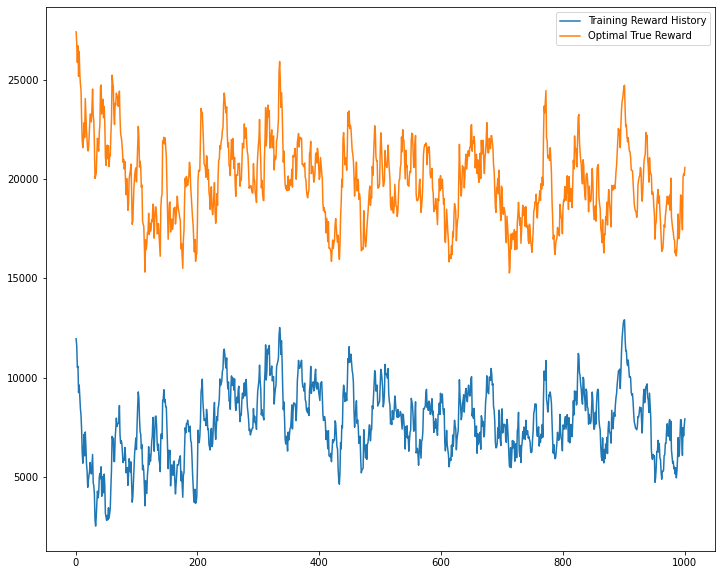

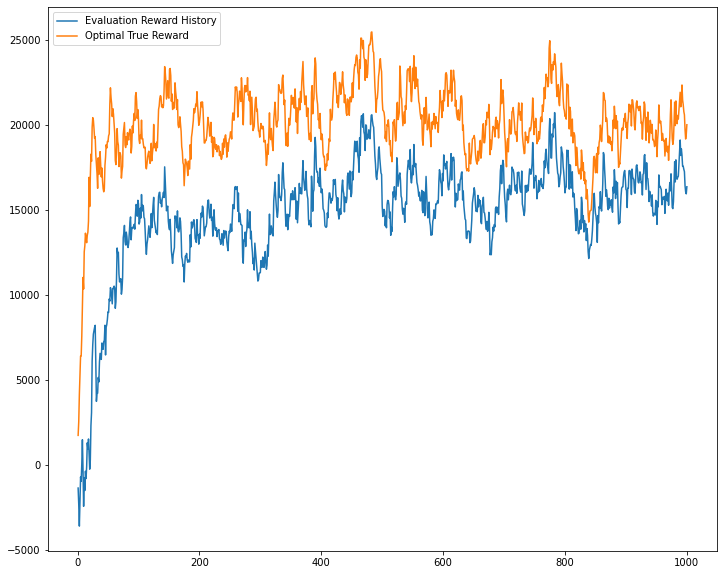

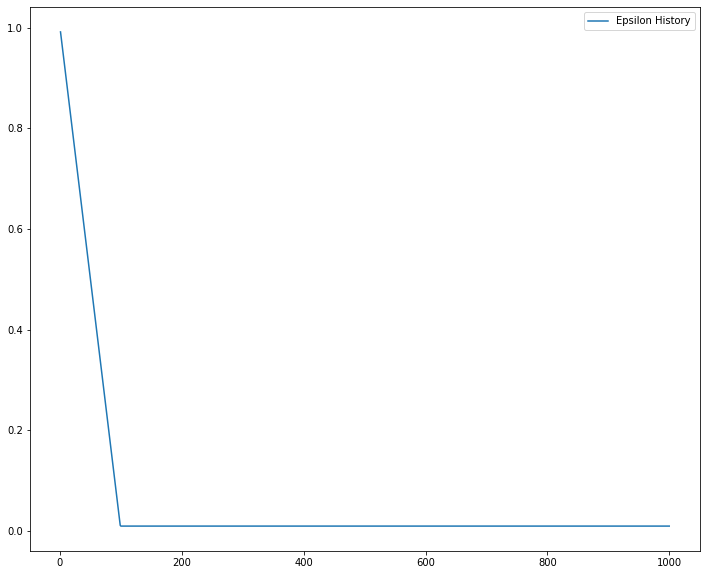

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(x, numpy_ewma_vectorized_v2(np.array(scores), 25), label='Training Reward History')
plt.plot(x, numpy_ewma_vectorized_v2(np.array(optimal_training_scores), 25), label='Optimal True Reward')
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(x, numpy_ewma_vectorized_v2(np.array(eval_scores), 25), label='Evaluation Reward History')
plt.plot(x, numpy_ewma_vectorized_v2(np.array(optimal_evaluation_scores), 25), label='Optimal True Reward')
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(x, eps_history, label='Epsilon History')
plt.legend()
plt.show()

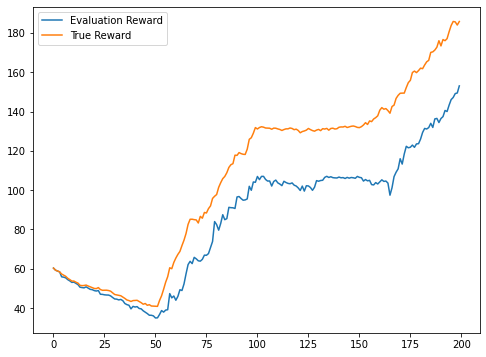

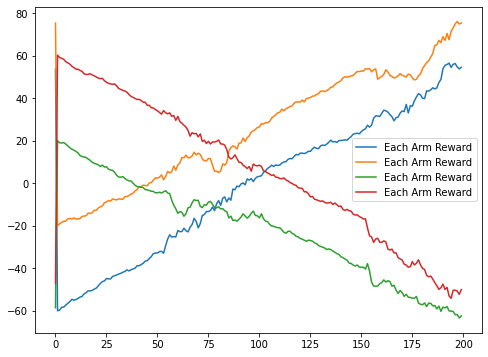

In [ ]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
env = fourarmedbandit(seed=SEED, trend=True, high=True)
obs = env.reset()
# env.set_seed(0)
dones = False
# np.random.seed(0)
# T.manual_seed(0)
for i in range(episodes):
  obs = env.reset()
  dones = False
  optim = 0
  while not dones:
      # action, _states = model.predict(obs)
      obs = obs.flatten()
      state = T.tensor([obs]).to(agent.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
      actions = agent.Q_eval.forward(state)
      action = T.argmax(actions).item()
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = env.e
      rew[i][e][:] = env.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = env.rewards[random_action]
      obs, rewards[i][e], dones, info = env.step(action)
      optimal_reward[i][e] = env.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100


plt.figure(figsize=(8,6))
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward')
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward')
# plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme')
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))